In [1]:
# Importing necessary libraries and general settings

import pandas as pd
import os
import glob
import math
import re
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.animation as animation
from mpl_toolkits import mplot3d
import numpy as np
from scipy.signal import find_peaks

pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
np.set_printoptions(threshold=np.inf)

In [2]:
#block = 6030
#angle = 96-15
def test(final_df,block, angle):
    
    final_df = final_df
    block = block
    angle = angle

    tool_tip_X = final_df['X_TTP Q [mm]'].to_numpy()
    tool_tip_Y = final_df['Y_TTP  [mm]'].to_numpy()
    tool_tip_Z = final_df['Z_TTP  [mm]'].to_numpy()
    X_inv=tool_tip_X
    Y_inv=tool_tip_Y
    Z_inv=tool_tip_Z

    wcx = pd.to_numeric(final_df['DynamicData     WcX']).to_numpy()
    wcy = pd.to_numeric(final_df['DynamicData     WcY']).to_numpy()
    wcz = pd.to_numeric(final_df['DynamicData     WcZ']).to_numpy()

    size = wcx.shape[0]
    ones = np.ones((size,))
    zeros = np.zeros((size,))

    init_C = np.array([[np.cos(np.radians(angle))*ones,  -np.sin(np.radians(angle))*ones, zeros, zeros],
                  [np.sin(np.radians(angle))*ones,  np.cos(np.radians(angle))*ones, zeros, zeros],
                  [zeros,                            zeros,                           ones,  zeros],
                  [zeros,                             zeros,                          zeros, ones]])

    machine_points_xyz   = np.array([[wcx],
                                 [wcy],
                                 [wcz],
                                 [ones]])

    forward_transformation = np.transpose(init_C, (2,0,1))
    tool_position_workpiece_CS = forward_transformation @ np.transpose(machine_points_xyz,(2,0,1))
    tool_position_workpiece_CS = np.transpose(tool_position_workpiece_CS,(1,2,0))

    X = tool_position_workpiece_CS[0,0,:]
    Y = tool_position_workpiece_CS[1,0,:]
    Z = tool_position_workpiece_CS[2,0,:]
    
    subplotter(0,final_df.shape[0],X,Y,Z,X_inv,Y_inv,Z_inv)
    subplotter(0,1000,X,Y,Z,X_inv,Y_inv,Z_inv)
    
    plt.figure(figsize=(10,15))
    ax1 = plt.axes(projection='3d')
    ax1.set_zlim3d([0,30])

    ax1.set_xlabel('$X$ in mm', fontsize=20)
    ax1.set_ylabel('$Y$ in mm', fontsize=20)
    ax1.set_zlabel('$Z$ in mm', fontsize=20)

    ax1.scatter3D(X_inv, Y_inv, Z_inv, color = 'red',label = 'Planning Data')
    ax1.legend()

    ax1.scatter3D(X, Y, Z, color = 'blue',label = 'Machine Data Avg')
    ax1.legend()


In [3]:
def shift(final_df, block, angle):
  
    final_df = final_df
    block = block
    angle = angle

    tool_tip_X = final_df['X_TTP Q [mm]'].to_numpy()
    tool_tip_Y = final_df['Y_TTP  [mm]'].to_numpy()
    tool_tip_Z = final_df['Z_TTP  [mm]'].to_numpy()
    
    X_inv_final = tool_tip_X
    Y_inv_final = tool_tip_Y
    Z_inv_final = tool_tip_Z

    wcx = pd.to_numeric(final_df['DynamicData     WcX']).to_numpy()
    wcy = pd.to_numeric(final_df['DynamicData     WcY']).to_numpy()
    wcz = pd.to_numeric(final_df['DynamicData     WcZ']).to_numpy()

    size = wcx.shape[0]
    ones = np.ones((size,))
    zeros = np.zeros((size,))

    init_C = np.array([[np.cos(np.radians(angle))*ones,  -np.sin(np.radians(angle))*ones, zeros, zeros],
                  [np.sin(np.radians(angle))*ones,  np.cos(np.radians(angle))*ones, zeros, zeros],
                  [zeros,                            zeros,                           ones,  zeros],
                  [zeros,                             zeros,                          zeros, ones]])

    machine_points_xyz   = np.array([[wcx],
                                 [wcy],
                                 [wcz],
                                 [ones]])

    forward_transformation = np.transpose(init_C, (2,0,1))
    tool_position_workpiece_CS = forward_transformation @ np.transpose(machine_points_xyz,(2,0,1))
    tool_position_workpiece_CS = np.transpose(tool_position_workpiece_CS,(1,2,0))

    X_final = tool_position_workpiece_CS[0,0,:]
    Y_final = tool_position_workpiece_CS[1,0,:]
    Z_final = tool_position_workpiece_CS[2,0,:]
    

    #Shifting the data 
    div = 20
    length = Y_final.shape[0]
    chunck_len = int(length/div)
    
    for i in np.arange(0,div):
        if(i != div-1):
            diff1 = X_final[i*chunck_len:(i+1)*chunck_len] - X_inv_final[i*chunck_len:(i+1)*chunck_len]
            X_final[i*chunck_len:(i+1)*chunck_len] = X_final[i*chunck_len:(i+1)*chunck_len] - np.mean(diff1)
            
            diff2 = Y_final[i*chunck_len:(i+1)*chunck_len] - Y_inv_final[i*chunck_len:(i+1)*chunck_len]
            Y_final[i*chunck_len:(i+1)*chunck_len] = Y_final[i*chunck_len:(i+1)*chunck_len] - np.mean(diff2)
            
            diff3 = Z_final[i*chunck_len:(i+1)*chunck_len] - Z_inv_final[i*chunck_len:(i+1)*chunck_len]
            Z_final[i*chunck_len:(i+1)*chunck_len] = Z_final[i*chunck_len:(i+1)*chunck_len] - np.mean(diff3)


        else:
            diff1 = X_final[i*chunck_len:length] - X_inv_final[i*chunck_len:length]
            X_final[i*chunck_len:length] = X_final[i*chunck_len:length] - np.mean(diff1)
            
            diff2 = Y_final[i*chunck_len:length] - Y_inv_final[i*chunck_len:length]
            Y_final[i*chunck_len:length] = Y_final[i*chunck_len:length] - np.mean(diff2)
            
            diff3 = Z_final[i*chunck_len:length] - Z_inv_final[i*chunck_len:length]
            Z_final[i*chunck_len:length] = Z_final[i*chunck_len:length] - np.mean(diff3)

        
    return X_final,Y_final,Z_final



In [4]:
# Plotting the result obtained during the study
def subplotter(low,high,X,Y,Z,X_inv,Y_inv,Z_inv):
    
    range = np.arange(low,high)
    fig,axs = plt.subplots(3,figsize=(10,15))

    axs[0].plot(range,X[range],label = 'X acquired', color='blue')
    axs[0].plot(range,X_inv[range],label = 'X planning', color='red')
    axs[0].legend() 
    axs[0].set_xlabel('row index (dimension less)')
    axs[0].set_ylabel('X in mm')
    #axs[0].set_title('X data comparison')   
    
    axs[1].plot(range,Y[range], label = 'Y acquired', color='blue')
    axs[1].plot(range,Y_inv[range], label = 'Y planning', color='red') 
    axs[1].legend()
    axs[1].set_xlabel('row index (dimension less)')
    axs[1].set_ylabel('Y in mm')
   # axs[1].set_title('Y data comparison')   
    

    axs[2].plot(range,Z[range], label = 'Z acquired', color='blue')
    axs[2].plot(range,Z_inv[range] , label = 'Z planning', color='red')
    axs[2].legend()
    axs[2].set_xlabel('row index (dimension less)')
    axs[2].set_ylabel('Z in mm')
    #axs[2].set_title('Z data comparison')   
    
    
    fig.canvas.draw()
    fig.canvas.flush_events()


In [30]:
X_inv = [] 
Y_inv = []
Z_inv = []

with open('D:/rohan/thesis/Projects/Machine_Learning/Data_2021/Toolpath2/Finish/O1030.txt', 'r') as f:
    line = True
    while line:
        
        line = f.readline()
        
        if(len(line)==0):
            break
        
        xpos = line.find('X')
        ypos = line.find('Y')
        zpos = line.find('Z')
        endpos = line.find('C')
        
        X_inv.append(float(line[xpos+1:ypos-1]))
        Y_inv.append(float(line[ypos+1:zpos-1]))
        Z_inv.append(float(line[zpos+1:endpos-1]))
        
f.close()

In [35]:
df_p = pd.DataFrame({'X_TTP Q [mm]':np.array(X_inv), 'Y_TTP  [mm]':np.array(Y_inv), 'Z_TTP  [mm]':np.array(Z_inv) })

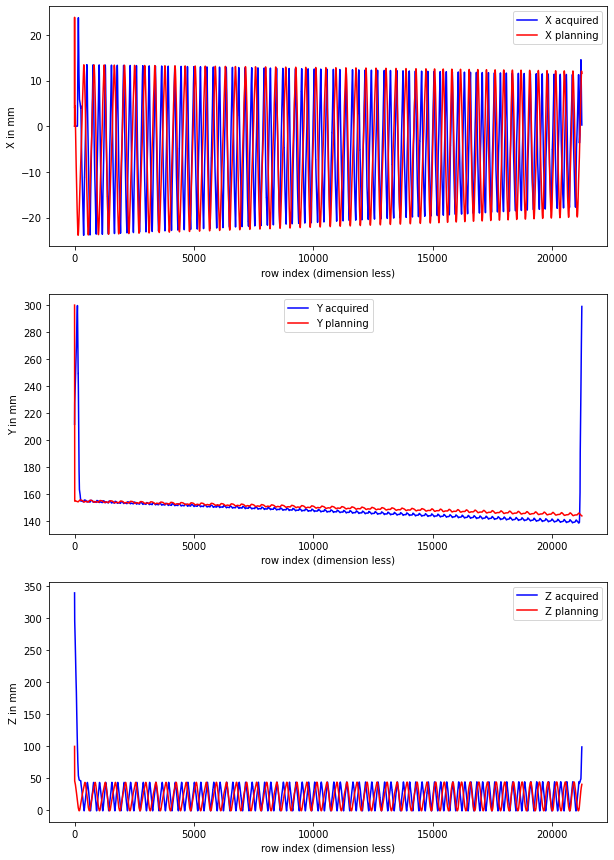

In [36]:
df_m = pd.read_parquet('D:/rohan/thesis/Projects/Machine_Learning/Data_2021/Parquet/96-6030-0.parquet')
#df_m = pd.read_parquet('D:/rohan/thesis/Projects/Machine_Learning/Data_2021/Parquet/0-1030-0.parquet')
block = 6030
angle = 96-15
df_p = pd.read_csv('D:/rohan/thesis/Projects/Machine_Learning/Data_2021/Toolpath/OP6030_TD_and_WD.csv',delimiter= ';')

df_m = df_m.rename(columns=df_m.iloc[0])
df_m = df_m.iloc[1: , :]

tool_tip_X = df_p['X_TTP Q [mm]'].to_numpy()
tool_tip_Y = df_p['Y_TTP  [mm]'].to_numpy()
tool_tip_Z = df_p['Z_TTP  [mm]'].to_numpy()
X_inv=tool_tip_X
Y_inv=tool_tip_Y
Z_inv=tool_tip_Z

wcx = pd.to_numeric(df_m['DynamicData     WcX']).to_numpy()
wcy = pd.to_numeric(df_m['DynamicData     WcY']).to_numpy()
wcz = pd.to_numeric(df_m['DynamicData     WcZ']).to_numpy()

size = wcx.shape[0]
ones = np.ones((size,))
zeros = np.zeros((size,))

init_C = np.array([[np.cos(np.radians(angle))*ones,  -np.sin(np.radians(angle))*ones, zeros, zeros],
                  [np.sin(np.radians(angle))*ones,  np.cos(np.radians(angle))*ones, zeros, zeros],
                  [zeros,                            zeros,                           ones,  zeros],
                  [zeros,                             zeros,                          zeros, ones]])

machine_points_xyz   = np.array([[wcx],
                                 [wcy],
                                 [wcz],
                                 [ones]])

forward_transformation = np.transpose(init_C, (2,0,1))
tool_position_workpiece_CS = forward_transformation @ np.transpose(machine_points_xyz,(2,0,1))
tool_position_workpiece_CS = np.transpose(tool_position_workpiece_CS,(1,2,0))

X = tool_position_workpiece_CS[0,0,:]
Y = tool_position_workpiece_CS[1,0,:]
Z = tool_position_workpiece_CS[2,0,:]

subplotter(0,Y.shape[0],X,Y,Z,X_inv,Y_inv,Z_inv)

In [37]:
# Here the distances are calculated, for each aquired data point, forward transformation was performed above,
# and now for each of those poits the disace for all planning points are calculated.
lst1 = []
lst2 = []

dist  = np.zeros(len(tool_tip_X))
print('Enter the tolerance number value, example 3 mm')
#tol = input()
tol = 3
count = 0 
k = 5

for i in np.arange(len(X)):   # 47917
    
    dist = (((tool_tip_X-X[i])**2+(tool_tip_Y-Y[i])**2+(tool_tip_Z-Z[i])**2)**(1/2))
    
    # partition the data into 5 chuncks and find the closest distance points in those chucks, if we use full set at once, 
    # we may match up with far way points, which were causing lots of outliers
    
    pos = np.argpartition(dist, k)
    pos = pos[:k]
    min_val = dist[pos]
    #print(pos,min_val)
    
    # the position closest the iterator is considered, since the far away values are thus avoided from matching
    pos = pos[np.argmin(abs(pos - i))]
    min_val = dist[pos]
    
    #print(i,pos,min_val)
    # store both position and the value in two separate lists
    if(abs(min_val<=float(tol))): 
        lst1.append(pos)
        lst2.append(min_val)
        count = count+1
        print(i,pos,min_val,count)
    else:
        lst1.append(np.nan)
        lst2.append(np.nan)
   

Enter the tolerance number value, example 3 mm
243 7 2.770283056889471 1
244 7 2.770283056889471 2
245 7 2.423504783484076 3
246 7 2.3088213118204206 4
247 7 2.1946896594977354 5
248 7 2.081220384711561 6
249 7 1.9685406084789219 7
250 7 1.856763117847747 8
251 7 1.621710600561423 9
252 7 1.4086838338917502 10
253 7 1.3056787831040089 11
254 7 1.2058223902964977 12
255 7 1.1099752574108626 13
256 7 0.8595909854348791 14
257 7 0.7950554540120897 15
258 7 0.7443998240142083 16
259 7 0.7105995046781919 17
260 7 0.6210072194903401 18
261 7 0.2742692518834947 19
262 10 0.4630640327881246 20
263 14 0.46470327013573215 21
264 18 0.46814702244925416 22
265 22 0.47320782821192414 23
266 451 0.2889509265707877 24
267 454 0.26654457804898707 25
268 455 0.23355540429732036 26
269 456 0.3726454728151035 27
270 457 0.3149342244610121 28
271 459 0.23317395661239926 29
272 460 0.37321889357198057 30
273 461 0.3152037218973095 31
274 463 0.3200427582897341 32
275 464 0.43703900995832545 33
276 465 0.37

830 909 0.09071174036699443 588
831 910 0.3182396840194128 589
832 910 0.3182396840194128 590
833 911 0.24233115612693962 591
834 912 0.16687466237659596 592
835 914 0.31906486163452874 593
836 915 0.24309388009488542 594
837 916 0.16749006328388283 595
838 917 0.09193267203844839 596
839 918 0.3197607429514464 597
840 919 0.24401265871841224 598
841 920 0.16823900561317606 599
842 921 0.3964719125936231 600
843 922 0.32050647428176 601
844 924 0.16886324245242093 602
845 925 0.09332290513886128 603
846 925 0.3971954935158202 604
847 926 0.3214617019549934 605
848 927 0.2455013789889572 606
849 928 0.16951366728561948 607
850 929 0.09366060728710766 608
851 929 0.39777273725040685 609
852 930 0.3218653005601188 610
853 931 0.24599394646084877 611
854 932 0.16996150297828358 612
855 933 0.0940973317739354 613
856 934 0.019971561559887496 614
857 934 0.3222091400381567 615
858 936 0.170298555739079 616
859 937 0.09439095231206183 617
860 938 0.021925705554600786 618
861 938 0.32239844092

1156 985 0.24943063043499092 914
1157 987 0.22222361094234366 915
1158 989 0.21013439730827374 916
1159 991 0.20658711234458038 917
1160 993 0.20502359461058375 918
1161 995 0.2044413831586092 919
1162 997 0.2040219140742407 920
1163 999 0.20381412172775928 921
1164 1003 0.2033674530886327 922
1165 1005 0.20308130595949422 923
1166 1009 0.20253358629902082 924
1167 1011 0.20220415335160863 925
1168 1013 0.2018482721959394 926
1169 1015 0.20141972510591577 927
1170 1019 0.20074853200439255 928
1171 1021 0.20046527913619203 929
1172 1025 0.19997747522140513 930
1173 1027 0.1995939243509591 931
1174 1029 0.1994928416094592 932
1175 1031 0.1993815473391115 933
1176 1033 0.19937448628967533 934
1177 1035 0.19959773517145685 935
1178 1037 0.19977778403175533 936
1179 1039 0.19992297844109144 937
1180 1041 0.20027268364599757 938
1181 1043 0.2004647380856934 939
1182 1045 0.20080821482206448 940
1183 1047 0.20086035569205188 941
1184 1049 0.2014154437367248 942
1185 1053 0.20257808688344103 9

1497 1586 0.2010189543738857 1255
1498 1587 0.21181971746569878 1256
1499 1588 0.20008432562829934 1257
1500 1589 0.21161826309486603 1258
1501 1590 0.19906066090062716 1259
1502 1591 0.21165599124715082 1260
1503 1591 0.2837095136979445 1261
1504 1592 0.19823922236551395 1262
1505 1593 0.21162492938687263 1263
1506 1594 0.19731277404729428 1264
1507 1595 0.21153140653378438 1265
1508 1596 0.18955332870272443 1266
1509 1597 0.20223066370298512 1267
1510 1601 0.20124840653869278 1268
1511 1602 0.23940259487547802 1269
1512 1604 0.18799106529988313 1270
1513 1605 0.20015487944746152 1271
1514 1608 0.18753727956270275 1272
1515 1609 0.19928970134536084 1273
1516 1610 0.23728255956560662 1274
1517 1612 0.1873116963947209 1275
1518 1613 0.19841104419912295 1276
1519 1614 0.23628405201650987 1277
1520 1615 0.2894217378136293 1278
1521 1617 0.19766727592261885 1279
1522 1618 0.23536036030756244 1280
1523 1619 0.2884256259450437 1281
1524 1621 0.19691471630488716 1282
1525 1622 0.2345485830049

1839 2179 0.372277287669246 1597
1840 2180 0.30863557469727576 1598
1841 2182 0.20804392103159897 1599
1842 1758 0.3839510969739309 1600
1843 2184 0.3090133223599227 1601
1844 2185 0.25253700602957285 1602
1845 1762 0.3846633996232296 1603
1846 2188 0.3095229457887342 1604
1847 2190 0.20951960947091428 1605
1848 1766 0.38533593209259587 1606
1849 2191 0.37327675146221884 1607
1850 2192 0.30984644209209516 1608
1851 1770 0.38603886180653424 1609
1852 2195 0.37340204695303575 1610
1853 2196 0.3101109200026153 1611
1854 2197 0.2541710126287654 1612
1855 2199 0.373568732198813 1613
1856 2200 0.3105613508969022 1614
1857 2201 0.2547934988101042 1615
1858 2202 0.21191607563335396 1616
1859 1778 0.3877077157995488 1617
1860 2203 0.3738991315678399 1618
1861 2204 0.3109733015300427 1619
1862 2206 0.2127779234062684 1620
1863 1782 0.3885499894194658 1621
1864 2207 0.3740863206765306 1622
1865 2208 0.311184844073833 1623
1866 1786 0.38941760896044814 1624
1867 2211 0.3741262805947914 1625
1868 2

2167 2665 0.20320555687080702 1925
2168 2665 0.3732525442589033 1926
2169 2666 0.3117227768990905 1927
2170 2667 0.2582788669806657 1928
2171 2668 0.2187422435540892 1929
2172 2669 0.20404396148871276 1930
2173 2670 0.22877064294765992 1931
2174 2671 0.20310222716408768 1932
2175 2672 0.2579565342857487 1933
2176 2674 0.21913046229433888 1934
2177 2675 0.20496624528879226 1935
2178 2675 0.3718903088691088 1936
2179 2676 0.3108743235055134 1937
2180 2677 0.2579494191956302 1938
2181 2678 0.21937996159632517 1939
2182 2679 0.20561030067799782 1940
2183 2679 0.3710473333003538 1941
2184 2681 0.2575622935096509 1942
2185 2681 0.2575622935096509 1943
2186 2682 0.2194353589507772 1944
2187 2683 0.21975748051608124 1945
2188 2684 0.2583529804520622 1946
2189 2686 0.2043504388909375 1947
2190 2687 0.22385928837228763 1948
2191 2689 0.22637797131175857 1949
2192 2692 0.22451492077684101 1950
2193 2694 0.22097075793274293 1951
2194 2696 0.21887156151954568 1952
2195 2700 0.21602162796834024 1953

2507 3215 0.20744760179819718 2265
2508 3216 0.23123442978613468 2266
2509 3220 0.22970325432385363 2267
2510 3222 0.2161059848553452 2268
2511 3223 0.2053442047733302 2269
2512 3224 0.22827884200242887 2270
2513 3226 0.21549398059503533 2271
2514 3227 0.2040845840477758 2272
2515 3228 0.22665607610501814 2273
2516 3230 0.2152236594458293 2274
2517 3231 0.20293466644043567 2275
2518 3234 0.214786147533236 2276
2519 3235 0.20157964819948582 2277
2520 3236 0.22318144382852592 2278
2521 3238 0.21428497951186734 2279
2522 3240 0.22154780586701528 2280
2523 3241 0.2629446073111946 2281
2524 3243 0.19978009732500637 2282
2525 3244 0.22045267030145912 2283
2526 3245 0.2613706838395751 2284
2527 3248 0.2188777398038584 2285
2528 3249 0.2597394029576688 2286
2529 3251 0.19775799217689163 2287
2530 3253 0.2583371120474817 2288
2531 3255 0.1976260601842276 2289
2532 3257 0.25688069794332175 2290
2533 3260 0.21526341048098374 2291
2534 3261 0.2554387040757756 2292
2535 3263 0.1961424999443113 2293

2818 3721 0.18821297258044706 2576
2819 3722 0.20082785872091516 2577
2820 3725 0.1875339501698949 2578
2821 3726 0.1998760771475782 2579
2822 3726 0.1998760771475782 2580
2823 3727 0.23790827842033557 2581
2824 3731 0.23687997402208164 2582
2825 3733 0.18677115583278642 2583
2826 3734 0.1981293093306688 2584
2827 3735 0.23573789098526537 2585
2828 3738 0.19748415255992705 2586
2829 3739 0.2349989197728876 2587
2830 3740 0.2879347101854912 2588
2831 3742 0.196648474392959 2589
2832 3743 0.23394233635531056 2590
2833 3746 0.19625780814008773 2591
2834 3747 0.23349051503139528 2592
2835 3748 0.28619807741152964 2593
2836 3750 0.1960537030358506 2594
2837 3751 0.23271221720953006 2595
2838 3752 0.2854271243928379 2596
2839 3754 0.19574113578767813 2597
2840 3755 0.23226901736376482 2598
2841 3756 0.28469843202508877 2599
2842 3757 0.36564096556185843 2600
2843 3759 0.3455847774641957 2601
2844 3760 0.3461758225714842 2602
2845 3762 0.19354385881476305 2603
2846 3763 0.23167360792989694 26

3147 4260 0.20127777638027014 2905
3148 4262 0.20156457099969793 2906
3149 4264 0.17921845509219975 2907
3150 4265 0.20208639270920142 2908
3151 4267 0.3051603656863216 2909
3152 4268 0.36974656876187895 2910
3153 4270 0.3061508421793006 2911
3154 4272 0.20398503023641268 2912
3155 3850 0.38118292503745305 2913
3156 4273 0.37081666887303166 2914
3157 4276 0.20449808302748118 2915
3158 3854 0.38160071131809475 2916
3159 4277 0.3712941252628512 2917
3160 3858 0.38190390091576076 2918
3161 4281 0.37180651310649426 2919
3162 4282 0.30800008179121546 2920
3163 4284 0.20603392233813975 2921
3164 4286 0.30845030847657284 2922
3165 4287 0.25133788642627886 2923
3166 4288 0.20671141863650153 2924
3167 3866 0.3828608332487106 2925
3168 4289 0.3728735430437308 2926
3169 4291 0.2518499380718187 2927
3170 4292 0.20737685248880294 2928
3171 3870 0.3833623329377321 2929
3172 4293 0.3731290943006458 2930
3173 4295 0.2524016617470446 2931
3174 4296 0.2081421671457703 2932
3175 3874 0.3838753467118082 2

3475 4338 0.3917230079985638 3233
3476 4760 0.3757650102629746 3234
3477 4763 0.21720094975174725 3235
3478 4342 0.39293365411597925 3236
3479 4764 0.375820930109368 3237
3480 4765 0.31358423734667995 3238
3481 4766 0.25893041735209027 3239
3482 4767 0.2177400045775797 3240
3483 4346 0.39394345774604284 3241
3484 4768 0.37532593932014885 3242
3485 4769 0.3133107685478573 3243
3486 4770 0.2590795248908545 3244
3487 4771 0.21827233176184552 3245
3488 4350 0.39527073345013986 3246
3489 4772 0.37528435267173177 3247
3490 4773 0.31340050932104824 3248
3491 4774 0.2592684900807074 3249
3492 4775 0.21876600929848852 3250
3493 4354 0.3966713968150502 3251
3494 4777 0.31314683196795023 3252
3495 4777 0.31314683196795023 3253
3496 4778 0.2592727358200688 3254
3497 4779 0.2192278138918586 3255
3498 4780 0.3744842750954005 3256
3499 4781 0.31300203466765614 3257
3500 4784 0.20374055834276242 3258
3501 4785 0.21974620060884642 3259
3502 4788 0.25840802194141466 3260
3503 4789 0.21943920536019387 32

3797 5265 0.25195506247106936 3555
3798 5267 0.2522667370010207 3556
3799 5269 0.2527431215013672 3557
3800 5271 0.2530332138778832 3558
3801 5275 0.25307846363652364 3559
3802 5275 0.25307846363652364 3560
3803 5281 0.25252278800194033 3561
3804 5283 0.25199943862001006 3562
3805 5285 0.25143322822834885 3563
3806 5287 0.25080281107634 3564
3807 5289 0.250148372776648 3565
3808 5291 0.24910086395734166 3566
3809 5297 0.2458312175621203 3567
3810 5299 0.24472829343620023 3568
3811 5301 0.24307239237968542 3569
3812 5303 0.24159937627377698 3570
3813 5305 0.2396846633647831 3571
3814 5307 0.21780744118393514 3572
3815 5308 0.21103687180469208 3573
3816 5309 0.21164696428535984 3574
3817 5312 0.215199654832626 3575
3818 5315 0.2207675789664541 3576
3819 5316 0.2135631034623731 3577
3820 5317 0.25812145028901523 3578
3821 5317 0.2803418896465175 3579
3822 4897 0.41120348288478864 3580
3823 5319 0.25694717812712786 3581
3824 4899 0.4090493105791469 3582
3825 5321 0.25619877822435766 3583
3

4138 5805 0.1931530645530383 3896
4139 5806 0.21036676330554632 3897
4140 5809 0.19280462864783934 3898
4141 5810 0.20943833795694622 3899
4142 5390 0.39084524999499465 3900
4143 5811 0.3029414894249774 3901
4144 5391 0.4001077370638753 3902
4145 5392 0.390361729507405 3903
4146 5813 0.30145064502212265 3904
4147 5394 0.390161819171513 3905
4148 5815 0.3000048280997583 3906
4149 5395 0.39771225153526907 3907
4150 5396 0.38997476112214163 3908
4151 5397 0.3963930135937354 3909
4152 5398 0.3898896629629775 3910
4153 5819 0.29704413137164626 3911
4154 5399 0.3952739572237695 3912
4155 5822 0.20266009656857573 3913
4156 5823 0.2412953360954081 3914
4157 5826 0.20178100496034 3915
4158 5827 0.2400456525436633 3916
4159 5830 0.200766865671705 3917
4160 5831 0.2388879690985012 3918
4161 5833 0.1873247343139674 3919
4162 5834 0.19993235207388882 3920
4163 5838 0.1992411757262329 3921
4164 5839 0.2368832845082283 3922
4165 5841 0.18682515670156893 3923
4166 5843 0.2357607519745358 3924
4167 584

4460 6313 0.1925728782556549 4218
4461 6315 0.19241605560212333 4219
4462 6317 0.19236516960353145 4220
4463 6319 0.19258658619359162 4221
4464 6321 0.1924872280250895 4222
4465 6323 0.19264650399471353 4223
4466 6327 0.19287416001016663 4224
4467 6329 0.19331480135810533 4225
4468 6329 0.19331480135810533 4226
4469 6331 0.1936097482919371 4227
4470 6333 0.19384986252686615 4228
4471 6335 0.1941141352237373 4229
4472 6337 0.19440460668724563 4230
4473 6339 0.19479689971664216 4231
4474 6343 0.19595988771543202 4232
4475 6345 0.19636278149311745 4233
4476 6347 0.197009926904687 4234
4477 6349 0.19722208767401553 4235
4478 6351 0.198048394901756 4236
4479 6353 0.19823353877975364 4237
4480 6355 0.19893759639795625 4238
4481 6357 0.19949935899289875 4239
4482 6359 0.20004837957364283 4240
4483 6361 0.2005321997864074 4241
4484 6363 0.20089670725367362 4242
4485 6365 0.20151277971155473 4243
4486 6367 0.20191951723140353 4244
4487 6369 0.20216670900321018 4245
4488 6371 0.17952235664534236

4784 6831 0.37498726539152455 4542
4785 6832 0.31138567586170157 4543
4786 6414 0.3856320978961343 4544
4787 6835 0.3753782636864326 4545
4788 6836 0.31182975327142737 4546
4789 6837 0.25535926520623686 4547
4790 6838 0.2115180217432355 4548
4791 6839 0.3753924728415317 4549
4792 6840 0.3120184505231003 4550
4793 6841 0.2557189989683288 4551
4794 6842 0.21235497259983016 4552
4795 6422 0.38697035200497365 4553
4796 6843 0.3754486040339315 4554
4797 6844 0.3123190181104455 4555
4798 6845 0.25627163600259256 4556
4799 6426 0.38781053841070423 4557
4800 6847 0.3756292651253781 4558
4801 6848 0.31250908286411455 4559
4802 6849 0.2566714349933438 4560
4803 6430 0.3887975783274377 4561
4804 6852 0.3126376406138576 4562
4805 6853 0.2571086719444469 4563
4806 6854 0.21449756264524208 4564
4807 6434 0.38968760952495374 4565
4808 6857 0.25736910261718887 4566
4809 6858 0.21525764901641503 4567
4810 6859 0.37547880241861975 4568
4811 6860 0.31293863549856804 4569
4812 6861 0.25778428105474677 457

5115 7306 0.37441777050875885 4873
5116 7307 0.3129301310189648 4874
5117 7308 0.25922254648515897 4875
5118 7310 0.20356956420323763 4876
5119 7311 0.22649228453035875 4877
5120 7312 0.20304801457151797 4878
5121 7313 0.2590037783592476 4879
5122 7315 0.21970613074844791 4880
5123 7316 0.2044280846790019 4881
5124 7316 0.2044280846790019 4882
5125 7316 0.3729557619220771 4883
5126 7317 0.3118683463150874 4884
5127 7318 0.25865803219830924 4885
5128 7320 0.20521597764048088 4886
5129 7320 0.37212424793385956 4887
5130 7321 0.31107246448650666 4888
5131 7322 0.2584228075363061 4889
5132 7323 0.22036893959747342 4890
5133 7325 0.25928960707846405 4891
5134 7327 0.20492089633796107 4892
5135 7328 0.2246527860595896 4893
5136 7330 0.22734393368445704 4894
5137 7337 0.21905168554651558 4895
5138 7339 0.2175753183345585 4896
5139 7341 0.216315810675794 4897
5140 7343 0.2153969699875039 4898
5141 7347 0.21330969391359583 4899
5142 7351 0.21151521600496684 4900
5143 7353 0.21032839912472867 49

5435 7842 0.21520980415515156 5193
5436 7844 0.281741504920582 5194
5437 7423 0.41339745508743025 5195
5438 7846 0.2797853642068627 5196
5439 7425 0.4113873034943524 5197
5440 7848 0.2549678083269362 5198
5441 7848 0.27810332230036927 5199
5442 7852 0.2166332576540096 5200
5443 7853 0.20900872408483562 5201
5444 7854 0.2322439489883661 5202
5445 7856 0.21540787110997314 5203
5446 7857 0.20742128697130213 5204
5447 7858 0.23039694179300113 5205
5448 7861 0.2061155526689494 5206
5449 7862 0.2289221838350271 5207
5450 7864 0.21415076783333564 5208
5451 7865 0.20468796050860824 5209
5452 7866 0.22700918490770097 5210
5453 7868 0.21301596282877355 5211
5454 7870 0.22526291689186143 5212
5455 7872 0.21255444872456855 5213
5456 7874 0.22375586245821036 5214
5457 7874 0.22375586245821036 5215
5458 7876 0.2124003671490089 5216
5459 7877 0.2006301212408671 5217
5460 7880 0.2122977795453151 5218
5461 7881 0.19961438959389308 5219
5462 7882 0.22082839776572702 5220
5463 7885 0.1990437718813329 522

5767 8349 0.19914397991650948 5525
5768 8351 0.1885272950573194 5526
5769 8352 0.20241242094351783 5527
5770 8353 0.24078812690486587 5528
5771 8355 0.18795766620040075 5529
5772 8356 0.20117953769908367 5530
5773 8357 0.23945292629298376 5531
5774 8359 0.18756582489562373 5532
5775 8361 0.238392555754961 5533
5776 8363 0.18689351059340048 5534
5777 8364 0.19930591175496273 5535
5778 8365 0.23731608883566851 5536
5779 8367 0.1866052973523758 5537
5780 8372 0.1973487470179263 5538
5781 8373 0.23530835714815107 5539
5782 8377 0.23421070224865825 5540
5783 8378 0.2873660805462219 5541
5784 8380 0.1960763714836527 5542
5785 8381 0.23346131356647706 5543
5786 8384 0.1955405342128469 5544
5787 8385 0.2326728437068899 5545
5788 8386 0.28534566732411093 5546
5789 8388 0.19523262866720992 5547
5790 8390 0.28452344673556956 5548
5791 8390 0.28452344673556956 5549
5792 8392 0.19495774805566823 5550
5793 8393 0.23147922048349803 5551
5794 8394 0.28356396480051804 5552
5795 8395 0.345034573161375 5

6096 8896 0.20277565790395877 5854
6097 8899 0.2033009037684344 5855
6098 8900 0.248940007249071 5856
6099 8901 0.3068261742745682 5857
6100 8902 0.37145593787407205 5858
6101 8903 0.37188066783254525 5859
6102 8904 0.3078085582285172 5860
6103 8487 0.38176684073256517 5861
6104 8908 0.3081635377358023 5862
6105 8909 0.2505918654471267 5863
6106 8910 0.20565519055493672 5864
6107 8491 0.381926774237755 5865
6108 8912 0.3086389123168102 5866
6109 8913 0.25117256818502853 5867
6110 8495 0.382290238787624 5868
6111 8917 0.2511607977214213 5869
6112 8918 0.20659806037350453 5870
6113 8499 0.38292245345072073 5871
6114 8919 0.3728575839091212 5872
6115 8920 0.30908139377481203 5873
6116 8921 0.25182605860962015 5874
6117 8503 0.38320918757196826 5875
6118 8923 0.3734228580900893 5876
6119 8924 0.30949912184596123 5877
6120 8925 0.2523659880910486 5878
6121 8926 0.2079178676886706 5879
6122 8507 0.38391568218487876 5880
6123 8928 0.3100063670276645 5881
6124 8929 0.25299514302908505 5882
612

6419 8950 0.38737261247524013 6177
6420 9370 0.37562901730753084 6178
6421 9371 0.3123656172046414 6179
6422 9373 0.2134054075694942 6180
6423 8954 0.3882582826215562 6181
6424 9374 0.3756712559051799 6182
6425 9375 0.31265134288827917 6183
6426 9376 0.2568967137977093 6184
6427 9377 0.2142135841385685 6185
6428 8958 0.38911840840992357 6186
6429 9379 0.3128435424353122 6187
6430 9380 0.25737354886427904 6188
6431 9381 0.2148222122917946 6189
6432 8962 0.3899757052150835 6190
6433 9382 0.37580698647845234 6191
6434 9384 0.25783513818368 6192
6435 8966 0.39112633683722126 6193
6436 9387 0.31303624377182143 6194
6437 9387 0.31303624377182143 6195
6438 9388 0.2580811165273538 6196
6439 9389 0.2163781024077093 6197
6440 9390 0.37573047958443173 6198
6441 9391 0.313265506278348 6199
6442 9392 0.25850946650170936 6200
6443 9393 0.216902981975223 6201
6444 8974 0.3932400468894473 6202
6445 9395 0.31325527387476637 6203
6446 9396 0.25877138533887106 6204
6447 9397 0.2175417492750724 6205
6448 

6745 9883 0.2083544911167093 6503
6746 9884 0.24894424387795497 6504
6747 9886 0.24992407580657763 6505
6748 9888 0.2509583673907685 6506
6749 9890 0.25162957473462155 6507
6750 9892 0.2524068694854951 6508
6751 9894 0.2530364458248171 6509
6752 9898 0.25382334418841057 6510
6753 9900 0.2541401874128026 6511
6754 9902 0.2544467875614588 6512
6755 9906 0.2545910608468616 6513
6756 9908 0.25425632636251794 6514
6757 9910 0.2540395542843416 6515
6758 9914 0.25326427127364287 6516
6759 9916 0.25282445454443403 6517
6760 9918 0.252075373983238 6518
6761 9922 0.25036561087893433 6519
6762 9924 0.24935943534861282 6520
6763 9928 0.24691647408549455 6521
6764 9930 0.24542267451171335 6522
6765 9932 0.24380201993646003 6523
6766 9934 0.24218917556022213 6524
6767 9936 0.240314746241587 6525
6768 9938 0.21840702605186993 6526
6769 9940 0.2119640911586561 6527
6770 9942 0.21760226196687854 6528
6771 9943 0.24014478146528573 6529
6772 9945 0.2200493233277123 6530
6773 9946 0.21432609684173168 6531

7061 10382 0.22941373581862767 6819
7062 10384 0.2132193163033218 6820
7063 10386 0.22794338094871455 6821
7064 10388 0.21254148973952763 6822
7065 10389 0.2038604287733517 6823
7066 10392 0.21212196182090232 6824
7067 10393 0.20253566480577345 6825
7068 10394 0.22489960581037932 6826
7069 10398 0.22302353761233631 6827
7070 10400 0.21134266459538067 6828
7071 10401 0.2001388341960434 6829
7072 10402 0.22171273740310796 6830
7073 10404 0.21120098311230012 6831
7074 10405 0.19914569036829916 6832
7075 10408 0.21114338477215264 6833
7076 10409 0.19804119231337292 6834
7077 10410 0.21878788524948706 6835
7078 10412 0.21137576577532027 6836
7079 10412 0.3143009742964307 6837
7080 10416 0.1965022520840534 6838
7081 10417 0.21615656847102227 6839
7082 10421 0.21462462053309758 6840
7083 10422 0.25534462535508073 6841
7084 10424 0.19504938796984037 6842
7085 10425 0.21338166475738293 6843
7086 10426 0.2539619675790574 6844
7087 10428 0.19406096587697197 6845
7088 10429 0.2121493577580708 6846

7377 10873 0.20176500947641773 7135
7378 10874 0.23992243243323144 7136
7379 10876 0.18728544316835782 7137
7380 10877 0.20066262258790646 7138
7381 10880 0.18696154717239682 7139
7382 10881 0.19952762181902456 7140
7383 10882 0.23765923348377352 7141
7384 10884 0.18650356035471652 7142
7385 10885 0.19864055686453067 7143
7386 10888 0.18569235245072352 7144
7387 10890 0.23546293563540294 7145
7388 10893 0.1967776836323198 7146
7389 10894 0.2344336803658129 7147
7390 10896 0.18497903601922158 7148
7391 10897 0.19598380202341228 7149
7392 10899 0.28653628895562455 7150
7393 10901 0.19527695349822266 7151
7394 10902 0.23239916185236986 7152
7395 10903 0.2853709244865292 7153
7396 10906 0.23174422569715208 7154
7397 10907 0.2843320344294069 7155
7398 10909 0.19417447031221446 7156
7399 10910 0.230697101415031 7157
7400 10913 0.19378843238642748 7158
7401 10914 0.2301971723998783 7159
7402 10915 0.19350536429601192 7160
7403 10916 0.19341779854989205 7161
7404 10917 0.19303452780715694 7162

7705 11004 0.3816703424581746 7463
7706 11425 0.19813058977896328 7464
7707 11425 0.308337425302894 7465
7708 11008 0.3820659882698035 7466
7709 11429 0.30888093288943447 7467
7710 11430 0.2514049534968049 7468
7711 11012 0.3825626618555646 7469
7712 11434 0.2520380961687445 7470
7713 11435 0.20699417644638066 7471
7714 11016 0.3828191428357827 7472
7715 11436 0.37410652485280865 7473
7716 11439 0.20776678461924658 7474
7717 11440 0.37463362230782876 7475
7718 11441 0.31066270921913586 7476
7719 11442 0.2533208527601375 7477
7720 11444 0.37513212267989804 7478
7721 11445 0.3111094966689834 7479
7722 11446 0.2539874532960207 7480
7723 11447 0.20934745343155164 7481
7724 11028 0.3843463515019067 7482
7725 11450 0.25453180616773174 7483
7726 11451 0.20990239129594832 7484
7727 11032 0.38484543267637994 7485
7728 11453 0.31182971616617616 7486
7729 11454 0.2549868210316729 7487
7730 11036 0.3853974117052052 7488
7731 11456 0.37577082711685955 7489
7732 11457 0.3121660100578324 7490
7733 11

8040 11924 0.31441598413960015 7798
8041 11925 0.2599990041603732 7799
8042 11927 0.37565455233701334 7800
8043 11928 0.3139417808414558 7801
8044 11929 0.259951675844075 7802
8045 11930 0.21974475034255356 7803
8046 11511 0.39818041644445834 7804
8047 11931 0.3751765698794772 7805
8048 11932 0.3135488943782085 7806
8049 11933 0.25988071870703927 7807
8050 11934 0.22011348663934902 7808
8051 11935 0.20346936477935887 7809
8052 11936 0.2202707745453222 7810
8053 11937 0.3131168838058637 7811
8054 11938 0.31298378492850876 7812
8055 11939 0.2598644070695966 7813
8056 11940 0.22066925345898442 7814
8057 11941 0.2043526495348785 7815
8058 11941 0.3740371458821078 7816
8059 11943 0.2596054108191014 7817
8060 11944 0.2207567527423849 7818
8061 11945 0.20529762453830647 7819
8062 11945 0.3724442968364699 7820
8063 11946 0.31154686530819004 7821
8064 11947 0.25902957700765555 7822
8065 11948 0.2593032760315228 7823
8066 11950 0.2078639375994837 7824
8067 11951 0.22397141319671887 7825
8068 119

8370 12485 0.20510946570475413 8128
8371 12486 0.2275843940758437 8129
8372 12488 0.2113824725037743 8130
8373 12489 0.20334368431600588 8131
8374 12490 0.22588278511855775 8132
8375 12492 0.21086888458635022 8133
8376 12493 0.20227428814721396 8134
8377 12494 0.22427803194745266 8135
8378 12496 0.2105856420853088 8136
8379 12498 0.22302141682764665 8137
8380 12500 0.21062311120363883 8138
8381 12501 0.20043563104361306 8139
8382 12502 0.22143579187840184 8140
8383 12504 0.2103010721658467 8141
8384 12505 0.19889633028772818 8142
8385 12506 0.21987771384992674 8143
8386 12508 0.20998647794244868 8144
8387 12509 0.19787927315175186 8145
8388 12510 0.21846492009390628 8146
8389 12511 0.2598739293974198 8147
8390 12512 0.19675056630983367 8148
8391 12514 0.2580534752009281 8149
8392 12516 0.19594439200839928 8150
8393 12517 0.21561748112379295 8151
8394 12518 0.25663856441351074 8152
8395 12520 0.19565102393524716 8153
8396 12522 0.25509686520292235 8154
8397 12524 0.19443896788041398 815

8699 13002 0.28490612729057385 8457
8700 13005 0.23099439133429464 8458
8701 13006 0.2837766592930927 8459
8702 13008 0.19374410592725635 8460
8703 13009 0.230201790816492 8461
8704 13010 0.2829244869805109 8462
8705 13011 0.356655350589207 8463
8706 12594 0.3819702565253215 8464
8707 13014 0.3445611056554484 8465
8708 13014 0.3445611056554484 8466
8709 13016 0.19278393119502688 8467
8710 13019 0.1787280021053174 8468
8711 13020 0.192561273147742 8469
8712 13022 0.19270584451298786 8470
8713 13024 0.19266707944465106 8471
8714 13026 0.1928484688707689 8472
8715 13028 0.1927618480406792 8473
8716 13032 0.19277945714317682 8474
8717 13034 0.1929757074087119 8475
8718 13036 0.19301709241887877 8476
8719 13040 0.19339907906464868 8477
8720 13042 0.19341686903746133 8478
8721 13044 0.19329797172225496 8479
8722 13046 0.19361699805917815 8480
8723 13048 0.19387305833859458 8481
8724 13050 0.19396758969214942 8482
8725 13052 0.19423345488369018 8483
8726 13054 0.1946548647476663 8484
8727 130

9040 13557 0.31338061909812914 8798
9041 13558 0.2568027306330996 8799
9042 13559 0.21292096189908943 8800
9043 13141 0.3872306005370083 8801
9044 13562 0.25731203243145667 8802
9045 13563 0.21356649866237648 8803
9046 13145 0.3878307034627319 8804
9047 13565 0.31387022557073413 8805
9048 13567 0.21436724062026924 8806
9049 13149 0.38859708062393983 8807
9050 13568 0.37712949935580903 8808
9051 13569 0.3141713865274301 8809
9052 13570 0.2581657439471816 8810
9053 13571 0.21508272931287126 8811
9054 13572 0.3771320025530153 8812
9055 13574 0.2585465433876405 8813
9056 13575 0.21584095138948278 8814
9057 13576 0.3772769529651874 8815
9058 13578 0.258920034212726 8816
9059 13161 0.3908928323607083 8817
9060 13580 0.3773033097128509 8818
9061 13581 0.3146901973869509 8819
9062 13582 0.25923621018189663 8820
9063 13165 0.391898727395397 8821
9064 13584 0.3771530083155908 8822
9065 13586 0.2594910383566872 8823
9066 13587 0.21762433774563547 8824
9067 13588 0.3769979555193512 8825
9068 13590

9371 14037 0.2602790727948146 9129
9372 14038 0.22114851449695458 9130
9373 14039 0.20492678177475665 9131
9374 14040 0.3122862569339666 9132
9375 14041 0.2596539117959355 9133
9376 14042 0.22135892172677196 9134
9377 14043 0.2214836594949618 9135
9378 14044 0.2605773704404826 9136
9379 14047 0.2260021402433589 9137
9380 14049 0.22892695054728576 9138
9381 14052 0.22430449731477367 9139
9382 14054 0.22100364666772604 9140
9383 14058 0.21775327556022236 9141
9384 14060 0.2167089939582394 9142
9385 14062 0.21533139071351964 9143
9386 14066 0.21331644312899595 9144
9387 14068 0.21210113291944888 9145
9388 14070 0.2111909319347902 9146
9389 14072 0.21023550674256797 9147
9390 14074 0.20945180153543116 9148
9391 14076 0.20859516211721002 9149
9392 14077 0.2499776703092528 9150
9393 14079 0.25099949133467464 9151
9394 14081 0.2519259167488592 9152
9395 14083 0.252728304828966 9153
9396 14085 0.2536223860136177 9154
9397 14087 0.2542439203507779 9155
9398 14089 0.25471924379587346 9156
9399 1

9707 14599 0.1982229815105561 9465
9708 14599 0.3866272195943307 9466
9709 14601 0.2536425794343257 9467
9710 14603 0.21720747946387076 9468
9711 14604 0.25173349566862596 9469
9712 14606 0.19640309262456612 9470
9713 14606 0.383195819980323 9471
9714 14610 0.19589219690451867 9472
9715 14612 0.24946574358601262 9473
9716 14612 0.24946574358601262 9474
9717 14614 0.3792618806647853 9475
9718 14614 0.3792618806647853 9476
9719 14618 0.19365084313716519 9477
9720 14618 0.37711678852333486 9478
9721 14622 0.1928403549305602 9479
9722 14622 0.3752338356129638 9480
9723 14624 0.24597560549486794 9481
9724 14625 0.1923131741715349 9482
9725 14209 0.40288531300763314 9483
9726 14626 0.24487536246030353 9484
9727 14629 0.1908480757402896 9485
9728 14629 0.1908480757402896 9486
9729 14213 0.4001391963616128 9487
9730 14630 0.2424202650356123 9488
9731 14631 0.19019099732431258 9489
9732 14633 0.18966665726391488 9490
9733 14217 0.3974264456908053 9491
9734 14634 0.24005890618502837 9492
9735 14

10041 15088 0.1950887133906587 9799
10042 15090 0.1954283413399795 9800
10043 15092 0.1958569117780172 9801
10044 15094 0.19636210830003184 9802
10045 15096 0.1967455099975088 9803
10046 15098 0.19724401122399646 9804
10047 15100 0.19776688987899482 9805
10048 15104 0.19873475398037196 9806
10049 15106 0.19910386407351108 9807
10050 15108 0.19987183294130215 9808
10051 15112 0.20082025435973622 9809
10052 15114 0.20131377248833124 9810
10053 15116 0.2017034351133018 9811
10054 15118 0.20232896540887604 9812
10055 15120 0.20279151962620473 9813
10056 15122 0.20342393289403565 9814
10057 15124 0.2038996356990487 9815
10058 15126 0.20420040504031445 9816
10059 15128 0.2045480021379798 9817
10060 15129 0.2503713773972285 9818
10061 15131 0.17927296522597605 9819
10062 15132 0.2049910252108227 9820
10063 15133 0.25131246314196526 9821
10064 15134 0.2452522633762374 9822
10065 14774 0.3823109032489792 9823
10066 15137 0.3099284369777874 9824
10067 15138 0.25206387490836235 9825
10068 14778 0

10371 15533 0.2561452120734976 10129
10372 15173 0.38729731580834176 10130
10373 15535 0.3763914727951472 10131
10374 15536 0.3130940619785589 10132
10375 15537 0.2566732036075698 10133
10376 15177 0.3877399733565083 10134
10377 15539 0.37647757495093936 10135
10378 15540 0.3132997851246454 10136
10379 15542 0.21378079177645992 10137
10380 15181 0.3882808207734532 10138
10381 15543 0.37657723303881313 10139
10382 15544 0.3136044207334266 10140
10383 15546 0.21456655794041535 10141
10384 15547 0.37660153415041947 10142
10385 15549 0.25816233426545465 10143
10386 15549 0.25816233426545465 10144
10387 15550 0.21541572272184725 10145
10388 15551 0.376905047593868 10146
10389 15552 0.3141424369404972 10147
10390 15553 0.25851612971606525 10148
10391 15554 0.21607931844379416 10149
10392 15193 0.390625270049473 10150
10393 15555 0.37700579288183866 10151
10394 15558 0.21670111772853015 10152
10395 15197 0.39154669369654993 10153
10396 15559 0.37682812780740516 10154
10397 15560 0.31443545390

10711 16001 0.201416496780731 10469
10712 16003 0.20106560818243024 10470
10713 16005 0.20069840667644373 10471
10714 16007 0.20048652980751927 10472
10715 16009 0.20058787199796238 10473
10716 16011 0.20037301434117313 10474
10717 16013 0.2002261315267413 10475
10718 16015 0.20026113809662502 10476
10719 16017 0.2002882987531441 10477
10720 16019 0.20042275056884862 10478
10721 16021 0.2009548597960973 10479
10722 16025 0.2018105171581633 10480
10723 16027 0.20253745497013992 10481
10724 16031 0.2035891629437468 10482
10725 16035 0.20475862210333431 10483
10726 16037 0.20542458990280954 10484
10727 16039 0.20595482221558187 10485
10728 16043 0.20695380941555766 10486
10729 16045 0.20704430035082408 10487
10730 16047 0.20762578273150256 10488
10731 16049 0.20802841234965486 10489
10732 16051 0.2103744766402611 10490
10733 16052 0.24043317260913827 10491
10734 16055 0.22541966876820133 10492
10735 16055 0.33813231536473143 10493
10736 15695 0.4208383832011309 10494
10737 16058 0.2475322

10992 16394 0.20397284474272614 10750
10993 16398 0.2052310152471262 10751
10994 16402 0.20617747610367515 10752
10995 16406 0.2072181267523852 10753
10996 16408 0.2072961791591912 10754
10997 16412 0.20854190741348355 10755
10998 16415 0.2102397288196444 10756
10999 16416 0.2389329253263956 10757
11000 16418 0.21266650755164876 10758
11001 16419 0.24690864422773331 10759
11002 16419 0.2825892172390737 10760
11003 16058 0.42023152489948185 10761
11004 16421 0.24639738690888274 10762
11005 16421 0.2816123145502597 10763
11006 16060 0.418225908944932 10764
11007 16423 0.2455287438613363 10765
11008 16062 0.41605704184763953 10766
11009 16425 0.2447926712203359 10767
11010 16064 0.41397732414916355 10768
11011 16427 0.2439211211970797 10769
11012 16427 0.27647344788573186 10770
11013 16066 0.4118820122129978 10771
11014 16429 0.24335297319281243 10772
11015 16068 0.4096191954544112 10773
11016 16431 0.24289008646837987 10774
11017 16431 0.2729510149664143 10775
11018 16070 0.4073091925418

11296 16802 0.2650489056620661 11054
11297 16441 0.39793882243529155 11055
11298 16804 0.24560294042027997 11056
11299 16804 0.26341207396255367 11057
11300 16806 0.26156284480831776 11058
11301 16445 0.39406289404887673 11059
11302 16808 0.24837761756086793 11060
11303 16808 0.2599940528938814 11061
11304 16447 0.3924903277552663 11062
11305 16810 0.24882443558468853 11063
11306 16810 0.25845371726772265 11064
11307 16812 0.2480653166051398 11065
11308 16812 0.25697707861403546 11066
11309 16451 0.39027210650239963 11067
11310 16814 0.25524230890147215 11068
11311 16816 0.24779500736480348 11069
11312 16816 0.25381131479906444 11070
11313 16455 0.3882288143840556 11071
11314 16818 0.2474293946701982 11072
11315 16457 0.3874254847267843 11073
11316 16820 0.24700985978283557 11074
11317 16820 0.2508302991396015 11075
11318 16459 0.38647097296355615 11076
11319 16822 0.24951471978647655 11077
11320 16824 0.24816724656521727 11078
11321 16463 0.38465231566947167 11079
11322 16826 0.246333

11635 17243 0.23409995804484982 11393
11636 17245 0.23408333914770366 11394
11637 17247 0.23443725636524088 11395
11638 17249 0.2346921615020731 11396
11639 17251 0.23519190185098 11397
11640 17253 0.23527296680745552 11398
11641 17257 0.23618409136036606 11399
11642 17259 0.23656089028349436 11400
11643 17261 0.2372871593243214 11401
11644 17263 0.23759942734206604 11402
11645 17267 0.23915435174194608 11403
11646 17269 0.239803241236686 11404
11647 17271 0.240437782311203 11405
11648 17273 0.24125957986019098 11406
11649 17275 0.2419675428053251 11407
11650 17277 0.2427360679673554 11408
11651 17279 0.2434570710183246 11409
11652 17281 0.24419557828830174 11410
11653 17283 0.24519891999556462 11411
11654 17285 0.2458437724464653 11412
11655 17287 0.24655689077200763 11413
11656 17289 0.2474639440666165 11414
11657 17291 0.24806031403666695 11415
11658 17293 0.24882089810863112 11416
11659 17295 0.24940763837996022 11417
11660 17297 0.2498160000012135 11418
11661 17301 0.2049894714377

11969 17714 0.21437394210951413 11727
11970 17717 0.2585146208466572 11728
11971 17718 0.2152257882968801 11729
11972 17357 0.3893350323328143 11730
11973 17719 0.3778719344524712 11731
11974 17722 0.21593193060151605 11732
11975 17361 0.39003297863146835 11733
11976 17724 0.3152086628397451 11734
11977 17726 0.21664366370758117 11735
11978 17365 0.3907963474313193 11736
11979 17727 0.37815430637393793 11737
11980 17728 0.31527194552085896 11738
11981 17729 0.25977137381811344 11739
11982 17730 0.21724053153181683 11740
11983 17369 0.3914904667592471 11741
11984 17733 0.2601560631138465 11742
11985 17734 0.21794779443327778 11743
11986 17373 0.3923950484943902 11744
11987 17735 0.3781730254839837 11745
11988 17737 0.2604914495164697 11746
11989 17738 0.21857136153579743 11747
11990 17377 0.39348367737986045 11748
11991 17739 0.37794499455819647 11749
11992 17740 0.31546524343313775 11750
11993 17741 0.260759766974937 11751
11994 17381 0.3943902269699359 11752
11995 17743 0.377897125547

12297 18157 0.20469676417029292 12055
12298 18159 0.20437887546528008 12056
12299 18161 0.20387334389021008 12057
12300 18163 0.2034405157430961 12058
12301 18165 0.20323761012139388 12059
12302 18167 0.2027967277166019 12060
12303 18169 0.20243529152744963 12061
12304 18171 0.2021267142353901 12062
12305 18173 0.2017161499867901 12063
12306 18175 0.2014019805799077 12064
12307 18179 0.2009135595529284 12065
12308 18183 0.20043801371048195 12066
12309 18185 0.20047748793261863 12067
12310 18187 0.20053220142189182 12068
12311 18189 0.20059801441117642 12069
12312 18191 0.20086241498957869 12070
12313 18193 0.20132305284354476 12071
12314 18195 0.2017437883634841 12072
12315 18197 0.20220320061917332 12073
12316 18201 0.2033331102813153 12074
12317 18203 0.2039519443671012 12075
12318 18209 0.20572592425424976 12076
12319 18213 0.2068356828729944 12077
12320 18217 0.20750701937534022 12078
12321 18219 0.20775600774799916 12079
12322 18221 0.20834478625579267 12080
12323 18223 0.21065518

12634 18629 0.3061719025426916 12392
12635 18631 0.30483558441065295 12393
12636 18270 0.4027424025968304 12394
12637 18633 0.20533620579544784 12395
12638 18633 0.30345748652269117 12396
12639 18272 0.4013946256224533 12397
12640 18637 0.20492316494880725 12398
12641 18637 0.3003936808497437 12399
12642 18639 0.2987606010776565 12400
12643 18278 0.3974288095530025 12401
12644 18279 0.3850569437872253 12402
12645 18280 0.39611989459416425 12403
12646 18281 0.3848487439845899 12404
12647 18643 0.29601368310387327 12405
12648 18282 0.3949187696667962 12406
12649 18285 0.3845465036712509 12407
12650 18647 0.29312495470969707 12408
12651 18286 0.3927787352374486 12409
12652 18287 0.3846914498865432 12410
12653 18289 0.3847121447803543 12411
12654 18651 0.2908412157903193 12412
12655 18290 0.39057494173597446 12413
12656 18291 0.38459398409444334 12414
12657 18653 0.28945937422299806 12415
12658 18655 0.28833323669551847 12416
12659 18294 0.38887793407856397 12417
12660 18295 0.384899127674

12967 19064 0.2360267080844554 12725
12968 19066 0.23657769750857163 12726
12969 19070 0.23723983060680703 12727
12970 19072 0.23787130554551306 12728
12971 19074 0.23877839925005723 12729
12972 19076 0.23922141133843955 12730
12973 19078 0.24013642798390097 12731
12974 19080 0.24057927776315705 12732
12975 19082 0.24136930847933474 12733
12976 19084 0.2420299984415457 12734
12977 19086 0.2431163806662866 12735
12978 19090 0.24456794415480135 12736
12979 19090 0.24456794415480135 12737
12980 19092 0.24535573083996687 12738
12981 19096 0.24703688468450175 12739
12982 19098 0.24778052209508958 12740
12983 19100 0.24860678803554107 12741
12984 19104 0.2496810731234263 12742
12985 19106 0.2504048138695595 12743
12986 19108 0.2508911902916907 12744
12987 19110 0.2511947544158491 12745
12988 19113 0.20569358418145497 12746
12989 19115 0.3101507199709954 12747
12990 19116 0.30630907876719693 12748
12991 19118 0.20689960266053295 12749
12992 18757 0.3833094354720003 12750
12993 19120 0.1945241

13290 19155 0.38698351283985655 13048
13291 19517 0.3785439788053372 13049
13292 19519 0.25814944912659304 13050
13293 19159 0.3873743204726261 13051
13294 19521 0.37841400986113816 13052
13295 19522 0.3148845290131598 13053
13296 19523 0.25836803794714025 13054
13297 19524 0.21434850774080397 13055
13298 19526 0.3149913427069184 13056
13299 19527 0.25870440914054577 13057
13300 19528 0.21498491392912186 13058
13301 19167 0.38825729383337076 13059
13302 19530 0.3149289427481296 13060
13303 19171 0.3889037871399696 13061
13304 19533 0.3776774060717276 13062
13305 19534 0.31447125514373875 13063
13306 19535 0.2585298170996031 13064
13307 19175 0.3896144661825574 13065
13308 19537 0.3770383099959347 13066
13309 19538 0.31405362840235673 13067
13310 19539 0.258222138115246 13068
13311 19540 0.21590165376351306 13069
13312 19542 0.31327455774496676 13070
13313 19543 0.2579720009577726 13071
13314 19544 0.21608054853868655 13072
13315 19183 0.3916830723474683 13073
13316 19545 0.375044275324

13615 19944 0.2053965715991705 13373
13616 19944 0.371579666257326 13374
13617 19945 0.3114302326454162 13375
13618 19946 0.31176707748447674 13376
13619 19948 0.2232929345567649 13377
13620 19950 0.21546789317319726 13378
13621 19951 0.22858072470082047 13379
13622 19954 0.22721302036522295 13380
13623 19956 0.22311632742077367 13381
13624 19958 0.22039304410714666 13382
13625 19962 0.2175342432233594 13383
13626 19966 0.21490504223919465 13384
13627 19970 0.21256240895565937 13385
13628 19972 0.2113809109639546 13386
13629 19974 0.21039106089013482 13387
13630 19976 0.20944630855377702 13388
13631 19978 0.20852591383051794 13389
13632 19979 0.25276639905723247 13390
13633 19981 0.25377834191423976 13391
13634 19985 0.25551611169177096 13392
13635 19987 0.2561725163949932 13393
13636 19989 0.2568735564803477 13394
13637 19991 0.2574954467793024 13395
13638 19993 0.257930957767629 13396
13639 19995 0.25808434893639026 13397
13640 19997 0.25827130317335945 13398
13641 19999 0.2582300625

13931 20417 0.2390802533978303 13689
13932 20417 0.3240973152250528 13690
13933 20418 0.2684508486502521 13691
13934 20419 0.225138530891874 13692
13935 20420 0.2083700604067392 13693
13936 20421 0.23963246794476964 13694
13937 20422 0.2228542384825183 13695
13938 20423 0.20779563059764883 13696
13939 20423 0.31928373809148175 13697
13940 20424 0.2213319125486636 13698
13941 20425 0.2076358119683622 13699
13942 20425 0.3175980928896746 13700
13943 20426 0.21974097904642162 13701
13944 20427 0.20782470942033063 13702
13945 20427 0.3161512927184912 13703
13946 20066 0.4146036997370753 13704
13947 20429 0.20802927197093518 13705
13948 20429 0.31451317076247265 13706
13949 20068 0.41267028404928635 13707
13950 20431 0.20732062945902396 13708
13951 20431 0.31280165884679445 13709
13952 20433 0.20673682765788057 13710
13953 20433 0.3113467274083502 13711
13954 20072 0.40943453141682506 13712
13955 20435 0.30977853806644606 13713
13956 20074 0.40766727766251615 13714
13957 20437 0.20557642848

14265 20859 0.19389411220949562 14023
14266 20861 0.19403852066104327 14024
14267 20863 0.19415125720031115 14025
14268 20865 0.19421995825991578 14026
14269 20871 0.19480267161927436 14027
14270 20873 0.19506494828822546 14028
14271 20875 0.19530862629350032 14029
14272 20879 0.1961122206794579 14030
14273 20881 0.19655593427339257 14031
14274 20883 0.19697543181333557 14032
14275 20885 0.19737274732131302 14033
14276 20887 0.19783060750285436 14034
14277 20889 0.19846357276671273 14035
14278 20891 0.1989245881199572 14036
14279 20893 0.1992391285624716 14037
14280 20895 0.1999428182276495 14038
14281 20899 0.20115802323101983 14039
14282 20899 0.20115802323101983 14040
14283 20901 0.20150354040133675 14041
14284 20903 0.20202490685708316 14042
14285 20905 0.20264032241661334 14043
14286 20907 0.20322973619298348 14044
14287 20909 0.2038187448781979 14045
14288 20911 0.2042064328118825 14046
14289 20913 0.2046978952943023 14047
14290 20915 0.20510961073861067 14048
14291 20917 0.20535

14588 21323 0.3144456230899836 14346
14589 21324 0.25763402768193877 14347
14590 20964 0.38742673296579055 14348
14591 21326 0.3780230781573032 14349
14592 21327 0.3145370525181406 14350
14593 21328 0.25804812885078987 14351
14594 21329 0.21395045980925884 14352
14595 20968 0.3880136869318691 14353
14596 21330 0.378121150863724 14354
14597 21332 0.25844460333477004 14355
14598 21333 0.21466084134761865 14356
14599 20972 0.38857595239626747 14357
14600 21334 0.37840749059247203 14358
14601 21335 0.31503550090324506 14359
14602 21338 0.3781981017564048 14360
14603 21339 0.3149580790857822 14361
14604 21340 0.2590213844873746 14362
14605 21341 0.2159785864649998 14363
14606 21343 0.3147149483324288 14364
14607 21344 0.25899130429172973 14365
14608 21345 0.21632861498610448 14366
14609 20984 0.3906482023907161 14367
14610 21346 0.37716149618021416 14368
14611 21348 0.25887535815710444 14369
14612 20988 0.39154521543131077 14370
14613 20988 0.39154521543131077 14371
14614 21350 0.3764545154

14927 21781 0.21198902515190696 14685
14928 21783 0.21082214055473814 14686
14929 21785 0.20976685355796257 14687
14930 21787 0.2089753462730166 14688
14931 21788 0.252962201611998 14689
14932 21790 0.25411836339089455 14690
14933 21792 0.25503334777905623 14691
14934 21794 0.25595814673341427 14692
14935 21796 0.256755802401626 14693
14936 21798 0.2573128578851492 14694
14937 21800 0.2578812072073012 14695
14938 21802 0.25842557706772645 14696
14939 21804 0.2586510598554094 14697
14940 21806 0.25898034098466527 14698
14941 21810 0.25909670200914103 14699
14942 21812 0.25879562376823284 14700
14943 21814 0.25856932647897746 14701
14944 21816 0.2583897909537335 14702
14945 21818 0.25776906229355934 14703
14946 21820 0.2571364651895484 14704
14947 21822 0.25639699257634535 14705
14948 21826 0.25444715124821593 14706
14949 21828 0.2534658701105902 14707
14950 21830 0.25207244251648014 14708
14951 21834 0.24956291923670365 14709
14952 21836 0.24765339838810893 14710
14953 21838 0.246095977

15266 21898 0.39767567928664926 15024
15267 21899 0.3841405107177137 15025
15268 22262 0.29721690549937907 15026
15269 22263 0.24237522609826254 15027
15270 21902 0.39533366317748503 15028
15271 21903 0.3835986423097527 15029
15272 22266 0.2397755506681029 15030
15273 22267 0.2396999840553343 15031
15274 21907 0.3832957654220181 15032
15275 22271 0.23733372063798053 15033
15276 21910 0.39095374212520756 15034
15277 21911 0.3832592976257131 15035
15278 22274 0.23552637393309583 15036
15279 21913 0.3788588405331122 15037
15280 22276 0.24346265945294246 15038
15281 22276 0.23427064125420508 15039
15282 21915 0.3782847832035906 15040
15283 22278 0.24449850410566415 15041
15284 21917 0.3779555104394529 15042
15285 22280 0.24570635710119923 15043
15286 22280 0.23214892404488324 15044
15287 21919 0.3776367047141091 15045
15288 22282 0.24733029116208463 15046
15289 22282 0.23107845541066854 15047
15290 21921 0.37740536222610765 15048
15291 22284 0.24878572007962257 15049
15292 22284 0.23008089

15609 22395 0.38615240171076887 15367
15610 22758 0.19465334871767853 15368
15611 22758 0.3143710829494298 15369
15612 22759 0.25707946568273693 15370
15613 22399 0.38689915146355736 15371
15614 22762 0.19552681384435072 15372
15615 22762 0.3147929046260473 15373
15616 22763 0.25743251022736113 15374
15617 22403 0.3872913692850346 15375
15618 22766 0.19655661919862732 15376
15619 22766 0.3150325016610958 15377
15620 22767 0.25785619069432003 15378
15621 22768 0.21310282310859865 15379
15622 22770 0.31534163103951435 15380
15623 22771 0.25831841410438516 15381
15624 22772 0.21368303009896739 15382
15625 22774 0.3154747259265605 15383
15626 22775 0.25869131255479905 15384
15627 22776 0.2143111602082117 15385
15628 22777 0.3791261486824853 15386
15629 22777 0.3791261486824853 15387
15630 22778 0.3154969625363035 15388
15631 22779 0.2590943707195966 15389
15632 22782 0.31576576430615905 15390
15633 22783 0.2594952865088717 15391
15634 22785 0.379057332596438 15392
15635 22785 0.37905733259

15951 23244 0.20205406053472025 15709
15952 23246 0.20187500855715698 15710
15953 23248 0.20174843485871669 15711
15954 23252 0.2016190167162353 15712
15955 23254 0.2016945296992975 15713
15956 23256 0.201922660736653 15714
15957 23258 0.20216997733660821 15715
15958 23260 0.20259331991960627 15716
15959 23262 0.20307515411129473 15717
15960 23264 0.20344648254292 15718
15961 23268 0.20462310269402506 15719
15962 23270 0.2052455025199582 15720
15963 23272 0.2058630456848682 15721
15964 23274 0.20648715487022326 15722
15965 23276 0.20709803372322028 15723
15966 23280 0.20838897172413676 15724
15967 23282 0.20866270189533184 15725
15968 23284 0.2090829212200814 15726
15969 23286 0.2092008698299768 15727
15970 23290 0.21101204552180058 15728
15971 23293 0.2116335680483648 15729
15972 23294 0.2389445510389881 15730
15973 23296 0.21405882166043164 15731
15974 23297 0.33680923562354154 15732
15975 23298 0.2817079573038124 15733
15976 23299 0.23825859794639775 15734
15977 23300 0.215669345118

16277 23707 0.24455616178149966 16035
16278 23346 0.39800675835127364 16036
16279 23347 0.3837342625713115 16037
16280 23710 0.23783702549295435 16038
16281 23710 0.2967109963784593 16039
16282 23350 0.3955312129598655 16040
16283 23351 0.3832736180094543 16041
16284 23714 0.23861709942786105 16042
16285 23714 0.29374843456210314 16043
16286 23715 0.23931916400792316 16044
16287 23355 0.3831033458324247 16045
16288 23718 0.23970883828611983 16046
16289 23718 0.29109882986578467 16047
16290 23358 0.39116725804122127 16048
16291 23359 0.38293143769709187 16049
16292 23722 0.24084414526971876 16050
16293 23722 0.2889345518396515 16051
16294 23723 0.23469430544459668 16052
16295 23362 0.3893848954345138 16053
16296 23363 0.38297127162580297 16054
16297 23726 0.24289222421306114 16055
16298 23726 0.28640564919521855 16056
16299 23727 0.23239009909407732 16057
16300 23366 0.3779181592687119 16058
16301 23729 0.24455985422719834 16059
16302 23729 0.23121500728327163 16060
16303 23731 0.246043

16600 24183 0.20764116949007572 16358
16601 23823 0.38548513629950476 16359
16602 24186 0.19265814365059314 16360
16603 24186 0.3129395789478734 16361
16604 24187 0.255022056759008 16362
16605 23827 0.3846439073772514 16363
16606 24190 0.19270988246489656 16364
16607 24190 0.3134262128638304 16365
16608 24192 0.20955747863068933 16366
16609 24194 0.3138388004234553 16367
16610 24195 0.25628450624219357 16368
16611 24196 0.21029614153581477 16369
16612 24199 0.2567885175618261 16370
16613 23839 0.38616455461587246 16371
16614 24202 0.1934751157453753 16372
16615 24202 0.3151246030265671 16373
16616 24203 0.25740845429016385 16374
16617 24204 0.21168787660225477 16375
16618 24206 0.19409778226245086 16376
16619 24206 0.31545494226731097 16377
16620 24207 0.2578833775393829 16378
16621 24210 0.1948230455823762 16379
16622 24210 0.31602055129212686 16380
16623 24211 0.2585108973613524 16381
16624 24212 0.21321607194736447 16382
16625 23851 0.38755067395718623 16383
16626 24214 0.1958486449

16938 24647 0.37297618713692243 16696
16939 24649 0.26028353072837 16697
16940 24650 0.22212132204307503 16698
16941 24651 0.20620823219460374 16699
16942 24652 0.2126196755432424 16700
16943 24653 0.20655334408784862 16701
16944 24656 0.21707299933829105 16702
16945 24657 0.23020002588401992 16703
16946 24660 0.2285384186110468 16704
16947 24662 0.22410018812682783 16705
16948 24666 0.21943174525047746 16706
16949 24668 0.21792327530432445 16707
16950 24670 0.21651948080104927 16708
16951 24672 0.2150037796550086 16709
16952 24674 0.2137384177685093 16710
16953 24676 0.21228448731395608 16711
16954 24678 0.21116175358280717 16712
16955 24680 0.21001857219811285 16713
16956 24682 0.20912110819066196 16714
16957 24683 0.25371983905787626 16715
16958 24685 0.2548458314187285 16716
16959 24687 0.2559951530925397 16717
16960 24691 0.2575433691152779 16718
16961 24693 0.258351748923102 16719
16962 24695 0.25876905862193356 16720
16963 24697 0.2593505880078754 16721
16964 24701 0.25999840198

17277 25148 0.23492888249364977 17035
17278 25148 0.3047036419563917 17036
17279 25149 0.24933949497303862 17037
17280 24788 0.4022938610393081 17038
17281 25151 0.2004129552934863 17039
17282 25152 0.23526284250452847 17040
17283 25152 0.30161920342036813 17041
17284 25153 0.2465945010400625 17042
17285 24792 0.39940065467607405 17043
17286 25156 0.23523635214571537 17044
17287 25156 0.2987023982501823 17045
17288 25157 0.24380557410341258 17046
17289 24797 0.38316838410261833 17047
17290 25160 0.2360224113385528 17048
17291 24800 0.39455055190062177 17049
17292 25164 0.23683772982947626 17050
17293 25164 0.29312523120191336 17051
17294 25165 0.23868217156551225 17052
17295 25168 0.23788387086187207 17053
17296 25168 0.29034722046727035 17054
17297 25169 0.23609665540029487 17055
17298 24809 0.3826158461638896 17056
17299 25172 0.23953819168138807 17057
17300 25172 0.28795536017108453 17058
17301 25173 0.23377571695867022 17059
17302 24813 0.38282858326357716 17060
17303 25176 0.24159

17604 25634 0.25499194547650994 17362
17605 25274 0.38494539979580333 17363
17606 25637 0.3134495406961937 17364
17607 25638 0.2554220765532288 17365
17608 25639 0.20952647695607235 17366
17609 25641 0.1922503116976795 17367
17610 25641 0.31383320819325017 17368
17611 25642 0.2558544216182957 17369
17612 25282 0.38588786588820195 17370
17613 25645 0.19252602038435923 17371
17614 25645 0.3152685894066626 17372
17615 25646 0.25744404710156515 17373
17616 25647 0.21154658268830737 17374
17617 25286 0.3863065675737297 17375
17618 25650 0.25819265573170996 17376
17619 25650 0.25819265573170996 17377
17620 25653 0.1935428557324369 17378
17621 25653 0.3163522166829104 17379
17622 25654 0.2587606528255142 17380
17623 25657 0.1944239497190559 17381
17624 25657 0.31676751842105183 17382
17625 25658 0.2593497982367149 17383
17626 25659 0.21370556010148714 17384
17627 25661 0.3170214773165313 17385
17628 25662 0.2596797273703057 17386
17629 25663 0.21439231040317153 17387
17630 25302 0.38833022647

17947 26099 0.31358556186588954 17705
17948 26100 0.314063385240681 17706
17949 26102 0.21050504467097622 17707
17950 26103 0.22677729576628008 17708
17951 26105 0.21343861394550565 17709
17952 26107 0.20935579231119122 17710
17953 26109 0.20783301439891338 17711
17954 26111 0.20700647542167172 17712
17955 26113 0.20662238455248672 17713
17956 26115 0.20636824251071373 17714
17957 26117 0.2059480343152846 17715
17958 26119 0.20563254482524185 17716
17959 26121 0.20515604540308904 17717
17960 26123 0.20467232456676493 17718
17961 26125 0.20447302508281226 17719
17962 26127 0.20419147470611085 17720
17963 26129 0.2037039421506257 17721
17964 26131 0.20327122545610235 17722
17965 26133 0.2028922088920256 17723
17966 26135 0.20264666374967225 17724
17967 26139 0.20219005406845353 17725
17968 26141 0.20200804307615847 17726
17969 26143 0.20189002485781354 17727
17970 26145 0.20173830989151395 17728
17971 26149 0.20169444075052012 17729
17972 26151 0.20187232101052532 17730
17973 26153 0.202

18287 26607 0.24216375218834552 18045
18288 26246 0.39576456951906336 18046
18289 26610 0.2939597644875371 18047
18290 26611 0.23958609197877986 18048
18291 26250 0.3935278474089936 18049
18292 26251 0.38228798124949837 18050
18293 26614 0.23628833935253707 18051
18294 26614 0.29113188210797974 18052
18295 26615 0.2369124885287218 18053
18296 26254 0.3914843217422247 18054
18297 26255 0.382316424707006 18055
18298 26618 0.23784003148327604 18056
18299 26618 0.2883503321004469 18057
18300 26258 0.3897139137358339 18058
18301 26259 0.38241705880279786 18059
18302 26622 0.23940683090767165 18060
18303 26622 0.28605203845421173 18061
18304 26623 0.23240217645587258 18062
18305 26626 0.24167792335620736 18063
18306 26626 0.283810475250064 18064
18307 26627 0.23019014910939717 18065
18308 26267 0.38387224687887084 18066
18309 26630 0.2446539550872601 18067
18310 26631 0.22828097131711525 18068
18311 26632 0.1916322746855811 18069
18312 26633 0.19189123534134983 18070
18313 26634 0.2299228130

18627 27107 0.2584887960992156 18385
18628 27108 0.21330038365693085 18386
18629 26747 0.38763471952125506 18387
18630 27111 0.2588907231937242 18388
18631 26751 0.38814620232780606 18389
18632 27114 0.19692669370544544 18390
18633 27114 0.3163077617523807 18391
18634 27115 0.2593756581188043 18392
18635 27116 0.21455632851695036 18393
18636 27118 0.31646867714577837 18394
18637 27119 0.25969725973125435 18395
18638 27120 0.21529787936322903 18396
18639 26759 0.3888906682521923 18397
18640 27123 0.26012425922806665 18398
18641 27124 0.21584714549100834 18399
18642 26763 0.389368262771942 18400
18643 27125 0.380182787183829 18401
18644 27126 0.3166832120595008 18402
18645 27127 0.260419094566153 18403
18646 27129 0.3801329473909042 18404
18647 27130 0.3168390618570756 18405
18648 27131 0.26066286935893973 18406
18649 27132 0.2171629861640385 18407
18650 27133 0.37978287938112504 18408
18651 27134 0.31668961981057037 18409
18652 27135 0.26077315294287506 18410
18653 27136 0.2176621337469

18965 27596 0.20184385342804312 18723
18966 27598 0.2018095912915007 18724
18967 27600 0.2021205640517035 18725
18968 27602 0.20249576628545005 18726
18969 27604 0.2027553479773019 18727
18970 27606 0.20325635143456447 18728
18971 27612 0.20492425326896793 18729
18972 27614 0.2056070450987436 18730
18973 27618 0.20693949045230164 18731
18974 27622 0.20844064820327254 18732
18975 27624 0.20886605780242448 18733
18976 27626 0.2094273965829 18734
18977 27630 0.21005970157473428 18735
18978 27632 0.21043768371412988 18736
18979 27634 0.2120048732827757 18737
18980 27635 0.2419564449044189 18738
18981 27637 0.22524249587888806 18739
18982 27638 0.2163013053052109 18740
18983 27639 0.21461391907034805 18741
18984 27640 0.22868588272082896 18742
18985 27640 0.33719901355214554 18743
18986 27641 0.2823921143534386 18744
18987 27643 0.21594291757754958 18745
18988 27644 0.2385671510384615 18746
18989 27644 0.3348048924915046 18747
18990 27645 0.2795163511982359 18748
18991 27646 0.2361791328928

19302 27704 0.38181601824849487 19060
19303 28067 0.23496512021698945 19061
19304 28067 0.28879473447389653 19062
19305 27707 0.38953555201049633 19063
19306 27708 0.3819726048239346 19064
19307 28071 0.28628511820344277 19065
19308 28072 0.23231131737957064 19066
19309 27711 0.38790337204078806 19067
19310 27712 0.3825606154782057 19068
19311 28076 0.22976309842403891 19069
19312 28076 0.22976309842403891 19070
19313 27716 0.3833789505691805 19071
19314 27716 0.3833789505691805 19072
19315 28079 0.22470545503196104 19073
19316 28080 0.22876179905013744 19074
19317 28081 0.22955232008917648 19075
19318 28082 0.2843565617430973 19076
19319 28084 0.19309747288058834 19077
19320 28085 0.23353603168566667 19078
19321 28088 0.234517621601874 19079
19322 28090 0.23461992539378407 19080
19323 28092 0.23502225676270463 19081
19324 28096 0.23541833805897436 19082
19325 28098 0.23580680345772376 19083
19326 28100 0.23609033849917047 19084
19327 28102 0.23633670114916952 19085
19328 28104 0.23686

19645 28216 0.3903129240103235 19403
19646 28579 0.20237181436732038 19404
19647 28580 0.2645355878506129 19405
19648 28581 0.2199636444948007 19406
19649 28220 0.39080579943944344 19407
19650 28584 0.2644405048068922 19408
19651 28585 0.2202359631386817 19409
19652 28224 0.39119563616716646 19410
19653 28587 0.20674345694679516 19411
19654 28588 0.24310722545436111 19412
19655 28589 0.22061572861442777 19413
19656 28228 0.3918455725020242 19414
19657 28591 0.20870677571594995 19415
19658 28592 0.24601919080481888 19416
19659 28592 0.26405171154438994 19417
19660 28593 0.220781204765198 19418
19661 28232 0.3925910849485603 19419
19662 28595 0.31944592389908444 19420
19663 28596 0.2637231901417487 19421
19664 28236 0.39342200431416113 19422
19665 28600 0.2634281398160224 19423
19666 28601 0.22099792141698896 19424
19667 28240 0.39426775058613767 19425
19668 28602 0.3805092809428665 19426
19669 28603 0.3180367911361294 19427
19670 28605 0.22111282773809562 19428
19671 28244 0.39538580231

19985 29073 0.25209745711507286 19743
19986 29075 0.25063378006517145 19744
19987 29077 0.24875713848592973 19745
19988 29079 0.24691783259010186 19746
19989 29084 0.24116744436264861 19747
19990 29087 0.23240216282122006 19748
19991 29087 0.33747634946981964 19749
19992 29089 0.24032924924636873 19750
19993 29090 0.21630797059346216 19751
19994 29091 0.23814273875255998 19752
19995 29091 0.33571410160058884 19753
19996 29092 0.2804968823331751 19754
19997 29094 0.2133096702540334 19755
19998 29094 0.2133096702540334 19756
19999 29095 0.23546321147544677 19757
20000 29095 0.332866956058678 19758
20001 29096 0.27741478937201375 19759
20002 29099 0.23320987234610405 19760
20003 29099 0.3296444573718716 19761
20004 29100 0.274046442361638 19762
20005 29100 0.274046442361638 19763
20006 29101 0.23070833108160502 19764
20007 29102 0.20824240125919585 19765
20008 29104 0.27093170076225437 19766
20009 29105 0.2275490328107247 19767
20010 29106 0.20612903481940084 19768
20011 29107 0.230994460

20330 29546 0.19495482763597916 20088
20331 29548 0.19520084027935994 20089
20332 29550 0.1956201023684078 20090
20333 29554 0.196220672368511 20091
20334 29556 0.19626875732307467 20092
20335 29558 0.19643398854659422 20093
20336 29560 0.1969878624609263 20094
20337 29562 0.1972879539696193 20095
20338 29564 0.1976540704966391 20096
20339 29566 0.19817422771308907 20097
20340 29568 0.19863111561851315 20098
20341 29570 0.19905753421831626 20099
20342 29574 0.19982017074391445 20100
20343 29576 0.20050852713134062 20101
20344 29578 0.2011926929991915 20102
20345 29580 0.20165466289097764 20103
20346 29582 0.20223651824345037 20104
20347 29584 0.20277628536412268 20105
20348 29588 0.2039597230180031 20106
20349 29590 0.20464147936872867 20107
20350 29592 0.20508330402503047 20108
20351 29594 0.20578455240681143 20109
20352 29598 0.20676117674500427 20110
20353 29600 0.2070074896590353 20111
20354 29602 0.2075423358082954 20112
20355 29604 0.2079157532592585 20113
20356 29606 0.208307449

20672 30038 0.2617271852307591 20430
20673 29678 0.39238365651001655 20431
20674 30041 0.3167404086992518 20432
20675 30042 0.26136531910325195 20433
20676 29682 0.3930693772381946 20434
20677 30044 0.37859259305678256 20435
20678 30045 0.31606874491077447 20436
20679 30047 0.21937453768133555 20437
20680 29686 0.3939686213623325 20438
20681 30048 0.3777055102614743 20439
20682 30049 0.3153780638338972 20440
20683 30051 0.21953796414637283 20441
20684 29690 0.39491969858607195 20442
20685 30052 0.3767748980130145 20443
20686 30054 0.26039897474430607 20444
20687 30055 0.21977749579641512 20445
20688 30057 0.31416115130182726 20446
20689 30057 0.31416115130182726 20447
20690 30058 0.26015554140173275 20448
20691 30059 0.22001159729773484 20449
20692 29698 0.39705714700463624 20450
20693 30060 0.37525833614864745 20451
20694 30062 0.2601282814243486 20452
20695 30063 0.22029109427129925 20453
20696 30064 0.37489572581767927 20454
20697 30065 0.3134595074155231 20455
20698 30067 0.2207860

21011 30181 0.44101074550066216 20769
21012 30182 0.41025308539294825 20770
21013 30183 0.4107896425104901 20771
21014 30185 0.4357954599111495 20772
21015 30186 0.4058003346101248 20773
21016 30187 0.4069685207663182 20774
21017 30188 0.42231458365349406 20775
21018 30189 0.45074832411643934 20776
21019 30189 0.43072935528170603 20777
21020 30191 0.40372242075454084 20778
21021 30192 0.42024519386643405 20779
21022 30193 0.4496637764458317 20780
21023 30193 0.4259876489979099 20781
21024 30194 0.39787824918552217 20782
21025 30195 0.4012281470395617 20783
21026 30196 0.41916455958819954 20784
21027 30197 0.4499942483213456 20785
21028 30197 0.4215758180972823 20786
21029 30198 0.39488577614474124 20787
21030 30199 0.39977477308644 20788
21031 30200 0.4193613886893003 20789
21032 30200 0.4503431112434928 20790
21033 30201 0.41760086792710027 20791
21034 30202 0.3920476357905895 20792
21035 30203 0.39858615743858833 20793
21036 30204 0.419214256787523 20794
21037 30204 0.445725454562906

In [38]:
# Seeing all the unique clusers and number of points in it (Just for understanding)
(unique,count) = np.unique(lst1, return_counts=True)

df_freq = pd.DataFrame({'Unique Cluster Points':np.array(unique),'Count':np.array(count)})
df_freq = df_freq.dropna()
df_freq.iloc[:]

Unique Cluster Points  Count
0                        7.0     19
1                       10.0      1
2                       14.0      1
3                       18.0      1
4                       22.0      1
5                      177.0      1
6                      179.0      1
7                      183.0      1
8                      185.0      1
9                      187.0      1
10                     189.0      1
11                     191.0      1
12                     193.0      1
13                     195.0      1
14                     197.0      1
15                     199.0      1
16                     201.0      1
17                     203.0      1
18                     205.0      1
19                     207.0      1
20                     211.0      1
21                     213.0      1
22                     215.0      1
23                     219.0      1
24                     221.0      1
25                     225.0      1
26                     228.0      1
27                     230.0      1
28                     232.0      1
29                     233.0      2
30                     234.0      1
31                     235.0      2
32                     238.0      1
33                     239.0      1
34                     240.0      1
35                     242.0      1
36                     243.0      1
37                     244.0      1
38                     247.0      1
39                     248.0      1
40                     250.0      1
41                     251.0      1
42                     252.0      1
43                     255.0      1
44                     256.0      1
45                     258.0      1
46                     260.0      1
47                     262.0      1
48                     263.0      1
49                     264.0      1
50                     266.0      1
51                     267.0      1
52                     268.0      1
53                     271.0      2
54                     272.0      1
55                     275.0      1
56                     276.0      1
57                     278.0      1
58                     279.0      1
59                     280.0      1
60                     282.0      1
61                     283.0      1
62                     286.0      1
63                     288.0      1
64                     290.0      1
65                     291.0      1
66                     292.0      1
67                     295.0      1
68                     296.0      1
69                     298.0      1
70                     299.0      1
71                     300.0      1
72                     302.0      1
73                     306.0      1
74                     307.0      1
75                     308.0      1
76                     309.0      1
77                     312.0      1
78                     313.0      2
79                     315.0      2
80                     316.0      1
81                     317.0      2
82                     318.0      1
83                     319.0      1
84                     320.0      1
85                     323.0      1
86                     324.0      1
87                     325.0      1
88                     329.0      1
89                     331.0      1
90                     332.0      1
91                     333.0      1
92                     335.0      1
93                     336.0      1
94                     337.0      1
95                     339.0      1
96                     341.0      1
97                     343.0      1
98                     344.0      1
99                     345.0      1
100                    347.0      1
101                    348.0      1
102                    349.0      1
103                    351.0      1
104                    352.0      1
105                    353.0      1
106                    355.0      1
107                    356.0      1
108                    357.0      1
109                    358.0      1
110        

In [39]:
# Clustering: for a given planning point, there are none or multiple matching acquried points, those are found in this section of code 
lst3 = []
tcp_val = []
# For each planning datapoint, see whih index match with the stored index for minimum distance.
# Those can be considered as the cluster points and the corresponding distance
for i in np.arange(len(tool_tip_Y)):     # each planning point
    
    matching = np.where(np.array(lst1)==i)    # see what all machine points matches
    tcp_val.append([lst2[index] for index in matching[0]])          # get the same minmum tcp error distance 
    lst3.append(matching[0])
    print(i,matching[0])
    

0 []
1 []
2 []
3 []
4 []
5 []
6 []
7 [243 244 245 246 247 248 249 250 251 252 253 254 255 256 257 258 259 260
 261]
8 []
9 []
10 [262]
11 []
12 []
13 []
14 [263]
15 []
16 []
17 []
18 [264]
19 []
20 []
21 []
22 [265]
23 []
24 []
25 []
26 []
27 []
28 []
29 []
30 []
31 []
32 []
33 []
34 []
35 []
36 []
37 []
38 []
39 []
40 []
41 []
42 []
43 []
44 []
45 []
46 []
47 []
48 []
49 []
50 []
51 []
52 []
53 []
54 []
55 []
56 []
57 []
58 []
59 []
60 []
61 []
62 []
63 []
64 []
65 []
66 []
67 []
68 []
69 []
70 []
71 []
72 []
73 []
74 []
75 []
76 []
77 []
78 []
79 []
80 []
81 []
82 []
83 []
84 []
85 []
86 []
87 []
88 []
89 []
90 []
91 []
92 []
93 []
94 []
95 []
96 []
97 []
98 []
99 []
100 []
101 []
102 []
103 []
104 []
105 []
106 []
107 []
108 []
109 []
110 []
111 []
112 []
113 []
114 []
115 []
116 []
117 []
118 []
119 []
120 []
121 []
122 []
123 []
124 []
125 []
126 []
127 []
128 []
129 []
130 []
131 []
132 []
133 []
134 []
135 []
136 []
137 []
138 []
139 []
140 []
141 []
142 []
143 []
144 []
145 []


964 [886]
965 [ 887 1137 1138 1139]
966 [ 888 1140]
967 [ 889 1141]
968 [890]
969 [ 891 1142]
970 [ 892 1143]
971 [ 893 1144]
972 [1145]
973 [894]
974 [1146]
975 [ 895 1147]
976 [ 896 1148]
977 [ 897 1149]
978 [1150]
979 [ 898  899 1151 1152]
980 [1153]
981 [1154]
982 [900]
983 [ 901 1155]
984 [902]
985 [ 903 1156]
986 [904]
987 [1157]
988 []
989 [1158]
990 []
991 [1159]
992 [905 906]
993 [1160]
994 []
995 [1161]
996 []
997 [1162]
998 []
999 [1163]
1000 []
1001 []
1002 []
1003 [1164]
1004 [907 908]
1005 [1165]
1006 []
1007 []
1008 []
1009 [1166]
1010 [909]
1011 [1167]
1012 []
1013 [1168]
1014 [910]
1015 [1169]
1016 [911]
1017 []
1018 [912]
1019 [1170]
1020 [913]
1021 [1171]
1022 [914]
1023 []
1024 []
1025 [1172]
1026 [915]
1027 [1173]
1028 [916]
1029 [1174]
1030 [917]
1031 [1175]
1032 []
1033 [1176]
1034 [918]
1035 [1177]
1036 [919]
1037 [1178]
1038 [920]
1039 [1179]
1040 [921]
1041 [1180]
1042 [922]
1043 [1181]
1044 [923]
1045 [1182]
1046 [924]
1047 [1183]
1048 [925]
1049 [1184]
1050 

1748 [1590]
1749 [1591]
1750 [1592 1835]
1751 [1593]
1752 [1594]
1753 [1595]
1754 [1596 1838]
1755 [1597]
1756 []
1757 [1598]
1758 [1599 1842]
1759 [1600]
1760 [1601]
1761 [1602]
1762 [1603 1604 1845]
1763 [1605]
1764 [1606]
1765 [1607]
1766 [1848]
1767 [1608 1609]
1768 [1610]
1769 []
1770 [1611 1851]
1771 []
1772 [1612 1613 1614]
1773 []
1774 []
1775 [1615]
1776 [1616]
1777 []
1778 [1617 1859]
1779 [1618]
1780 [1619]
1781 [1620]
1782 [1621 1863]
1783 [1622]
1784 [1623 1624]
1785 []
1786 [1866]
1787 [1625]
1788 [1626 1627]
1789 [1628]
1790 [1629]
1791 []
1792 [1630 1631]
1793 [1632]
1794 [1633 1875]
1795 []
1796 [1634 1635]
1797 []
1798 [1879]
1799 [1636]
1800 [1637 1638]
1801 []
1802 [1639 1884]
1803 []
1804 [1640]
1805 [1641]
1806 [1888]
1807 []
1808 []
1809 [1642 1643]
1810 [1893]
1811 []
1812 []
1813 [1644]
1814 [1645 1896]
1815 []
1816 [1646 1647]
1817 [1648]
1818 [1649]
1819 [1650]
1820 []
1821 [1651]
1822 [1652]
1823 [1653]
1824 [1654]
1825 [1655]
1826 [1656]
1827 [1657]
1828 [1

2616 []
2617 [2120]
2618 [2121 2122]
2619 [2393]
2620 [2123]
2621 [2124]
2622 [2125]
2623 [2126]
2624 [2127]
2625 [2129]
2626 [2130]
2627 []
2628 [2131]
2629 [2133]
2630 [2134]
2631 [2135 2402]
2632 []
2633 [2137]
2634 []
2635 [2138 2139 2406]
2636 [2140]
2637 []
2638 [2142]
2639 []
2640 []
2641 [2144]
2642 []
2643 []
2644 [2145]
2645 [2147]
2646 [2148]
2647 [2149]
2648 [2150]
2649 [2151]
2650 [2152]
2651 [2153 2422]
2652 [2154]
2653 [2156]
2654 []
2655 [2157 2426]
2656 [2158]
2657 [2160]
2658 [2161]
2659 [2162]
2660 [2163]
2661 [2165]
2662 [2166]
2663 [2434]
2664 []
2665 [2167 2168]
2666 [2169]
2667 [2170]
2668 [2171]
2669 [2172]
2670 [2173]
2671 [2174]
2672 [2175]
2673 []
2674 [2176]
2675 [2177 2178]
2676 [2179]
2677 [2180]
2678 [2181]
2679 [2182 2183]
2680 []
2681 [2184 2185]
2682 [2186]
2683 [2187]
2684 [2188]
2685 []
2686 [2189]
2687 [2190]
2688 []
2689 [2191]
2690 []
2691 []
2692 [2192]
2693 []
2694 [2193]
2695 []
2696 [2194]
2697 []
2698 []
2699 []
2700 [2195]
2701 []
2702 [2196

3465 [2653 2926]
3466 [2654]
3467 [2655]
3468 [2656]
3469 [2657]
3470 [2658]
3471 [2660]
3472 [2661]
3473 [2932]
3474 [2662]
3475 [2664]
3476 [2665]
3477 [2666 2937]
3478 [2667]
3479 [2669]
3480 [2670]
3481 [2671 2940]
3482 [2672]
3483 []
3484 []
3485 [2674 2944]
3486 [2675 2676]
3487 []
3488 []
3489 [2948]
3490 [2677]
3491 [2679]
3492 [2680]
3493 [2681]
3494 []
3495 [2683]
3496 [2684]
3497 [2685 2955]
3498 [2686]
3499 []
3500 [2688]
3501 [2689 2959]
3502 [2690]
3503 [2691]
3504 [2692]
3505 [2693]
3506 []
3507 [2695]
3508 []
3509 [2696]
3510 []
3511 [2697 2698]
3512 [2699]
3513 [2700]
3514 []
3515 [2701]
3516 [2702]
3517 [2703]
3518 []
3519 []
3520 [2704]
3521 [2705 2706]
3522 [2707]
3523 [2708]
3524 []
3525 [2709]
3526 [2710]
3527 [2711]
3528 [2712]
3529 [2713]
3530 [2714]
3531 []
3532 [2715]
3533 [2716]
3534 []
3535 []
3536 []
3537 []
3538 [2717]
3539 []
3540 [2718]
3541 []
3542 [2719]
3543 []
3544 [2720]
3545 []
3546 []
3547 []
3548 [2721]
3549 []
3550 [2722]
3551 []
3552 [2723]
355

4326 [3200 3465]
4327 []
4328 [3201 3202]
4329 []
4330 []
4331 [3204]
4332 [3205]
4333 [3207]
4334 [3472]
4335 [3208]
4336 [3209]
4337 [3211]
4338 [3212 3475]
4339 []
4340 [3213]
4341 [3215]
4342 [3216 3478]
4343 [3217]
4344 []
4345 [3218]
4346 [3219 3483]
4347 [3220]
4348 [3221]
4349 []
4350 [3222 3488]
4351 [3223]
4352 [3224]
4353 [3226]
4354 [3227 3493]
4355 [3228]
4356 [3229]
4357 [3230]
4358 [3231]
4359 []
4360 []
4361 [3232]
4362 [3233]
4363 [3234]
4364 [3235]
4365 []
4366 [3236]
4367 [3237]
4368 [3238]
4369 [3239]
4370 []
4371 []
4372 [3240]
4373 [3241]
4374 [3242]
4375 []
4376 [3243]
4377 []
4378 [3244]
4379 [3245]
4380 []
4381 [3246]
4382 []
4383 []
4384 [3247]
4385 []
4386 [3248]
4387 []
4388 [3249]
4389 []
4390 [3250]
4391 []
4392 []
4393 []
4394 [3251]
4395 []
4396 []
4397 []
4398 [3252]
4399 []
4400 [3253]
4401 []
4402 [3254]
4403 []
4404 [3255]
4405 []
4406 [3256]
4407 []
4408 [3257]
4409 []
4410 [3258]
4411 [3259]
4412 []
4413 [3260]
4414 []
4415 [3261]
4416 []
4417 [326

5193 [3752 3753]
5194 [3755]
5195 [3756]
5196 [3757 4028]
5197 []
5198 [3759]
5199 [3760]
5200 [3761 4032]
5201 [3762]
5202 [3763]
5203 []
5204 [3764]
5205 [3765]
5206 [3766]
5207 []
5208 []
5209 [3767]
5210 [3768]
5211 [3769]
5212 [3770]
5213 []
5214 [3771]
5215 [3772]
5216 [3773 3774]
5217 [3775]
5218 [3776]
5219 []
5220 [3777]
5221 []
5222 [3778]
5223 [3779]
5224 []
5225 []
5226 [3780]
5227 []
5228 [3781]
5229 []
5230 [3782]
5231 []
5232 [3783]
5233 []
5234 [3784]
5235 []
5236 []
5237 []
5238 [3785]
5239 []
5240 []
5241 []
5242 []
5243 []
5244 [3786]
5245 []
5246 [3787]
5247 []
5248 [3788]
5249 []
5250 [3789]
5251 []
5252 [3790]
5253 [3791]
5254 []
5255 [3792]
5256 []
5257 [3793]
5258 []
5259 [3794]
5260 []
5261 [3795]
5262 []
5263 [3796]
5264 []
5265 [3797]
5266 []
5267 [3798]
5268 []
5269 [3799]
5270 []
5271 [3800]
5272 []
5273 []
5274 []
5275 [3801 3802]
5276 []
5277 []
5278 []
5279 []
5280 []
5281 [3803]
5282 []
5283 [3804]
5284 []
5285 [3805]
5286 []
5287 [3806]
5288 []
5289 [3

6023 [4286]
6024 [4288]
6025 [4289]
6026 [4552]
6027 [4290]
6028 [4292]
6029 [4293]
6030 [4555]
6031 [4294]
6032 [4295]
6033 [4296]
6034 [4297 4559]
6035 [4298]
6036 [4299]
6037 [4300]
6038 [4301 4563]
6039 [4302]
6040 [4303]
6041 []
6042 [4304]
6043 [4305]
6044 [4306 4307]
6045 [4308]
6046 []
6047 [4309]
6048 [4310]
6049 [4311]
6050 [4312]
6051 []
6052 [4313]
6053 []
6054 [4314]
6055 [4315]
6056 [4316]
6057 []
6058 [4317]
6059 [4318]
6060 [4319]
6061 []
6062 []
6063 []
6064 [4320]
6065 [4321]
6066 []
6067 []
6068 [4322]
6069 []
6070 [4323]
6071 []
6072 [4324]
6073 []
6074 []
6075 []
6076 [4325]
6077 []
6078 [4326]
6079 []
6080 [4327]
6081 []
6082 []
6083 []
6084 []
6085 []
6086 [4328]
6087 []
6088 [4329]
6089 []
6090 [4330]
6091 []
6092 [4331]
6093 []
6094 [4332]
6095 [4333]
6096 []
6097 [4334]
6098 []
6099 [4335]
6100 []
6101 [4336]
6102 []
6103 [4337]
6104 []
6105 [4338]
6106 []
6107 [4339]
6108 []
6109 []
6110 []
6111 [4340]
6112 []
6113 [4341]
6114 []
6115 [4342]
6116 []
6117 [434

6881 [4831 5109]
6882 [4832]
6883 [4834]
6884 [4835]
6885 []
6886 []
6887 [4836 4837]
6888 [4838]
6889 [4839]
6890 [4840]
6891 []
6892 [4841]
6893 [4842]
6894 [4843]
6895 [4844]
6896 [4845]
6897 [4846 4847]
6898 [4848]
6899 [4849]
6900 [4850]
6901 [4851]
6902 [4852 4853]
6903 []
6904 []
6905 [4854]
6906 []
6907 [4855]
6908 []
6909 []
6910 []
6911 [4856]
6912 []
6913 [4857]
6914 []
6915 []
6916 []
6917 [4858]
6918 []
6919 []
6920 []
6921 []
6922 []
6923 [4859]
6924 []
6925 []
6926 []
6927 [4860]
6928 []
6929 [4861]
6930 []
6931 [4862]
6932 []
6933 [4863]
6934 []
6935 [4864]
6936 []
6937 [4865]
6938 [4866]
6939 []
6940 [4867]
6941 []
6942 [4868]
6943 []
6944 [4869]
6945 []
6946 [4870]
6947 []
6948 []
6949 []
6950 [4871]
6951 []
6952 [4872]
6953 []
6954 [4873]
6955 []
6956 [4874]
6957 []
6958 [4875]
6959 []
6960 [4876]
6961 []
6962 [4877]
6963 []
6964 [4878]
6965 []
6966 [4879]
6967 []
6968 [4880]
6969 []
6970 [4881]
6971 []
6972 [4882]
6973 []
6974 [4883]
6975 []
6976 [4884]
6977 []
6978

7683 [5333]
7684 [5334]
7685 [5335]
7686 [5336]
7687 [5337]
7688 [5338]
7689 [5339]
7690 [5340 5617]
7691 [5342]
7692 [5343]
7693 []
7694 [5344 5345]
7695 [5347]
7696 [5348]
7697 []
7698 []
7699 [5350]
7700 [5351]
7701 [5352]
7702 [5353 5627]
7703 [5355]
7704 [5356]
7705 [5357]
7706 [5358 5630]
7707 []
7708 []
7709 [5360]
7710 []
7711 [5362]
7712 [5363]
7713 []
7714 [5637]
7715 [5365]
7716 [5366]
7717 [5367]
7718 [5641]
7719 [5368]
7720 [5369]
7721 [5370]
7722 [5371 5645]
7723 [5372]
7724 [5373]
7725 [5374]
7726 [5375 5649]
7727 [5377]
7728 [5378]
7729 [5379]
7730 [5380]
7731 [5381]
7732 []
7733 []
7734 []
7735 [5382]
7736 [5383]
7737 [5384 5385]
7738 [5386]
7739 [5387]
7740 [5388]
7741 [5389]
7742 [5390]
7743 []
7744 [5391]
7745 [5392]
7746 []
7747 [5393]
7748 [5394]
7749 []
7750 [5395]
7751 []
7752 [5396]
7753 []
7754 [5397]
7755 []
7756 [5398]
7757 []
7758 []
7759 []
7760 []
7761 []
7762 [5399]
7763 []
7764 [5400]
7765 []
7766 [5401]
7767 []
7768 [5402]
7769 []
7770 []
7771 []
7772 

8537 []
8538 [5892]
8539 [5893 6153]
8540 []
8541 []
8542 []
8543 [5895 6158]
8544 [5897]
8545 []
8546 [5898]
8547 [5899]
8548 [5901]
8549 [5902]
8550 [5903]
8551 [5904 6166]
8552 [5906]
8553 [5907]
8554 [5908]
8555 [5909 6171]
8556 [5911]
8557 [5912]
8558 [5913]
8559 [6174]
8560 [5915]
8561 [5916]
8562 [5917]
8563 [5918 6179]
8564 []
8565 [5920]
8566 [5921]
8567 [5922]
8568 [5924]
8569 []
8570 [5925]
8571 [6187]
8572 [5927]
8573 [5928]
8574 [5929]
8575 [5930]
8576 [5931]
8577 [5932]
8578 [5933]
8579 [5934]
8580 []
8581 [5935]
8582 [5936 5937]
8583 [5938]
8584 [5939]
8585 []
8586 [5940 5941]
8587 [5942]
8588 [5943]
8589 []
8590 []
8591 [5944 5945]
8592 [5946]
8593 []
8594 [5947]
8595 []
8596 [5948]
8597 []
8598 []
8599 []
8600 []
8601 []
8602 [5949]
8603 []
8604 [5950]
8605 []
8606 [5951]
8607 []
8608 []
8609 []
8610 []
8611 []
8612 [5952]
8613 []
8614 [5953]
8615 []
8616 [5954]
8617 []
8618 [5955]
8619 []
8620 [5956]
8621 []
8622 [5957]
8623 []
8624 [5958]
8625 []
8626 [5959]
8627 []


9395 [6445]
9396 [6446]
9397 [6447 6703]
9398 [6449]
9399 [6450]
9400 [6451]
9401 [6708]
9402 [6453]
9403 [6454]
9404 [6455]
9405 [6456 6711]
9406 [6458]
9407 []
9408 [6459 6460]
9409 [6461 6715]
9410 [6462]
9411 [6463]
9412 [6464]
9413 [6465]
9414 [6466]
9415 []
9416 [6467 6468]
9417 []
9418 [6469]
9419 [6470]
9420 []
9421 [6471]
9422 [6472]
9423 [6473]
9424 [6474 6475]
9425 [6476]
9426 [6477]
9427 [6478]
9428 []
9429 [6479]
9430 [6480]
9431 [6481]
9432 []
9433 [6482]
9434 []
9435 [6483]
9436 []
9437 []
9438 []
9439 [6484]
9440 []
9441 []
9442 []
9443 []
9444 []
9445 [6485]
9446 []
9447 [6486]
9448 []
9449 [6487]
9450 []
9451 []
9452 []
9453 []
9454 []
9455 []
9456 []
9457 [6488]
9458 []
9459 [6489]
9460 []
9461 [6490]
9462 []
9463 [6491]
9464 []
9465 [6492]
9466 []
9467 [6493]
9468 []
9469 []
9470 []
9471 [6494]
9472 []
9473 [6495]
9474 []
9475 [6496]
9476 []
9477 []
9478 []
9479 [6497]
9480 []
9481 [6498]
9482 []
9483 [6499]
9484 []
9485 [6500]
9486 []
9487 []
9488 []
9489 [6501]
94

10251 [6991 7257]
10252 [6993]
10253 [6994]
10254 []
10255 [6995]
10256 [6996]
10257 []
10258 [6997]
10259 [6998]
10260 [6999]
10261 []
10262 [7000]
10263 [7001]
10264 [7002]
10265 [7003]
10266 [7004]
10267 [7005]
10268 [7006]
10269 [7007]
10270 []
10271 []
10272 [7008]
10273 []
10274 [7009]
10275 []
10276 [7010]
10277 []
10278 [7011]
10279 []
10280 [7012]
10281 []
10282 [7013]
10283 []
10284 [7014]
10285 []
10286 [7015]
10287 []
10288 [7016]
10289 []
10290 []
10291 []
10292 [7017]
10293 []
10294 [7018]
10295 []
10296 [7019]
10297 []
10298 [7020]
10299 []
10300 [7021]
10301 []
10302 [7022]
10303 []
10304 [7023]
10305 []
10306 [7024]
10307 []
10308 [7025]
10309 []
10310 [7026]
10311 []
10312 [7027]
10313 []
10314 [7028]
10315 []
10316 [7029]
10317 []
10318 [7030]
10319 []
10320 [7031]
10321 []
10322 [7032]
10323 []
10324 [7033]
10325 []
10326 [7034]
10327 []
10328 []
10329 []
10330 [7035]
10331 []
10332 [7036]
10333 []
10334 []
10335 []
10336 []
10337 []
10338 [7037 7038]
10339 []
10340

11052 [7489 7747]
11053 []
11054 [7490]
11055 [7491]
11056 [7492 7752]
11057 [7493]
11058 [7494]
11059 [7495]
11060 [7754]
11061 [7496]
11062 [7497]
11063 []
11064 [7498 7499]
11065 []
11066 [7500 7501]
11067 [7502]
11068 [7762]
11069 [7504]
11070 []
11071 []
11072 [7505 7765]
11073 [7507]
11074 []
11075 [7508]
11076 [7509 7768]
11077 []
11078 [7511]
11079 [7512]
11080 [7513 7773]
11081 [7515]
11082 [7516]
11083 []
11084 [7517 7778]
11085 [7519]
11086 []
11087 [7520]
11088 [7521 7783]
11089 []
11090 [7523 7524]
11091 []
11092 [7525 7787]
11093 [7527]
11094 [7528]
11095 []
11096 []
11097 [7529]
11098 [7530]
11099 [7531 7532]
11100 []
11101 [7533]
11102 [7534]
11103 [7535 7536]
11104 [7537]
11105 []
11106 [7538]
11107 []
11108 [7539]
11109 [7540]
11110 []
11111 []
11112 [7541]
11113 []
11114 [7542]
11115 []
11116 []
11117 []
11118 [7543]
11119 []
11120 [7544]
11121 []
11122 [7545]
11123 []
11124 []
11125 []
11126 [7546]
11127 []
11128 [7547]
11129 []
11130 []
11131 []
11132 []
11133 []
1

11812 []
11813 [7955]
11814 []
11815 [7956]
11816 []
11817 []
11818 []
11819 [7957]
11820 []
11821 [7958]
11822 []
11823 [7959]
11824 []
11825 [7960]
11826 []
11827 [7961]
11828 []
11829 [7962]
11830 []
11831 [7963]
11832 []
11833 []
11834 []
11835 [7964]
11836 []
11837 []
11838 [7965]
11839 []
11840 []
11841 [7966]
11842 []
11843 []
11844 [7968]
11845 []
11846 [8228]
11847 []
11848 [7970]
11849 [7971]
11850 [8231]
11851 []
11852 [7974]
11853 [7975]
11854 [7976]
11855 []
11856 [7977]
11857 [7978]
11858 [7979 8238]
11859 []
11860 [7980]
11861 [7981]
11862 [7982 8241]
11863 []
11864 [7984]
11865 [7985]
11866 [7986]
11867 []
11868 []
11869 [7988]
11870 [8249]
11871 []
11872 [7989 7990 7991]
11873 [7992]
11874 [8252]
11875 []
11876 [7994]
11877 [7995]
11878 [7996]
11879 [7997]
11880 [7998]
11881 [7999]
11882 [8000 8259]
11883 [8002]
11884 [8003]
11885 []
11886 [8004]
11887 [8006]
11888 [8007]
11889 [8008]
11890 [8265]
11891 [8010]
11892 [8011]
11893 []
11894 [8012 8269]
11895 []
11896 [801

12584 [8438]
12585 [8439]
12586 [8440]
12587 []
12588 []
12589 [8441]
12590 [8442]
12591 []
12592 [8443]
12593 [8444]
12594 [8445 8706]
12595 [8446]
12596 [8447]
12597 []
12598 [8448]
12599 []
12600 []
12601 []
12602 []
12603 [8449]
12604 []
12605 [8450]
12606 []
12607 [8451]
12608 []
12609 [8452]
12610 []
12611 [8453]
12612 []
12613 [8454]
12614 []
12615 [8455]
12616 []
12617 [8456]
12618 []
12619 [8457]
12620 []
12621 []
12622 []
12623 [8458]
12624 []
12625 [8459]
12626 []
12627 [8460]
12628 []
12629 [8461]
12630 []
12631 []
12632 []
12633 [8462]
12634 []
12635 [8463]
12636 []
12637 [8464]
12638 []
12639 [8465]
12640 []
12641 [8466]
12642 []
12643 [8467]
12644 []
12645 [8468]
12646 []
12647 [8469]
12648 []
12649 [8470]
12650 []
12651 []
12652 []
12653 [8471]
12654 []
12655 [8472]
12656 []
12657 [8473]
12658 []
12659 []
12660 []
12661 [8474]
12662 []
12663 [8475]
12664 []
12665 []
12666 []
12667 [8476]
12668 []
12669 [8477]
12670 []
12671 [8478]
12672 []
12673 [8479]
12674 []
12675 [8

13356 [8922]
13357 [8923]
13358 [8924]
13359 []
13360 [8925]
13361 []
13362 []
13363 []
13364 []
13365 [8926]
13366 [8927]
13367 []
13368 [8928]
13369 [8929]
13370 [8930]
13371 []
13372 []
13373 [8931 8932 9192]
13374 [9193]
13375 [8934 8935 9195]
13376 [9196]
13377 [9197]
13378 []
13379 [8937 8938 9199]
13380 [9200]
13381 [8940]
13382 [9201]
13383 [8941 9203]
13384 []
13385 [8943 8944]
13386 []
13387 [8945]
13388 []
13389 []
13390 []
13391 [8946]
13392 [8947]
13393 [8948]
13394 []
13395 []
13396 []
13397 []
13398 []
13399 [8949]
13400 [8950]
13401 [8951]
13402 []
13403 [8952]
13404 []
13405 []
13406 []
13407 [8953]
13408 [8954]
13409 [8955]
13410 []
13411 [8956]
13412 [8957]
13413 [8958]
13414 []
13415 [8959]
13416 [8960]
13417 [8961]
13418 []
13419 []
13420 [8962]
13421 [8963]
13422 [8964]
13423 []
13424 [8965]
13425 [8966]
13426 [8967]
13427 []
13428 []
13429 [8968]
13430 []
13431 [8969 8970]
13432 [8971]
13433 [8972]
13434 [8973]
13435 []
13436 []
13437 [8974]
13438 []
13439 [8975]

14073 []
14074 [9390]
14075 []
14076 [9391]
14077 [9392]
14078 []
14079 [9393]
14080 []
14081 [9394]
14082 []
14083 [9395]
14084 []
14085 [9396]
14086 []
14087 [9397]
14088 []
14089 [9398]
14090 []
14091 [9399]
14092 []
14093 []
14094 []
14095 [9400]
14096 []
14097 [9401]
14098 []
14099 [9402]
14100 []
14101 [9403]
14102 []
14103 []
14104 []
14105 [9404]
14106 []
14107 [9405]
14108 []
14109 [9406]
14110 []
14111 [9407]
14112 []
14113 []
14114 []
14115 [9408]
14116 []
14117 [9409]
14118 []
14119 []
14120 []
14121 [9410]
14122 []
14123 [9411]
14124 []
14125 [9412]
14126 []
14127 [9413]
14128 []
14129 []
14130 []
14131 [9414]
14132 [9415]
14133 []
14134 [9416]
14135 []
14136 []
14137 [9417]
14138 []
14139 []
14140 []
14141 []
14142 [9418 9419]
14143 [9420]
14144 [9421 9422]
14145 []
14146 [9423 9424]
14147 []
14148 []
14149 [9425]
14150 [9426]
14151 []
14152 [9427]
14153 []
14154 []
14155 []
14156 [9428]
14157 [9429]
14158 [9430]
14159 []
14160 [9431]
14161 [9432]
14162 [9433]
14163 []
14

14848 [9878]
14849 []
14850 [10139]
14851 [9879]
14852 [9881]
14853 [9882]
14854 [9883]
14855 []
14856 [9885]
14857 [9886]
14858 []
14859 [9887]
14860 [9889]
14861 [9890]
14862 [9891]
14863 []
14864 [9892]
14865 [9893]
14866 [9894]
14867 [9895]
14868 [9896]
14869 []
14870 [9897]
14871 []
14872 [9898]
14873 [9899]
14874 []
14875 [9900]
14876 [9901]
14877 [9902]
14878 [9903]
14879 []
14880 []
14881 [9904]
14882 [9905]
14883 []
14884 [9906]
14885 []
14886 []
14887 [9907]
14888 []
14889 []
14890 []
14891 [9908]
14892 []
14893 [9909]
14894 []
14895 []
14896 []
14897 [9910]
14898 []
14899 [9911]
14900 []
14901 []
14902 []
14903 []
14904 []
14905 []
14906 []
14907 [9912]
14908 []
14909 [9913]
14910 []
14911 [9914]
14912 [9915]
14913 []
14914 []
14915 []
14916 [9916 9917]
14917 []
14918 [9918]
14919 []
14920 [9919]
14921 []
14922 [9920]
14923 []
14924 []
14925 []
14926 [9921]
14927 []
14928 [9922]
14929 []
14930 [9923]
14931 []
14932 [9924]
14933 []
14934 [9925]
14935 []
14936 []
14937 []
1493

15514 [10354]
15515 [10356]
15516 []
15517 [10615]
15518 [10357]
15519 [10358]
15520 [10359]
15521 [10360 10619]
15522 [10361]
15523 [10362]
15524 [10363]
15525 [10364]
15526 []
15527 [10366]
15528 []
15529 [10367 10627]
15530 [10368]
15531 [10369]
15532 [10370]
15533 [10371 10631]
15534 []
15535 [10373]
15536 [10374]
15537 [10375 10635]
15538 []
15539 [10377]
15540 [10378]
15541 [10640]
15542 [10379]
15543 [10381]
15544 [10382]
15545 []
15546 [10383]
15547 [10384]
15548 []
15549 [10385 10386 10648]
15550 [10387]
15551 [10388]
15552 [10389]
15553 [10390 10651]
15554 [10391]
15555 [10393]
15556 []
15557 []
15558 [10394]
15559 [10396]
15560 [10397]
15561 [10398 10657]
15562 [10399]
15563 []
15564 [10400]
15565 [10401 10661]
15566 [10402]
15567 []
15568 [10404]
15569 [10405]
15570 []
15571 [10406]
15572 [10407]
15573 []
15574 []
15575 [10409]
15576 [10410]
15577 [10672]
15578 [10411]
15579 [10413]
15580 [10414]
15581 []
15582 [10415]
15583 [10417]
15584 [10418]
15585 [10419 10679]
15586 [

16205 []
16206 [10857]
16207 []
16208 [10858]
16209 []
16210 [10859]
16211 []
16212 []
16213 []
16214 [10860]
16215 []
16216 [10861]
16217 []
16218 [10862]
16219 []
16220 [10863]
16221 [10864]
16222 [10865]
16223 []
16224 [10867 10868]
16225 [11137]
16226 [10869]
16227 []
16228 [10871]
16229 [10872 11142]
16230 [10873]
16231 []
16232 [10874 10875]
16233 [11146]
16234 [10876]
16235 []
16236 [10878]
16237 []
16238 [10879 10880]
16239 [10882]
16240 [10883]
16241 []
16242 []
16243 [10885]
16244 [10886]
16245 [10887 11156]
16246 []
16247 [10889]
16248 [10890]
16249 [10891 11159]
16250 [10892]
16251 [10894]
16252 []
16253 [10895 11163]
16254 []
16255 [10897]
16256 [10898]
16257 [10899 11168]
16258 [10900]
16259 []
16260 [10901]
16261 [10902 11171]
16262 [10903]
16263 [10905]
16264 []
16265 []
16266 [10906]
16267 [10908]
16268 []
16269 [10909 11179]
16270 [10910]
16271 [10911 10912]
16272 [10913]
16273 [10914 11181]
16274 [10915]
16275 [10916]
16276 [10917]
16277 [10918]
16278 [10919]
16279 [

16900 [11379]
16901 []
16902 [11380]
16903 []
16904 [11381]
16905 []
16906 [11382]
16907 []
16908 [11383]
16909 []
16910 [11384]
16911 []
16912 [11385]
16913 []
16914 [11386]
16915 []
16916 [11387]
16917 []
16918 [11388]
16919 []
16920 [11389]
16921 []
16922 []
16923 []
16924 [11390]
16925 []
16926 [11391]
16927 []
16928 [11392]
16929 []
16930 [11393]
16931 []
16932 [11394]
16933 []
16934 [11395]
16935 []
16936 []
16937 []
16938 [11396]
16939 []
16940 [11397]
16941 []
16942 [11398]
16943 [11399]
16944 []
16945 [11400]
16946 [11401]
16947 []
16948 [11403 11404]
16949 [11669]
16950 [11405]
16951 []
16952 [11407]
16953 [11408 11673]
16954 [11409]
16955 []
16956 [11410]
16957 [11411 11678]
16958 [11412]
16959 []
16960 [11414]
16961 [11415 11682]
16962 [11416]
16963 []
16964 [11418 11419]
16965 [11420 11687]
16966 [11421]
16967 [11423]
16968 [11424]
16969 [11425 11690]
16970 [11426]
16971 [11428]
16972 [11429]
16973 [11430 11694]
16974 []
16975 []
16976 [11431]
16977 [11432 11698]
16978 []


17583 [11886]
17584 [11887]
17585 [11888]
17586 []
17587 [11889]
17588 []
17589 []
17590 []
17591 []
17592 [11890 11891]
17593 []
17594 [11892]
17595 []
17596 [11893]
17597 []
17598 [11894]
17599 []
17600 [11895]
17601 []
17602 [11896]
17603 []
17604 [11897]
17605 []
17606 [11898]
17607 []
17608 [11899]
17609 []
17610 []
17611 []
17612 [11900]
17613 []
17614 [11901]
17615 []
17616 [11902]
17617 []
17618 [11903]
17619 []
17620 [11904]
17621 []
17622 [11905]
17623 []
17624 [11906]
17625 []
17626 [11907]
17627 []
17628 [11908]
17629 []
17630 []
17631 []
17632 [11909]
17633 []
17634 [11910]
17635 []
17636 [11911]
17637 []
17638 []
17639 []
17640 [11912]
17641 []
17642 [11913]
17643 []
17644 [11914]
17645 []
17646 [11915]
17647 []
17648 []
17649 []
17650 [11916]
17651 []
17652 [11917]
17653 []
17654 [11918]
17655 []
17656 [11919]
17657 []
17658 [11920]
17659 []
17660 [11921]
17661 []
17662 []
17663 []
17664 []
17665 [11922 11923]
17666 []
17667 [11924]
17668 [11925]
17669 [12190]
17670 [119

18270 [12636]
18271 [12374]
18272 [12639]
18273 [12376]
18274 []
18275 [12378]
18276 []
18277 []
18278 [12643]
18279 [12382 12644]
18280 [12645]
18281 [12646]
18282 [12648]
18283 [12387]
18284 []
18285 [12390 12649]
18286 [12651]
18287 [12652]
18288 []
18289 [12395 12653]
18290 [12655]
18291 [12656]
18292 []
18293 [12399]
18294 [12659]
18295 [12660]
18296 [12662]
18297 [12404]
18298 [12664]
18299 [12665]
18300 [12667]
18301 [12409 12668]
18302 []
18303 [12411 12669]
18304 [12671]
18305 [12414]
18306 [12415]
18307 []
18308 [12416]
18309 [12417]
18310 []
18311 [12418]
18312 [12419]
18313 []
18314 []
18315 []
18316 [12420]
18317 []
18318 [12421]
18319 []
18320 [12422]
18321 []
18322 [12423]
18323 []
18324 [12424]
18325 []
18326 []
18327 []
18328 [12425]
18329 []
18330 [12426]
18331 []
18332 [12427]
18333 []
18334 [12428]
18335 []
18336 []
18337 []
18338 [12429]
18339 []
18340 [12430]
18341 []
18342 [12431]
18343 []
18344 []
18345 []
18346 [12432]
18347 []
18348 [12433]
18349 []
18350 [124

18978 [12891 12892]
18979 [13151]
18980 [12894]
18981 [13154]
18982 [12896 12897]
18983 [13157]
18984 [12899]
18985 []
18986 [12901 12902]
18987 []
18988 [12903 12904]
18989 [13164]
18990 [12906]
18991 [13165]
18992 [12908 12909]
18993 [13168]
18994 []
18995 []
18996 [12912]
18997 []
18998 [12915]
18999 [13173]
19000 [12916 12917]
19001 [13174]
19002 [12920]
19003 [13177]
19004 [12921 13178]
19005 [13179]
19006 [12923 13180]
19007 [13182]
19008 [13183]
19009 [13185]
19010 [12927 12928 13186]
19011 [13188]
19012 [13189]
19013 [13191]
19014 [12932 13192]
19015 [13194]
19016 [12935 13195]
19017 [13197]
19018 [13198]
19019 [13200]
19020 [12940 13201]
19021 [13203]
19022 [12941 13204]
19023 []
19024 [12944 13206]
19025 [13208]
19026 [12946]
19027 [13210]
19028 [12949 13211]
19029 [12950]
19030 [12951]
19031 []
19032 [12952]
19033 [12953]
19034 []
19035 [12954]
19036 [12955]
19037 []
19038 [12956]
19039 []
19040 [12957]
19041 []
19042 [12958]
19043 []
19044 [12959]
19045 []
19046 [12960]
190

19690 []
19691 [13407 13408]
19692 [13409]
19693 [13410]
19694 [13411]
19695 [13412]
19696 []
19697 [13413 13414]
19698 [13415]
19699 [13679]
19700 [13416]
19701 [13417 13418]
19702 []
19703 [13419 13682]
19704 []
19705 [13422 13423 13684]
19706 []
19707 [13424 13425 13687]
19708 []
19709 [13427 13688]
19710 []
19711 [13429 13691]
19712 []
19713 [13430 13431]
19714 []
19715 [13433 13696]
19716 []
19717 [13435 13436]
19718 []
19719 [13437 13438 13700]
19720 []
19721 [13703]
19722 []
19723 [13440 13441]
19724 []
19725 [13707]
19726 []
19727 [13446 13710]
19728 []
19729 [13448 13712]
19730 []
19731 [13450 13715]
19732 []
19733 [13454]
19734 []
19735 []
19736 []
19737 [13459 13721]
19738 []
19739 [13462]
19740 []
19741 [13465 13725]
19742 []
19743 [13468]
19744 []
19745 [13470]
19746 []
19747 [13473 13731]
19748 []
19749 [13476]
19750 []
19751 [13479 13736]
19752 []
19753 [13481 13482]
19754 [13483]
19755 []
19756 [13484]
19757 [13485]
19758 []
19759 [13486]
19760 [13487]
19761 []
19762 [1

20401 [13916]
20402 []
20403 []
20404 [13917]
20405 [13918 13919]
20406 [13920]
20407 []
20408 [13921]
20409 [13922 13923]
20410 [13924]
20411 [13925]
20412 []
20413 [13926 13927]
20414 [13928]
20415 [13929]
20416 [13930]
20417 [13931 13932]
20418 [13933]
20419 [13934]
20420 [13935]
20421 [13936]
20422 [13937]
20423 [13938 13939]
20424 [13940 14193]
20425 [13941 13942]
20426 [13943 14196 14197]
20427 [13944 13945]
20428 []
20429 [13947 13948]
20430 [14201]
20431 [13950 13951]
20432 [14204]
20433 [13952 13953]
20434 [14206]
20435 [13955]
20436 [14209]
20437 [13957 13958]
20438 [14210]
20439 [13960 13961]
20440 [14212]
20441 [13962 13963]
20442 []
20443 [13965 13966]
20444 []
20445 [13967]
20446 [14218]
20447 [13968 13969]
20448 [14220]
20449 []
20450 [14222]
20451 [13972]
20452 []
20453 [13975]
20454 [14227]
20455 [13977]
20456 [14230]
20457 [13979]
20458 [14232]
20459 [13981]
20460 [14235]
20461 [13984]
20462 [14238]
20463 []
20464 [14241]
20465 [13987]
20466 [14244]
20467 []
20468 []


21090 [14417]
21091 []
21092 [14418]
21093 []
21094 [14419]
21095 []
21096 [14420]
21097 []
21098 [14421]
21099 []
21100 [14422]
21101 []
21102 [14423]
21103 []
21104 [14424]
21105 []
21106 [14425]
21107 []
21108 [14426]
21109 []
21110 [14427]
21111 []
21112 [14428]
21113 []
21114 [14429]
21115 []
21116 [14430]
21117 []
21118 [14431]
21119 []
21120 []
21121 [14432]
21122 [14433]
21123 []
21124 [14434]
21125 [14435]
21126 [14436]
21127 [14437]
21128 [14438]
21129 []
21130 [14439]
21131 [14440]
21132 [14441]
21133 []
21134 [14442 14443]
21135 [14444]
21136 [14445]
21137 [14446]
21138 [14447]
21139 [14448]
21140 [14449]
21141 []
21142 [14450]
21143 [14451]
21144 [14452]
21145 [14453]
21146 [14454]
21147 []
21148 []
21149 [14457 14458]
21150 []
21151 [14459 14460]
21152 []
21153 [14462]
21154 [14724]
21155 [14465]
21156 [14727]
21157 [14467 14468]
21158 []
21159 []
21160 [14731]
21161 [14472 14473]
21162 []
21163 [14475 14476]
21164 [14734]
21165 [14477 14478]
21166 []
21167 [14480 14481]


21790 [14932]
21791 []
21792 [14933]
21793 []
21794 [14934]
21795 []
21796 [14935]
21797 []
21798 [14936]
21799 []
21800 [14937]
21801 []
21802 [14938]
21803 []
21804 [14939]
21805 []
21806 [14940]
21807 []
21808 []
21809 []
21810 [14941]
21811 []
21812 [14942]
21813 []
21814 [14943]
21815 []
21816 [14944]
21817 []
21818 [14945]
21819 []
21820 [14946]
21821 []
21822 [14947]
21823 []
21824 []
21825 []
21826 [14948]
21827 []
21828 [14949]
21829 []
21830 [14950]
21831 []
21832 []
21833 []
21834 [14951]
21835 []
21836 [14952]
21837 []
21838 [14953]
21839 []
21840 [14954]
21841 []
21842 []
21843 []
21844 [14955]
21845 []
21846 []
21847 [14956]
21848 [14957]
21849 [14958]
21850 [14959 14960]
21851 [14961]
21852 [14962]
21853 [14963]
21854 [14964 14965]
21855 [14966]
21856 []
21857 []
21858 [14967 14968]
21859 [14969]
21860 [14970]
21861 [14971]
21862 []
21863 [14972]
21864 [14973]
21865 [14974]
21866 [14975]
21867 [14976]
21868 [14977]
21869 [14978]
21870 [14979 14980]
21871 []
21872 [14981]

22464 [15417]
22465 []
22466 [15418]
22467 [15419]
22468 [15420]
22469 [15421]
22470 [15422]
22471 []
22472 [15423]
22473 [15424]
22474 [15425 15426]
22475 [15427]
22476 [15428]
22477 [15429]
22478 [15430 15431]
22479 [15432]
22480 [15433]
22481 []
22482 []
22483 [15434]
22484 []
22485 [15435]
22486 []
22487 []
22488 []
22489 [15436]
22490 []
22491 []
22492 []
22493 [15437]
22494 []
22495 []
22496 []
22497 [15438]
22498 []
22499 [15439]
22500 []
22501 [15440]
22502 []
22503 [15441]
22504 []
22505 [15442]
22506 []
22507 [15443]
22508 []
22509 [15444]
22510 []
22511 []
22512 []
22513 [15445]
22514 []
22515 [15446]
22516 []
22517 [15447]
22518 []
22519 [15448]
22520 []
22521 [15449]
22522 []
22523 [15450]
22524 []
22525 [15451]
22526 []
22527 [15452]
22528 []
22529 []
22530 []
22531 [15453]
22532 []
22533 [15454]
22534 []
22535 [15455]
22536 []
22537 []
22538 []
22539 [15456]
22540 []
22541 [15457 15458]
22542 []
22543 []
22544 []
22545 [15459]
22546 []
22547 [15460]
22548 []
22549 [15461

23166 []
23167 [15900]
23168 [15901]
23169 [15902]
23170 [15903]
23171 [15904]
23172 [15905 16160]
23173 []
23174 [15907]
23175 [15908]
23176 [15909]
23177 [15910]
23178 [15911]
23179 [15912]
23180 [15913 16168]
23181 [15914]
23182 [15916]
23183 []
23184 [15917]
23185 [15918]
23186 [15920]
23187 [15921]
23188 []
23189 [15922]
23190 []
23191 [15924]
23192 [15925]
23193 []
23194 []
23195 [15926]
23196 [15927]
23197 [15928]
23198 [15929]
23199 []
23200 [15930 15931]
23201 [15932]
23202 []
23203 [15933]
23204 [15934]
23205 [15935]
23206 []
23207 [15936]
23208 [15937]
23209 []
23210 [15938]
23211 []
23212 [15939]
23213 []
23214 []
23215 []
23216 [15940]
23217 []
23218 []
23219 []
23220 [15941]
23221 []
23222 [15942]
23223 []
23224 []
23225 []
23226 []
23227 []
23228 [15943]
23229 []
23230 []
23231 []
23232 [15944 15945]
23233 []
23234 [15946]
23235 []
23236 [15947]
23237 []
23238 [15948]
23239 []
23240 [15949]
23241 []
23242 [15950]
23243 []
23244 [15951]
23245 []
23246 [15952]
23247 []
232

23871 [16392 16643]
23872 [16393]
23873 [16394]
23874 [16396]
23875 []
23876 [16397]
23877 [16398]
23878 []
23879 [16400 16651]
23880 [16401]
23881 []
23882 [16403]
23883 [16404]
23884 [16405]
23885 [16406]
23886 []
23887 []
23888 [16408]
23889 [16409]
23890 [16411]
23891 [16412 16658]
23892 [16413]
23893 []
23894 [16415]
23895 [16416 16661]
23896 [16417]
23897 [16418]
23898 [16420]
23899 [16421]
23900 [16422]
23901 [16423]
23902 [16424]
23903 [16425 16667 16668]
23904 [16426]
23905 [16427]
23906 [16429]
23907 [16430]
23908 [16431]
23909 [16432]
23910 [16433]
23911 [16434 16676]
23912 [16435]
23913 []
23914 []
23915 []
23916 [16437]
23917 [16438]
23918 []
23919 []
23920 [16439 16440]
23921 [16441]
23922 [16442]
23923 []
23924 [16443 16444]
23925 [16445]
23926 [16446]
23927 []
23928 [16447]
23929 [16448]
23930 []
23931 [16449]
23932 [16450]
23933 []
23934 [16451]
23935 []
23936 []
23937 []
23938 [16452]
23939 []
23940 [16453]
23941 []
23942 [16454]
23943 []
23944 [16455]
23945 []
23946 

24567 [16867]
24568 [16868 17113]
24569 []
24570 [16870]
24571 []
24572 [16871]
24573 []
24574 [16873 16874]
24575 [16875]
24576 [16876 17120]
24577 []
24578 [16878]
24579 [16879]
24580 [16880]
24581 []
24582 [16882 16883]
24583 []
24584 [16884]
24585 []
24586 [16886 16887]
24587 [16888]
24588 [17130]
24589 []
24590 [16890 16891]
24591 []
24592 [16892 17133]
24593 []
24594 []
24595 [16893 16894]
24596 [17137]
24597 []
24598 []
24599 [16896]
24600 [17142]
24601 [16897]
24602 [16898]
24603 [16899]
24604 [16900 17146]
24605 []
24606 [16901]
24607 [16902]
24608 [16903 17150]
24609 [16905]
24610 [16906]
24611 []
24612 [16907]
24613 []
24614 [16909]
24615 []
24616 [16910 16911 17157]
24617 []
24618 []
24619 [16912]
24620 [16913 17160]
24621 [16914]
24622 []
24623 [16915]
24624 [16916 17164]
24625 [16918]
24626 []
24627 []
24628 [16919 17169]
24629 [16921]
24630 [16922]
24631 []
24632 [16923 17174]
24633 [16925]
24634 [16926]
24635 [16927]
24636 [16928 17178]
24637 [16929 16930]
24638 [16931]

25273 [17354]
25274 [17605]
25275 [17355]
25276 []
25277 [17357 17358]
25278 [17359]
25279 []
25280 []
25281 [17360 17361]
25282 [17362 17612]
25283 [17363]
25284 []
25285 [17365]
25286 [17366 17617]
25287 [17367]
25288 []
25289 [17369 17370]
25290 [17371]
25291 []
25292 []
25293 [17373 17374]
25294 [17375]
25295 [17376]
25296 []
25297 []
25298 [17378]
25299 []
25300 []
25301 [17379]
25302 [17380 17630]
25303 [17381]
25304 []
25305 [17383 17384]
25306 [17385 17633]
25307 [17386]
25308 []
25309 [17388]
25310 [17389]
25311 [17390]
25312 []
25313 [17391 17392]
25314 [17641]
25315 [17393]
25316 []
25317 [17395]
25318 [17396]
25319 []
25320 [17398]
25321 [17399]
25322 [17400 17647]
25323 []
25324 []
25325 [17401]
25326 [17402 17652]
25327 [17403]
25328 []
25329 []
25330 [17404 17656]
25331 [17405]
25332 [17406]
25333 []
25334 [17407]
25335 [17408]
25336 [17409]
25337 [17410]
25338 [17411]
25339 [17412]
25340 [17414]
25341 [17415]
25342 [17668]
25343 []
25344 [17417]
25345 [17418]
25346 [174

25957 [17838]
25958 []
25959 [17839]
25960 []
25961 [17840]
25962 []
25963 [17841]
25964 []
25965 [17842]
25966 []
25967 [17843]
25968 []
25969 []
25970 [17844]
25971 []
25972 [17845]
25973 []
25974 []
25975 [17846]
25976 []
25977 [17847]
25978 []
25979 [17848]
25980 []
25981 []
25982 []
25983 [17849]
25984 []
25985 [17850]
25986 []
25987 []
25988 []
25989 [17851]
25990 [17852]
25991 []
25992 []
25993 [17853]
25994 [17854]
25995 [17855]
25996 []
25997 [17856 17857]
25998 [17858 18104]
25999 [17859]
26000 []
26001 [17861]
26002 [17862 18108]
26003 []
26004 []
26005 [17864]
26006 [18112]
26007 [17865]
26008 []
26009 [17866]
26010 [17867 18115]
26011 [17868]
26012 []
26013 [17870]
26014 [17871]
26015 []
26016 []
26017 [17872]
26018 [17873 18122]
26019 [17874]
26020 []
26021 [17875 17876]
26022 [18126]
26023 []
26024 []
26025 [17878]
26026 []
26027 [17879 17880]
26028 []
26029 []
26030 [17882 18134]
26031 []
26032 [17884]
26033 [17885]
26034 []
26035 []
26036 [17887]
26037 [17888]
26038 [1

26663 []
26664 [18328]
26665 []
26666 [18329]
26667 []
26668 [18330]
26669 []
26670 [18331]
26671 []
26672 [18332]
26673 []
26674 [18333]
26675 []
26676 [18334]
26677 []
26678 [18335]
26679 []
26680 [18336]
26681 []
26682 [18337]
26683 []
26684 [18338]
26685 []
26686 [18339]
26687 []
26688 [18340]
26689 []
26690 [18341]
26691 []
26692 [18342]
26693 []
26694 []
26695 []
26696 [18343]
26697 []
26698 [18344]
26699 []
26700 [18345]
26701 []
26702 [18346]
26703 []
26704 [18347]
26705 []
26706 [18348]
26707 []
26708 [18349]
26709 []
26710 [18350]
26711 []
26712 [18351]
26713 []
26714 []
26715 [18352]
26716 [18353]
26717 []
26718 [18354]
26719 []
26720 []
26721 [18356]
26722 [18357]
26723 [18358]
26724 []
26725 [18359 18360]
26726 [18361]
26727 [18362 18612]
26728 []
26729 [18364]
26730 [18365]
26731 [18366]
26732 []
26733 [18367 18368]
26734 [18369]
26735 [18620]
26736 []
26737 [18370]
26738 []
26739 [18624]
26740 []
26741 [18372 18373]
26742 [18374]
26743 [18375]
26744 []
26745 [18377]
2674

27371 []
27372 [18820]
27373 []
27374 []
27375 []
27376 [18821]
27377 []
27378 [18822]
27379 []
27380 []
27381 []
27382 [18823]
27383 []
27384 [18824]
27385 []
27386 [18825]
27387 []
27388 [18826]
27389 []
27390 [18827]
27391 []
27392 [18828]
27393 []
27394 [18829]
27395 []
27396 [18830]
27397 []
27398 [18831]
27399 []
27400 [18832]
27401 []
27402 [18833]
27403 []
27404 [18834]
27405 []
27406 [18835]
27407 []
27408 [18836]
27409 []
27410 [18837]
27411 []
27412 [18838]
27413 []
27414 [18839]
27415 []
27416 []
27417 []
27418 []
27419 []
27420 []
27421 [18840]
27422 []
27423 [18841]
27424 [18842]
27425 []
27426 [18843]
27427 []
27428 [18844]
27429 []
27430 [18845]
27431 []
27432 [18846]
27433 []
27434 [18847]
27435 []
27436 [18848]
27437 []
27438 [18849]
27439 [18850]
27440 [18851]
27441 []
27442 [18852]
27443 [18853]
27444 [18854 19110]
27445 []
27446 []
27447 []
27448 [19113]
27449 [18856]
27450 []
27451 [18858]
27452 [19116]
27453 []
27454 []
27455 [18860 18861]
27456 [18862]
27457 [18

28071 [19307 19557]
28072 [19308 19558]
28073 []
28074 []
28075 [19562]
28076 [19311 19312 19563]
28077 []
28078 []
28079 [19315]
28080 [19316]
28081 [19317]
28082 [19318]
28083 []
28084 [19319]
28085 [19320]
28086 []
28087 []
28088 [19321]
28089 []
28090 [19322]
28091 []
28092 [19323]
28093 []
28094 []
28095 []
28096 [19324]
28097 []
28098 [19325]
28099 []
28100 [19326]
28101 []
28102 [19327]
28103 []
28104 [19328]
28105 []
28106 [19329]
28107 []
28108 [19330]
28109 []
28110 [19331]
28111 []
28112 []
28113 []
28114 [19332]
28115 []
28116 [19333]
28117 []
28118 [19334]
28119 []
28120 [19335]
28121 []
28122 [19336]
28123 []
28124 [19337]
28125 []
28126 [19338]
28127 []
28128 [19339]
28129 []
28130 [19340]
28131 []
28132 [19341]
28133 []
28134 [19342]
28135 []
28136 [19343]
28137 []
28138 [19344]
28139 []
28140 []
28141 [19345]
28142 []
28143 []
28144 []
28145 [19346]
28146 []
28147 [19347]
28148 [19348]
28149 []
28150 []
28151 []
28152 [19349]
28153 []
28154 [19350]
28155 []
28156 [1935

28773 []
28774 [19788]
28775 [19789 19790 20038]
28776 [19791]
28777 []
28778 []
28779 [19794 19795 20042]
28780 [19796]
28781 []
28782 []
28783 [19797 19798 20045]
28784 [19799 20046]
28785 []
28786 []
28787 [19801 19802 20050]
28788 [19803 20051]
28789 []
28790 []
28791 [19805 19806 20055]
28792 [20056]
28793 []
28794 []
28795 [19809 19810 20059]
28796 [19811]
28797 []
28798 []
28799 [19814 20063]
28800 [19815 20064]
28801 []
28802 []
28803 [19818 19819]
28804 []
28805 [19820]
28806 [19821]
28807 []
28808 [19822]
28809 [19823]
28810 []
28811 []
28812 []
28813 []
28814 [19824]
28815 []
28816 [19825]
28817 []
28818 [19826]
28819 []
28820 [19827]
28821 []
28822 [19828]
28823 []
28824 []
28825 []
28826 [19829]
28827 []
28828 []
28829 []
28830 [19830]
28831 []
28832 [19831]
28833 []
28834 [19832]
28835 []
28836 [19833]
28837 []
28838 [19834]
28839 []
28840 []
28841 []
28842 [19835]
28843 []
28844 [19836]
28845 []
28846 []
28847 []
28848 [19837]
28849 []
28850 [19838]
28851 []
28852 [19839

29477 [20266]
29478 [20267 20268]
29479 [20269]
29480 []
29481 [20270]
29482 [20271]
29483 [20272]
29484 [20273]
29485 []
29486 [20274 20275]
29487 []
29488 [20276]
29489 []
29490 [20277 20278 20279]
29491 [20280]
29492 []
29493 [20281]
29494 [20282 20283]
29495 [20284]
29496 []
29497 [20285 20543]
29498 [20286]
29499 [20287]
29500 []
29501 []
29502 [20290]
29503 [20291 20292]
29504 []
29505 [20551]
29506 [20294 20295 20552]
29507 []
29508 []
29509 [20555]
29510 [20298 20299 20556]
29511 []
29512 []
29513 [20560]
29514 [20302 20303 20561]
29515 [20304]
29516 []
29517 [20564]
29518 [20307 20308 20565]
29519 [20309]
29520 []
29521 []
29522 [20312 20313 20568]
29523 [20314]
29524 []
29525 [20572]
29526 [20317 20318 20573]
29527 [20319]
29528 [20320]
29529 []
29530 [20321]
29531 [20322]
29532 []
29533 [20323]
29534 [20324]
29535 []
29536 [20325]
29537 []
29538 [20326]
29539 []
29540 [20327]
29541 []
29542 [20328]
29543 []
29544 [20329]
29545 []
29546 [20330]
29547 []
29548 [20331]
29549 []

30166 []
30167 [20744]
30168 []
30169 [20745]
30170 []
30171 [20746]
30172 []
30173 [20747]
30174 [20748]
30175 [20749 21005]
30176 [20750 21006 21007]
30177 [20751 20752]
30178 [20753]
30179 [21008]
30180 [21009]
30181 [20754 20755 21010 21011]
30182 [20756 21012]
30183 [20757 21013]
30184 [20758]
30185 [20759 21014]
30186 [20760 21015]
30187 [20761 21016]
30188 [20762 21017]
30189 [20763 20764 21018 21019]
30190 []
30191 [20765 21020]
30192 [20766 21021]
30193 [20767 20768 21022 21023]
30194 [20769 21024]
30195 [21025]
30196 [20770 21026]
30197 [20771 20772 21027 21028]
30198 [20773 21029]
30199 [20774 21030]
30200 [20775 21031 21032]
30201 [20776 20777 21033]
30202 [20778 21034]
30203 [20779 21035]
30204 [20780 21036 21037]
30205 [20781 21038]
30206 [20782 21039]
30207 [20783 21040]
30208 [20784 21041]
30209 [20785 21042]
30210 [20786 21043]
30211 [20787 21044]
30212 [20788 21045 21046]
30213 [20789 21047]
30214 [20790 21048]
30215 [20791]
30216 [20792 21049 21050]
30217 [20793 2079

30973 []
30974 []
30975 []
30976 []
30977 []
30978 []
30979 []
30980 []
30981 []
30982 []
30983 []
30984 []
30985 []
30986 []
30987 []
30988 []
30989 []
30990 []
30991 []
30992 []
30993 []
30994 []
30995 []
30996 []
30997 []
30998 []
30999 []
31000 []
31001 []
31002 []
31003 []
31004 []
31005 []
31006 []
31007 []
31008 []
31009 []
31010 []
31011 []
31012 []
31013 []
31014 []
31015 []
31016 []
31017 []
31018 []
31019 []
31020 []
31021 []
31022 []
31023 []
31024 []
31025 []
31026 []
31027 []
31028 []
31029 []
31030 []
31031 []
31032 []
31033 []
31034 []
31035 []
31036 []
31037 []
31038 []
31039 []
31040 []
31041 []
31042 []
31043 []
31044 []
31045 []
31046 []
31047 []
31048 []
31049 []
31050 []
31051 []
31052 []
31053 []
31054 []
31055 []
31056 []
31057 []
31058 []
31059 []
31060 []
31061 []
31062 []
31063 []
31064 []
31065 []
31066 []
31067 []
31068 []
31069 []
31070 [21127]
31071 []
31072 [21128]
31073 []
31074 []
31075 []
31076 [21129]
31077 []
31078 []
31079 []
31080 [21130]
31081 []

In [40]:
# list for plotting
pltlst = []
for i in np.arange(len(tool_tip_X)):
    if (len(lst3[i]) != 0):
        pltlst.append(i)
        #print(i,lst3[i])

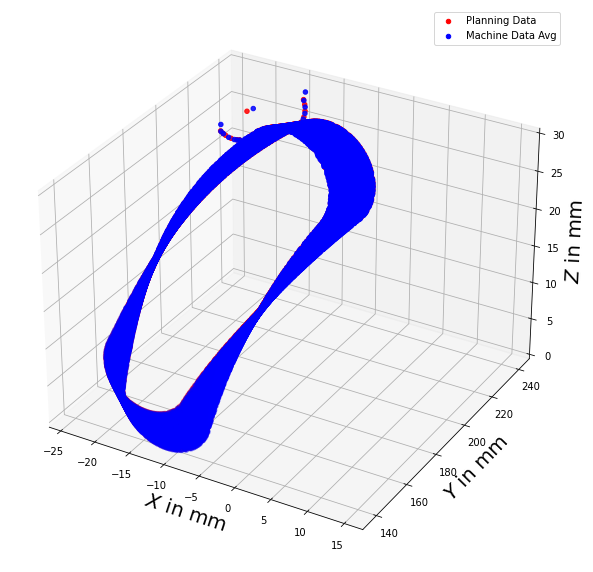

In [41]:
# Plot to show clusters
xdata, ydata, zdata = np.zeros(len(pltlst),),np.zeros(len(pltlst),),np.zeros(len(pltlst),)

plt.figure(figsize=(10,15))
ax = plt.axes(projection='3d')
ax.set_zlim3d([0,30])
ax.set_xlabel('$X$ in mm', fontsize=20)
ax.set_ylabel('$Y$ in mm', fontsize=20)
ax.set_zlabel('$Z$ in mm', fontsize=20)

for i in np.arange(len(pltlst)):
    xdata[i] = tool_tip_X[pltlst[i]]
    ydata[i] = tool_tip_Y[pltlst[i]]
    zdata[i] = tool_tip_Z[pltlst[i]]

ax.scatter3D(xdata, ydata, zdata, color = 'red',label = 'Planning Data')
ax.legend()

xdata2, ydata2, zdata2 = np.zeros(len(pltlst),),np.zeros(len(pltlst),),np.zeros(len(pltlst),)

for i in np.arange(len(pltlst)):
    xdata2[i] = np.average(X[tuple([lst3[pltlst[i]]])])
    ydata2[i] = np.average(Y[tuple([lst3[pltlst[i]]])])
    zdata2[i] = np.average(Z[tuple([lst3[pltlst[i]]])])

ax.scatter3D(xdata2, ydata2, zdata2, color = 'blue',label = 'Machine Data Avg')
ax.legend()

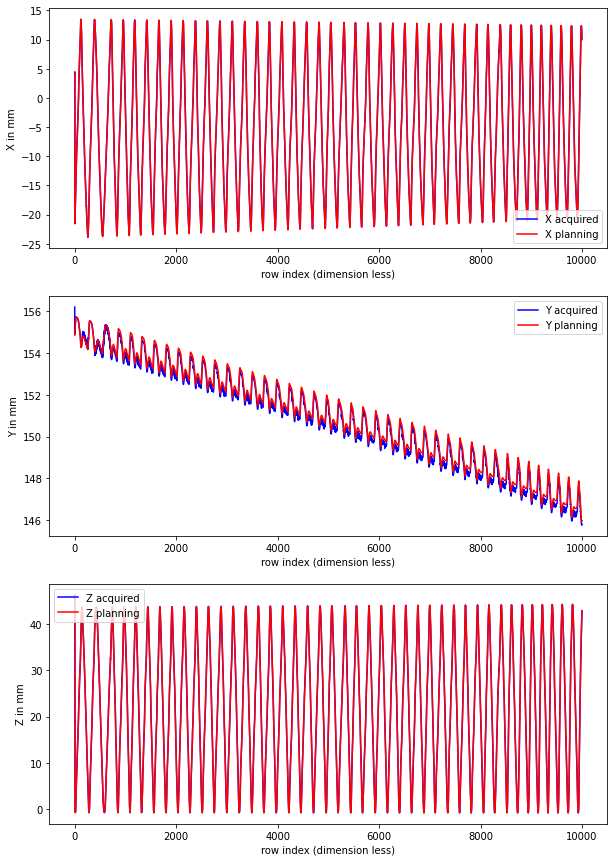

In [42]:
#subplotter(0,xdata.shape[0],xdata2,ydata2,zdata2,xdata,ydata,zdata)
subplotter(0,10000,xdata2,ydata2,zdata2,xdata,ydata,zdata)

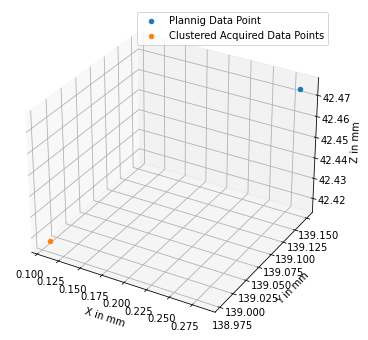

In [43]:
num = -10
xdata, ydata, zdata = np.zeros(len(lst3[pltlst[num]]),),np.zeros(len(lst3[pltlst[num]]),),np.zeros(len(lst3[pltlst[num]]),)

plt.figure(figsize=(6,6))
ax = plt.axes(projection='3d')

ax.scatter3D(tool_tip_X[pltlst[num]],tool_tip_Y[pltlst[num]] , tool_tip_Z[pltlst[num]],label='Plannig Data Point')

for i in np.arange(len(lst3[pltlst[num]])):
    xdata[i] = X[lst3[pltlst[num]]][i]
    ydata[i] = Y[lst3[pltlst[num]]][i]
    zdata[i] = Z[lst3[pltlst[num]]][i]
    
ax.scatter3D(xdata, ydata, zdata, label = 'Clustered Acquired Data Points')
ax.set_xlabel('X in mm', fontsize=10)
ax.set_ylabel('Y in mm', fontsize=10)
ax.set_zlabel('Z in mm', fontsize=10)
plt.legend()

Input two numbers between 0 and 17496 with small difference for plots exaple 10000 then 10010
0


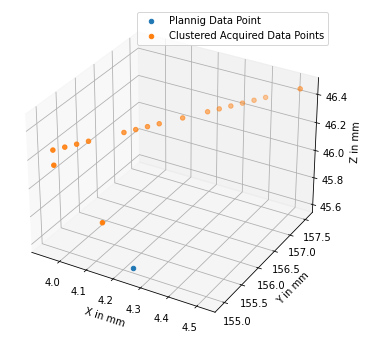

In [44]:
#for num in np.arange(len(pltlst)):
print('Input two numbers between 0 and {} with small difference for plots exaple 10000 then 10010'.format(len(pltlst)))
#lim1 = input()
#lim2 = input()

lim1 = 0
lim2 = 1

for num in np.arange(len(pltlst[int(lim1):int(lim2)])):
    xdata, ydata, zdata = np.zeros(len(lst3[pltlst[num]]),),np.zeros(len(lst3[pltlst[num]]),),np.zeros(len(lst3[pltlst[num]]),)
    
    fig = plt.figure(figsize=(6,6))
    print(num)
    ax = plt.axes(projection='3d')

    ax.scatter3D(tool_tip_X[pltlst[num]],tool_tip_Y[pltlst[num]] , tool_tip_Z[pltlst[num]], label='Plannig Data Point')

    for i in np.arange(len(lst3[pltlst[num]])):
        xdata[i] = X[lst3[pltlst[num]]][i]
        ydata[i] = Y[lst3[pltlst[num]]][i]
        zdata[i] = Z[lst3[pltlst[num]]][i]
    
    ax.scatter3D(xdata, ydata, zdata, label = 'Clustered Acquired Data Points')
    ax.set_xlabel('X in mm', fontsize=10)
    ax.set_ylabel('Y in mm', fontsize=10)
    ax.set_zlabel('Z in mm', fontsize=10)
    plt.legend()
    plt.pause(0.1)
   

In [45]:
# for the clusterd points the acquired points are averaged
lst4 = []
for i in np.arange(len(lst3)):
    lst4.append(df_m.iloc[list(lst3[i])].mean(axis=0))

mean_m = pd.concat(lst4,axis=1).T
mean_m.iloc[0:1]

DynamicData     McX  DynamicData     McY  DynamicData     McZ  \
0                  NaN                  NaN                  NaN   

   DynamicData     Mc4th  DynamicData     Mc5th  DynamicData     Spindle Load  \
0                    NaN                    NaN                           NaN   

   DynamicData     Time Stamp  DynamicData     CurrentX  \
0                         NaN                       NaN   

   DynamicData     CurrentY  DynamicData     CurrentZ  \
0                       NaN                       NaN   

   DynamicData     Current4th  DynamicData     Current5th  \
0                         NaN                         NaN   

   DynamicData     WcX  DynamicData     WcY  DynamicData     WcZ  \
0                  NaN                  NaN                  NaN   

   DynamicData     Wc4th  DynamicData     Wc5th  Statistics-Fx     Mean  \
0                    NaN                    NaN                     NaN   

   Statistics-Fx     Std  Statistics-Fx     Max  Statistics-Fx     Min  \
0                    NaN                    NaN                    NaN   

   Statistics-Fy     Mean  Statistics-Fy     Std  Statistics-Fy     Max  \
0                     NaN                    NaN                    NaN   

   Statistics-Fy     Min  Statistics-Fz     Mean  Statistics-Fz     Std  \
0                    NaN                     NaN                    NaN   

   Statistics-Fz     Max  Statistics-Fz     Min  Statistics-Mz     Mean  \
0                    NaN                    NaN                     NaN   

   Statistics-Mz     Std  Statistics-Mz     Max  Statistics-Mz     Min  \
0                    NaN                    NaN                    NaN   

   Statistics-AccX     Mean  Statistics-AccX     Std  Statistics-AccX     Max  \
0                       NaN                      NaN                      NaN   

   Statistics-AccX     Min  Statistics-AccY     Mean  Statistics-AccY     Std  \
0                      NaN                       NaN                      NaN   

   Statistics-AccY     Max  Statistics-AccY     Min  Statistics-AccZ     Mean  \
0                      NaN                      NaN                       NaN   

   Statistics-AccZ     Std  Statistics-AccZ     Max  Statistics-AccZ     Min  
0                      NaN                      NaN                      NaN

In [46]:
# distances are averaged
tcp_avg = [(lambda x: sum(x)/len(x))(item) if len(item)!=0 else np.nan for item in tcp_val]
len(tcp_avg)
#tcp_avg

31092

In [47]:
# Now the final dataframe with plannind data and the corresponding averaged acquired data is obtained 
final_df = pd.concat([df_p,mean_m, pd.DataFrame({'tcp_error':tcp_avg})], axis=1)
#final_df = final_df.drop(['Level','Step'],axis=1)
final_df = final_df.dropna()
print(final_df.shape)
final_df.iloc[0:10]

(14607, 57)


X_TTP Q [mm]  Y_TTP  [mm]  Z_TTP  [mm]  I  [rad]  J  [rad]  K  [rad]  \
10       4.408467   154.896652    45.058876  0.230558  0.968651  0.092513   
14       4.456730   154.870407    44.303917  0.230558  0.968651  0.092513   
18       4.314739   154.856323    43.560532  0.230558  0.968651  0.092513   
22       3.991534   154.855316    42.876049  0.230558  0.968651  0.092513   
177    -21.444109   154.934113     0.436844 -0.342177  0.938093 -0.053822   
179    -21.104435   154.989197     0.210410 -0.338490  0.939295 -0.056122   
183    -20.379301   155.099487    -0.170577 -0.330442  0.941915 -0.060037   
185    -19.998171   155.153717    -0.322900 -0.326101  0.943322 -0.061658   
187    -19.607723   155.206757    -0.448454 -0.321562  0.944786 -0.063061   
189    -19.210207   155.258377    -0.545971 -0.316841  0.946300 -0.064251   

     Lead  [rad]  Tilt  [rad]  X_Contact  [mm]  Y_Contact  [mm]  \
10     -0.716276     1.504966         7.512471       159.999199   
14     -1.096230     1.504535         7.511691       159.999263   
18     -1.182912     1.504219         7.510910       159.999327   
22     -1.224058     1.503978         7.510129       159.999391   
177    -1.239680     1.530632       -20.229243       161.779289   
179    -1.238178     1.526410       -20.183741       161.712364   
183    -1.230514     1.517567       -20.083076       161.564788   
185    -1.233770     1.514571       -20.031810       161.493833   
187    -1.225669     1.509704       -19.973963       161.409775   
189    -1.216391     1.504699       -19.913759       161.322683   

     Z_Contact  [mm]  DynamicData     McX  DynamicData     McY  \
10         37.389226           -31.538500          -119.916298   
14         37.388707           -31.551600          -119.165901   
18         37.388187           -31.750700          -118.446602   
22         37.387667           -32.123299          -117.804298   
177         4.987927            33.010700           -98.220901   
179         4.974419            32.200699           -98.551804   
183         4.950521            31.886000           -98.644897   
185         4.940656            31.548401           -98.732300   
187         4.932145            31.187700           -98.815498   
189         4.925203            30.803699           -98.895599   

     DynamicData     McZ  DynamicData     Mc4th  DynamicData     Mc5th  \
10           -210.059402             265.611603             -84.691803   
14           -210.155106             265.611603             -84.691803   
18           -210.279404             265.611603             -84.691803   
22           -210.424393             265.611603             -84.691803   
177          -225.697998             299.106598             -93.040604   
179          -226.099899             298.411896             -93.409401   
183          -226.186295             298.153809             -93.506500   
185          -226.249802             297.883698             -93.591003   
187          -226.291199             297.602295             -93.663200   
189          -226.311295             297.310486             -93.723396   

     DynamicData     Spindle Load  DynamicData     Time Stamp  \
10                      10.018182                3.707194e+09   
14                      10.040909                3.707194e+09   
18                      10.045455                3.707194e+09   
22                      10.050000                3.707194e+09   
177                      9.890909                3.707194e+09   
179                      9.863636                3.707194e+09   
183                      9.854546                3.707194e+09   
185                      9.854546                3.707194e+09   
187                      9.836364                3.707194e+09   
189                      9.836364                3.707194e+09   

     DynamicData     CurrentX  DynamicData     CurrentY  \
10                        0.0                       4.0   
14                        0.0              

In [48]:
final_df['block'] = block
final_df['angle'] = angle

In [49]:
print(final_df.shape)
final_df.iloc[0:10]

(14607, 59)


X_TTP Q [mm]  Y_TTP  [mm]  Z_TTP  [mm]  I  [rad]  J  [rad]  K  [rad]  \
10       4.408467   154.896652    45.058876  0.230558  0.968651  0.092513   
14       4.456730   154.870407    44.303917  0.230558  0.968651  0.092513   
18       4.314739   154.856323    43.560532  0.230558  0.968651  0.092513   
22       3.991534   154.855316    42.876049  0.230558  0.968651  0.092513   
177    -21.444109   154.934113     0.436844 -0.342177  0.938093 -0.053822   
179    -21.104435   154.989197     0.210410 -0.338490  0.939295 -0.056122   
183    -20.379301   155.099487    -0.170577 -0.330442  0.941915 -0.060037   
185    -19.998171   155.153717    -0.322900 -0.326101  0.943322 -0.061658   
187    -19.607723   155.206757    -0.448454 -0.321562  0.944786 -0.063061   
189    -19.210207   155.258377    -0.545971 -0.316841  0.946300 -0.064251   

     Lead  [rad]  Tilt  [rad]  X_Contact  [mm]  Y_Contact  [mm]  \
10     -0.716276     1.504966         7.512471       159.999199   
14     -1.096230     1.504535         7.511691       159.999263   
18     -1.182912     1.504219         7.510910       159.999327   
22     -1.224058     1.503978         7.510129       159.999391   
177    -1.239680     1.530632       -20.229243       161.779289   
179    -1.238178     1.526410       -20.183741       161.712364   
183    -1.230514     1.517567       -20.083076       161.564788   
185    -1.233770     1.514571       -20.031810       161.493833   
187    -1.225669     1.509704       -19.973963       161.409775   
189    -1.216391     1.504699       -19.913759       161.322683   

     Z_Contact  [mm]  DynamicData     McX  DynamicData     McY  \
10         37.389226           -31.538500          -119.916298   
14         37.388707           -31.551600          -119.165901   
18         37.388187           -31.750700          -118.446602   
22         37.387667           -32.123299          -117.804298   
177         4.987927            33.010700           -98.220901   
179         4.974419            32.200699           -98.551804   
183         4.950521            31.886000           -98.644897   
185         4.940656            31.548401           -98.732300   
187         4.932145            31.187700           -98.815498   
189         4.925203            30.803699           -98.895599   

     DynamicData     McZ  DynamicData     Mc4th  DynamicData     Mc5th  \
10           -210.059402             265.611603             -84.691803   
14           -210.155106             265.611603             -84.691803   
18           -210.279404             265.611603             -84.691803   
22           -210.424393             265.611603             -84.691803   
177          -225.697998             299.106598             -93.040604   
179          -226.099899             298.411896             -93.409401   
183          -226.186295             298.153809             -93.506500   
185          -226.249802             297.883698             -93.591003   
187          -226.291199             297.602295             -93.663200   
189          -226.311295             297.310486             -93.723396   

     DynamicData     Spindle Load  DynamicData     Time Stamp  \
10                      10.018182                3.707194e+09   
14                      10.040909                3.707194e+09   
18                      10.045455                3.707194e+09   
22                      10.050000                3.707194e+09   
177                      9.890909                3.707194e+09   
179                      9.863636                3.707194e+09   
183                      9.854546                3.707194e+09   
185                      9.854546                3.707194e+09   
187                      9.836364                3.707194e+09   
189                      9.836364                3.707194e+09   

     DynamicData     CurrentX  DynamicData     CurrentY  \
10                        0.0                       4.0   
14                        0.0              

In [50]:
final_df = final_df.iloc[int(final_df.shape[0]*0.05):-int(final_df.shape[0]*0.05),:]

In [51]:
print(final_df.shape)
final_df.iloc[0:10]

(13147, 59)


X_TTP Q [mm]  Y_TTP  [mm]  Z_TTP  [mm]  I  [rad]  J  [rad]  K  [rad]  \
1759     -6.196227   154.179672    33.968010  0.044009  0.995099  0.088546   
1760     -6.477368   154.174866    33.672688  0.036786  0.995432  0.088100   
1761     -6.756725   154.169739    33.375793  0.029531  0.995715  0.087634   
1763     -7.309973   154.158707    32.777039  0.014940  0.996128  0.086641   
1764     -7.583929   154.152802    32.475212  0.007611  0.996256  0.086114   
1765     -7.856357   154.146683    32.172001  0.000266  0.996332  0.085568   
1766     -8.127068   154.140335    31.867222 -0.007092  0.996355  0.085003   
1768     -8.662901   154.127106    31.252588 -0.021833  0.996242  0.083816   
1775    -10.483998   154.076523    29.049446 -0.073273  0.994146  0.079406   
1776    -10.737498   154.069031    28.726923 -0.080556  0.993616  0.078980   

      Lead  [rad]  Tilt  [rad]  X_Contact  [mm]  Y_Contact  [mm]  \
1759    -0.855170     1.483372        -1.912116       159.841167   
1760    -0.828396     1.482721        -2.209591       159.858451   
1761    -0.801133     1.482071        -2.504096       159.875405   
1763    -0.735496     1.479888        -3.099796       159.904612   
1764    -0.702045     1.478948        -3.395375       159.919793   
1765    -0.671548     1.478629        -3.682148       159.937883   
1766    -0.636621     1.478160        -3.984063       159.956201   
1768    -0.563176     1.476631        -4.552664       159.986361   
1775    -0.273366     1.472271        -6.532008       160.095464   
1776    -0.232960     1.471201        -6.795595       160.108572   

      Z_Contact  [mm]  DynamicData     McX  DynamicData     McY  \
1759        30.093678             -12.1408          -109.506798   
1760        29.819141             -11.4568          -109.323303   
1761        29.544503             -10.7689          -109.141197   
1763        28.980402              -8.7415          -108.617302   
1764        28.695872              -7.3358          -108.264999   
1765        28.416665              -6.6295          -108.090599   
1766        28.119888              -6.2089          -108.106903   
1768        27.551648              -3.1301          -107.250298   
1775        25.477144               1.7482          -106.023102   
1776        25.188989               3.8822          -105.340202   

      DynamicData     McZ  DynamicData     Mc4th  DynamicData     Mc5th  \
1759          -209.701706             276.894012             -84.970497   
1760          -209.706802             277.233490             -84.992302   
1761          -209.715897             277.573914             -85.014801   
1763          -209.765793             278.571899             -85.084801   
1764          -209.820999             279.259186             -85.136597   
1765          -209.854797             279.603394             -85.163399   
1766          -210.115906             279.799408             -85.203201   
1768          -210.083405             281.298401             -85.306000   
1775          -210.505707             283.640411             -85.495499   
1776          -210.654404             284.659485             -85.534599   

      DynamicData     Spindle Load  DynamicData     Time Stamp  \
1759                     10.050000                3.707194e+09   
1760                     10.050000                3.707194e+09   
1761                     10.050000                3.707194e+09   
1763                     10.040909                3.707194e+09   
1764                     10.031818                3.707194e+09   
1765                     10.040909                3.707194e+09   
1766                      9.904546                3.707194e+09   
1768                     10.036364                3.707194e+09   
1775                      9.950000                3.707194e+09   
1776                      9.931818                3.707194e+09   

      DynamicData     CurrentX  DynamicData     CurrentY  \
1759                       7.0                 

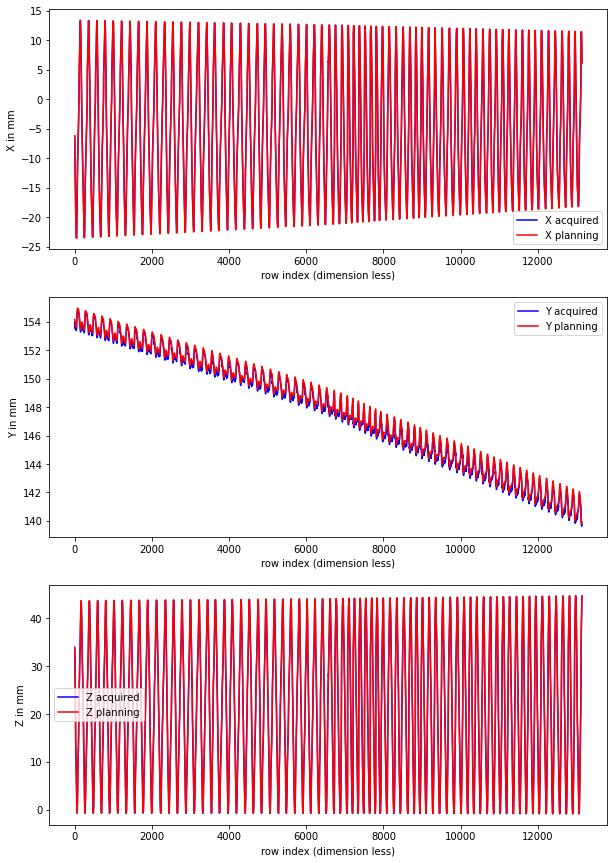

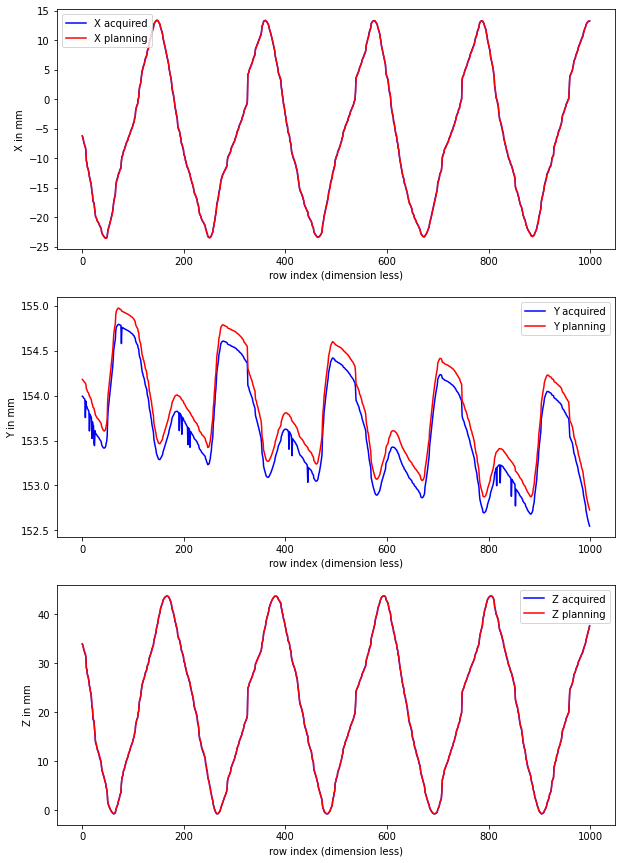

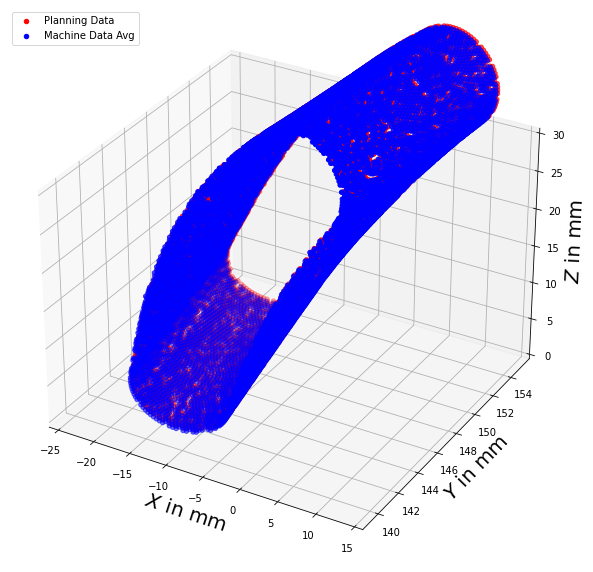

In [52]:
test(final_df, block, angle)

In [53]:
X_mc, Y_mc, Z_mc = shift(final_df, block, angle)

In [54]:
final_df['Tool Tip Point Machine X'] = X_mc
final_df['Tool Tip Point Machine Y'] = Y_mc
final_df['Tool Tip Point Machine Z'] = Z_mc

In [55]:
print(final_df.shape)
final_df.iloc[0:10]

(13147, 62)


X_TTP Q [mm]  Y_TTP  [mm]  Z_TTP  [mm]  I  [rad]  J  [rad]  K  [rad]  \
1759     -6.196227   154.179672    33.968010  0.044009  0.995099  0.088546   
1760     -6.477368   154.174866    33.672688  0.036786  0.995432  0.088100   
1761     -6.756725   154.169739    33.375793  0.029531  0.995715  0.087634   
1763     -7.309973   154.158707    32.777039  0.014940  0.996128  0.086641   
1764     -7.583929   154.152802    32.475212  0.007611  0.996256  0.086114   
1765     -7.856357   154.146683    32.172001  0.000266  0.996332  0.085568   
1766     -8.127068   154.140335    31.867222 -0.007092  0.996355  0.085003   
1768     -8.662901   154.127106    31.252588 -0.021833  0.996242  0.083816   
1775    -10.483998   154.076523    29.049446 -0.073273  0.994146  0.079406   
1776    -10.737498   154.069031    28.726923 -0.080556  0.993616  0.078980   

      Lead  [rad]  Tilt  [rad]  X_Contact  [mm]  Y_Contact  [mm]  \
1759    -0.855170     1.483372        -1.912116       159.841167   
1760    -0.828396     1.482721        -2.209591       159.858451   
1761    -0.801133     1.482071        -2.504096       159.875405   
1763    -0.735496     1.479888        -3.099796       159.904612   
1764    -0.702045     1.478948        -3.395375       159.919793   
1765    -0.671548     1.478629        -3.682148       159.937883   
1766    -0.636621     1.478160        -3.984063       159.956201   
1768    -0.563176     1.476631        -4.552664       159.986361   
1775    -0.273366     1.472271        -6.532008       160.095464   
1776    -0.232960     1.471201        -6.795595       160.108572   

      Z_Contact  [mm]  DynamicData     McX  DynamicData     McY  \
1759        30.093678             -12.1408          -109.506798   
1760        29.819141             -11.4568          -109.323303   
1761        29.544503             -10.7689          -109.141197   
1763        28.980402              -8.7415          -108.617302   
1764        28.695872              -7.3358          -108.264999   
1765        28.416665              -6.6295          -108.090599   
1766        28.119888              -6.2089          -108.106903   
1768        27.551648              -3.1301          -107.250298   
1775        25.477144               1.7482          -106.023102   
1776        25.188989               3.8822          -105.340202   

      DynamicData     McZ  DynamicData     Mc4th  DynamicData     Mc5th  \
1759          -209.701706             276.894012             -84.970497   
1760          -209.706802             277.233490             -84.992302   
1761          -209.715897             277.573914             -85.014801   
1763          -209.765793             278.571899             -85.084801   
1764          -209.820999             279.259186             -85.136597   
1765          -209.854797             279.603394             -85.163399   
1766          -210.115906             279.799408             -85.203201   
1768          -210.083405             281.298401             -85.306000   
1775          -210.505707             283.640411             -85.495499   
1776          -210.654404             284.659485             -85.534599   

      DynamicData     Spindle Load  DynamicData     Time Stamp  \
1759                     10.050000                3.707194e+09   
1760                     10.050000                3.707194e+09   
1761                     10.050000                3.707194e+09   
1763                     10.040909                3.707194e+09   
1764                     10.031818                3.707194e+09   
1765                     10.040909                3.707194e+09   
1766                      9.904546                3.707194e+09   
1768                     10.036364                3.707194e+09   
1775                      9.950000                3.707194e+09   
1776                      9.931818                3.707194e+09   

      DynamicData     CurrentX  DynamicData     CurrentY  \
1759                       7.0                 

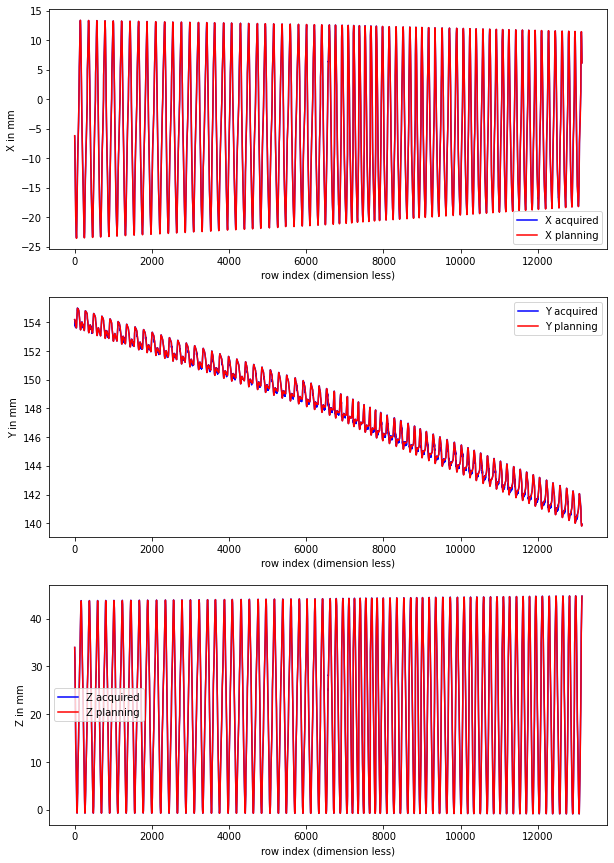

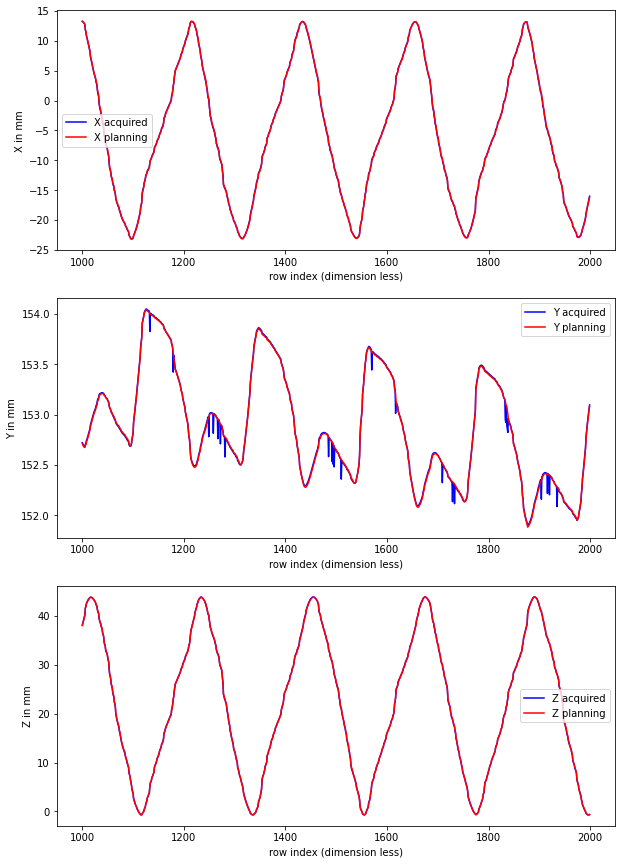

In [56]:
subplotter(0,final_df.shape[0],final_df['Tool Tip Point Machine X'].to_numpy(),final_df['Tool Tip Point Machine Y'].to_numpy(),final_df['Tool Tip Point Machine Z'].to_numpy(),final_df['X_TTP Q [mm]'].to_numpy(),final_df['Y_TTP  [mm]'].to_numpy(),final_df['Z_TTP  [mm]'].to_numpy())
subplotter(1000,2000,final_df['Tool Tip Point Machine X'].to_numpy(),final_df['Tool Tip Point Machine Y'].to_numpy(),final_df['Tool Tip Point Machine Z'].to_numpy(),final_df['X_TTP Q [mm]'].to_numpy(),final_df['Y_TTP  [mm]'].to_numpy(),final_df['Z_TTP  [mm]'].to_numpy())

In [57]:
Y_tpm = final_df['Tool Tip Point Machine Y'].to_numpy()
Y_ref = final_df['Y_TTP  [mm]'].to_numpy()

col = final_df.columns
diff = Y_tpm - Y_ref

del_pos = np.where(abs(diff)>0.1)[0]#

arr = final_df.to_numpy()
arr = np.delete(arr,del_pos, 0)

final_df = pd.DataFrame(arr,columns=col)

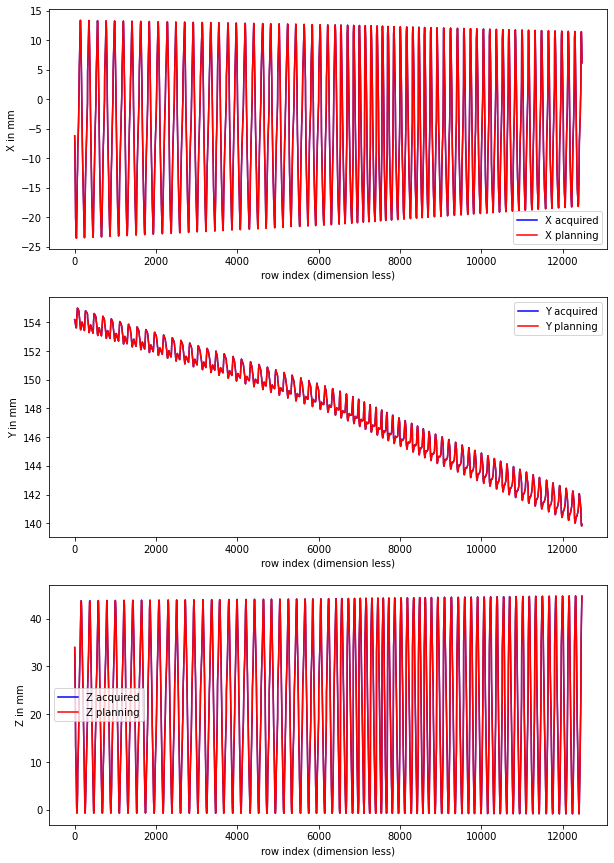

In [58]:
subplotter(0,final_df.shape[0],final_df['Tool Tip Point Machine X'].to_numpy(),final_df['Tool Tip Point Machine Y'].to_numpy(),final_df['Tool Tip Point Machine Z'].to_numpy(),final_df['X_TTP Q [mm]'].to_numpy(),final_df['Y_TTP  [mm]'].to_numpy(),final_df['Z_TTP  [mm]'].to_numpy())

median tpd =  0.1337990585546416 mean tpd = 0.1438211373543401
median xd =  0.01088173849876739 mean xd = -0.0009203379270123618
median yd =  0.009137155112597384 mean yd = 0.009688615582747476
median zd =  0.00538783917370822 mean zd = -0.001780005321652262


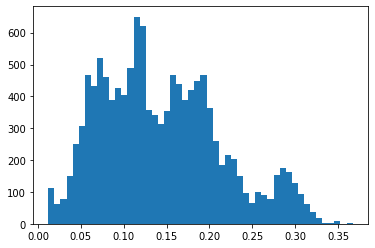

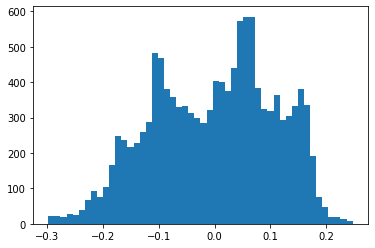

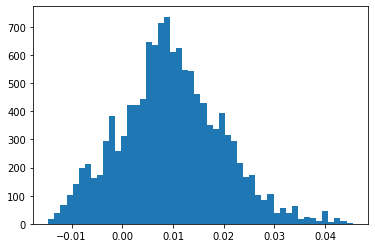

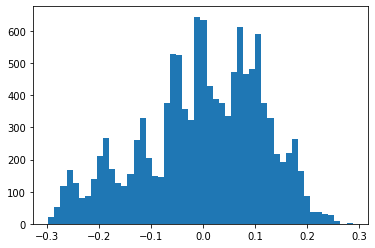

In [59]:
#tool point deviation

tool_point_deviation = np.sqrt(((final_df['Tool Tip Point Machine X'] - final_df['X_TTP Q [mm]'])**2 + (final_df['Tool Tip Point Machine Y'] - final_df['Y_TTP  [mm]'])**2 + (final_df['Tool Tip Point Machine Z'] - final_df['Z_TTP  [mm]'])**2).to_numpy(dtype=np.float64))
X_deviation = (final_df['Tool Tip Point Machine X'] - final_df['X_TTP Q [mm]']).to_numpy()
Y_deviation = (final_df['Tool Tip Point Machine Y'] - final_df['Y_TTP  [mm]']).to_numpy()
Z_deviation = (final_df['Tool Tip Point Machine Z'] - final_df['Z_TTP  [mm]']).to_numpy()

print('median tpd = ',np.median(tool_point_deviation), 'mean tpd =',np.mean(tool_point_deviation))
print('median xd = ',np.median(X_deviation), 'mean xd =',np.mean(X_deviation))
print('median yd = ',np.median(Y_deviation), 'mean yd =',np.mean(Y_deviation))
print('median zd = ',np.median(Z_deviation), 'mean zd =',np.mean(Z_deviation))

plt.hist(tool_point_deviation, bins=50)
plt.show()
plt.hist(X_deviation, bins=50)
plt.show()
plt.hist(Y_deviation, bins=50)
plt.show()
plt.hist(Z_deviation, bins=50)
plt.show()

final_df['Tool Point Deviation'] = tool_point_deviation
final_df['X_tool_path_deviation'] = X_deviation
final_df['Y_tool_path_deviation'] = Y_deviation
final_df['Z_tool_path_deviation'] = Z_deviation



In [60]:
final_df.describe()

X_TTP Q [mm]   Y_TTP  [mm]   Z_TTP  [mm]      I  [rad]      J  [rad]  \
count  12479.000000  12479.000000  12479.000000  12479.000000  12479.000000   
mean      -5.579891    147.963366     21.436990     -0.050239      0.966422   
std       10.870617      3.998610     14.994081      0.244048      0.023741   
min      -23.588478    139.806213     -0.835091     -0.391294      0.920169   
25%      -15.353405    144.479515      7.767313     -0.297961      0.951597   
50%       -6.833962    148.408875     20.749544     -0.058320      0.965813   
75%        4.431715    151.438622     35.318008      0.217511      0.988966   
max       13.364147    154.975266     44.731579      0.294676      0.999923   

           K  [rad]   Lead  [rad]   Tilt  [rad]  X_Contact  [mm]  \
count  12479.000000  12479.000000  12479.000000     12479.000000   
mean       0.025353     -0.138818      1.468877        -5.816797   
std        0.052376      0.856256      0.049893         9.848382   
min       -0.073934     -1.429867      1.361470       -20.246102   
25%       -0.019687     -0.926782      1.434638       -14.989932   
50%        0.046302     -0.257541      1.467328        -8.021041   
75%        0.070379      0.499775      1.500049         5.286696   
max        0.092339      1.599995      1.573106         9.196308   

       Y_Contact  [mm]  Z_Contact  [mm]  DynamicData     McX  \
count     12479.000000     12479.000000         12479.000000   
mean        153.968521        21.588063             2.213265   
std           4.037768        12.988440            26.149092   
min         145.255055         4.812074           -34.444801   
25%         150.495590         8.080019           -27.174801   
50%         154.510571        20.845805             1.723300   
75%         157.424552        35.769764            29.916700   
max         161.438320        39.132662            38.542500   

       DynamicData     McY  DynamicData     McZ  DynamicData     Mc4th  \
count         12479.000000         12479.000000           12479.000000   
mean           -107.318766          -224.493138             282.017296   
std              10.049609             7.104571              14.214085   
min            -125.809196          -241.413193             261.843201   
25%            -116.077049          -229.390251             266.579498   
50%            -106.414101          -223.774902             282.390503   
75%             -98.745350          -219.367302             296.389801   
max             -89.331200          -209.701706             302.050415   

       DynamicData     Mc5th  DynamicData     Spindle Load  \
count           12479.000000                  12479.000000   
mean              -88.567629                      9.925892   
std                 2.998294                      0.103657   
min               -94.239197                      9.609091   
25%               -91.154400                      9.850000   
50%               -87.362602                      9.927273   
75%               -85.988701                     10.004545   
max               -84.725304                     10.218182   

       DynamicData     Time Stamp  DynamicData     CurrentX  \
count                1.247900e+04              12479.000000   
mean                 3.707194e+09                 -0.188236   
std                  6.962873e+01                  4.252177   
min                  3.707194e+09                -10.000000   
25%                  3.707194e+09                 -3.000000   
50%                  3.707194e+09                  0.000000   
75%                  3.707194e+09                  2.000000   
max                  3.707194e+09                  8.000000   

       DynamicData     CurrentY  DynamicData     CurrentZ  \
count              12479.000000              12479.000000   
mean                  -1.695809                 45.662954   
std                   10.691177                 11.232439   
min                  -36.000000                 19.000000   
25%   

In [81]:
final_df.columns

Index(['X_TTP Q [mm]', 'Y_TTP  [mm]', 'Z_TTP  [mm]', 'I  [rad]', 'J  [rad]',
       'K  [rad]', 'Lead  [rad]', 'Tilt  [rad]', 'X_Contact  [mm]',
       'Y_Contact  [mm]', 'Z_Contact  [mm]', 'DynamicData     McX',
       'DynamicData     McY', 'DynamicData     McZ', 'DynamicData     Mc4th',
       'DynamicData     Mc5th', 'DynamicData     Spindle Load',
       'DynamicData     Time Stamp', 'DynamicData     CurrentX',
       'DynamicData     CurrentY', 'DynamicData     CurrentZ',
       'DynamicData     Current4th', 'DynamicData     Current5th',
       'DynamicData     WcX', 'DynamicData     WcY', 'DynamicData     WcZ',
       'DynamicData     Wc4th', 'DynamicData     Wc5th',
       'Statistics-Fx     Mean', 'Statistics-Fx     Std',
       'Statistics-Fx     Max', 'Statistics-Fx     Min',
       'Statistics-Fy     Mean', 'Statistics-Fy     Std',
       'Statistics-Fy     Max', 'Statistics-Fy     Min',
       'Statistics-Fz     Mean', 'Statistics-Fz     Std',
       'Statistics-Fz     Max

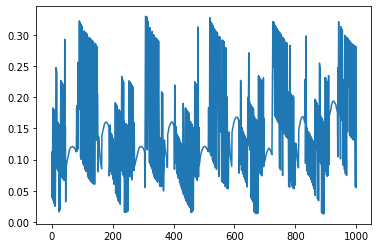

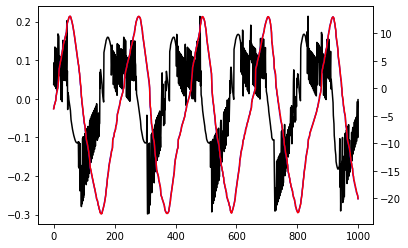

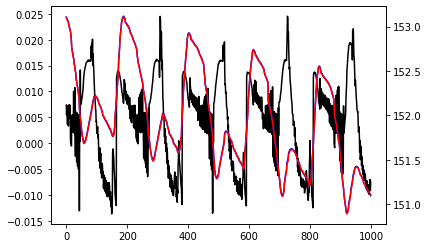

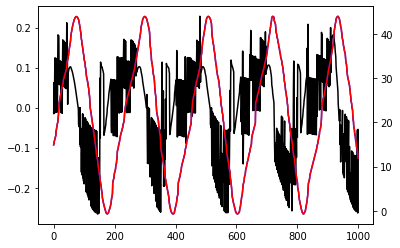

In [83]:
plt.plot(final_df['Tool Point Deviation'].iloc[2000:3000].to_numpy())
plt.show()

fig, ax_left = plt.subplots()
ax_right = ax_left.twinx()

ax_left.plot(final_df['X_tool_path_deviation'].iloc[2000:3000].to_numpy(), color='black')
ax_right.plot(final_df['Tool Tip Point Machine X'].iloc[2000:3000].to_numpy(), color='blue')
ax_right.plot(final_df['X_TTP Q [mm]'].iloc[2000:3000].to_numpy(), color='red')
plt.show()

fig, ax_left = plt.subplots()
ax_right = ax_left.twinx()

ax_left.plot(final_df['Y_tool_path_deviation'].iloc[2000:3000].to_numpy(), color='black')
ax_right.plot(final_df['Tool Tip Point Machine Y'].iloc[2000:3000].to_numpy(), color='blue')
ax_right.plot(final_df['Y_TTP  [mm]'].iloc[2000:3000].to_numpy(), color='red')
plt.show()

fig, ax_left = plt.subplots()
ax_right = ax_left.twinx()

ax_left.plot(final_df['Z_tool_path_deviation'].iloc[2000:3000].to_numpy(), color='black')
ax_right.plot(final_df['Tool Tip Point Machine Z'].iloc[2000:3000].to_numpy(), color='blue')
ax_right.plot(final_df['Z_TTP  [mm]'].iloc[2000:3000].to_numpy(), color='red')
plt.show()


In [108]:
# Proportion of standard deviation
X_std = np.std(final_df['Tool Tip Point Machine X'].to_numpy())
Y_std = np.std(final_df['Tool Tip Point Machine Y'].to_numpy())
Z_std = np.std(final_df['Tool Tip Point Machine Z'].to_numpy())

Xd_std = np.std(final_df['X_tool_path_deviation'].to_numpy())
Yd_std = np.std(final_df['Y_tool_path_deviation'].to_numpy())
Zd_std = np.std(final_df['Z_tool_path_deviation'].to_numpy())

print('X axis: ', 'Planning data std dev = ', X_std, 'X tool path deviation std dev = ', Xd_std, 'percentage = ', (Xd_std/X_std)*100, '\n')
print('Y axis: ', 'Planning data std dev = ', Y_std, 'Y tool path deviation std dev = ', Yd_std, 'percentage = ', (Yd_std/Y_std)*100, '\n')
print('Z axis: ', 'Planning data std dev = ', Z_std, 'Z tool path deviation std dev = ', Zd_std, 'percentage = ', (Zd_std/Z_std)*100 , '\n')


X axis:  Planning data std dev =  10.854580571609281 X tool path deviation std dev =  0.10873203815247294 percentage =  1.0017157036621684 

Y axis:  Planning data std dev =  3.994896020939259 Y tool path deviation std dev =  0.010007262924607017 percentage =  0.25050121134953 

Z axis:  Planning data std dev =  15.005979578846212 Z tool path deviation std dev =  0.1165689737127414 percentage =  0.7768168222557599 



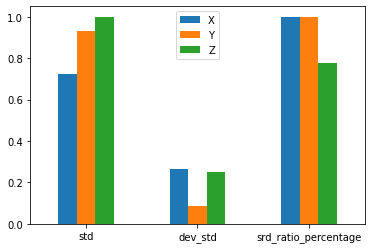

In [116]:
d1 = [X_std, Y_std, Z_std]
d11 = [float(i)/max(d1) for i in d1]

d2 = [Xd_std, Yd_std, Zd_std ]
d22 = [float(i)/max(d2) for i in d2]

d3 = [(Xd_std/X_std)*100, (Yd_std/Y_std)*100 , (Zd_std/Z_std)*100 ]
d33 = [float(i)/max(d3) for i in d3]

index = ['std','dev_std','srd_ratio_percentage']

dfbar1 = pd.DataFrame({'X':d11,'Y': d22,'Z': d33},index=index)
ax = dfbar1.plot.bar(rot=0)

In [117]:
d11

[0.7233503494107696, 0.26622027572067514, 1.0]

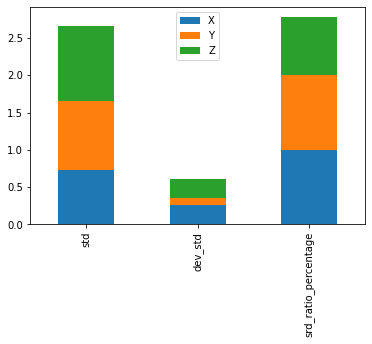

In [114]:
ax = dfbar1.plot.bar(stacked=True)

In [75]:
final_df.iloc[0:10]

X_TTP Q [mm]  Y_TTP  [mm]  Z_TTP  [mm]  I  [rad]  J  [rad]  K  [rad]  \
0     -6.196227   154.179672    33.968010  0.044009  0.995099  0.088546   
1     -6.477368   154.174866    33.672688  0.036786  0.995432  0.088100   
2     -6.756725   154.169739    33.375793  0.029531  0.995715  0.087634   
3     -7.309973   154.158707    32.777039  0.014940  0.996128  0.086641   
4     -7.583929   154.152802    32.475212  0.007611  0.996256  0.086114   
5     -7.856357   154.146683    32.172001  0.000266  0.996332  0.085568   
6     -8.662901   154.127106    31.252588 -0.021833  0.996242  0.083816   
7    -10.483998   154.076523    29.049446 -0.073273  0.994146  0.079406   
8    -10.737498   154.069031    28.726923 -0.080556  0.993616  0.078980   
9    -11.487780   154.046494    27.746206 -0.102239  0.991681  0.078206   

   Lead  [rad]  Tilt  [rad]  X_Contact  [mm]  Y_Contact  [mm]  \
0    -0.855170     1.483372        -1.912116       159.841167   
1    -0.828396     1.482721        -2.209591       159.858451   
2    -0.801133     1.482071        -2.504096       159.875405   
3    -0.735496     1.479888        -3.099796       159.904612   
4    -0.702045     1.478948        -3.395375       159.919793   
5    -0.671548     1.478629        -3.682148       159.937883   
6    -0.563176     1.476631        -4.552664       159.986361   
7    -0.273366     1.472271        -6.532008       160.095464   
8    -0.232960     1.471201        -6.795595       160.108572   
9    -0.112214     1.469469        -7.618493       160.158321   

   Z_Contact  [mm]  DynamicData     McX  DynamicData     McY  \
0        30.093678             -12.1408          -109.506798   
1        29.819141             -11.4568          -109.323303   
2        29.544503             -10.7689          -109.141197   
3        28.980402              -8.7415          -108.617302   
4        28.695872              -7.3358          -108.264999   
5        28.416665              -6.6295          -108.090599   
6        27.551648              -3.1301          -107.250298   
7        25.477144               1.7482          -106.023102   
8        25.188989               3.8822          -105.340202   
9        24.270203               5.2308          -104.862999   

   DynamicData     McZ  DynamicData     Mc4th  DynamicData     Mc5th  \
0          -209.701706             276.894012             -84.970497   
1          -209.706802             277.233490             -84.992302   
2          -209.715897             277.573914             -85.014801   
3          -209.765793             278.571899             -85.084801   
4          -209.820999             279.259186             -85.136597   
5          -209.854797             279.603394             -85.163399   
6          -210.083405             281.298401             -85.306000   
7          -210.505707             283.640411             -85.495499   
8          -210.654404             284.659485             -85.534599   
9          -210.738495             285.302490             -85.546097   

   DynamicData     Spindle Load  DynamicData     Time Stamp  \
0                     10.050000                3.707194e+09   
1                     10.050000                3.707194e+09   
2                     10.050000                3.707194e+09   
3                     10.040909                3.707194e+09   
4                     10.031818                3.707194e+09   
5                     10.040909                3.707194e+09   
6                     10.036364                3.707194e+09   
7                      9.950000                3.707194e+09   
8                      9.931818                3.707194e+09   
9                      9.904546                3.707194e+09   

   DynamicData     CurrentX  DynamicData     CurrentY  \
0                       7.0                      14.0   
1                       7.0                      14.0   
2                       7.0                      14.0   
3                       8.0              

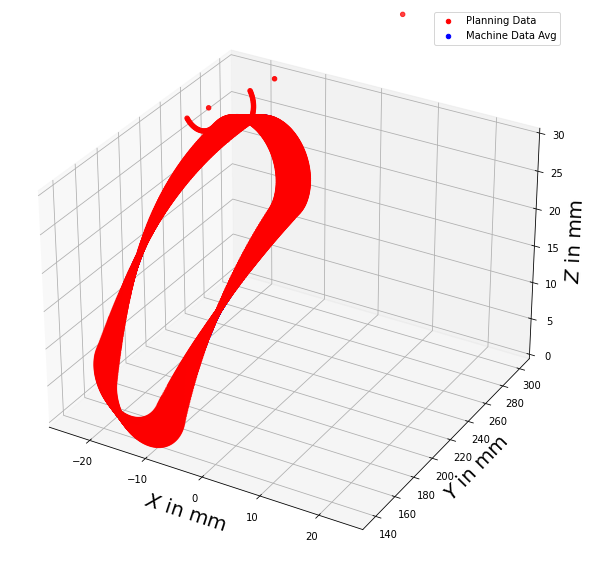

In [62]:
plt.figure(figsize=(10,15))
ax1 = plt.axes(projection='3d')
ax1.set_zlim3d([0,30])

ax1.set_xlabel('$X$ in mm', fontsize=20)
ax1.set_ylabel('$Y$ in mm', fontsize=20)
ax1.set_zlabel('$Z$ in mm', fontsize=20)

ax1.scatter3D(X_inv, Y_inv, Z_inv, color = 'red',label = 'Planning Data')
ax1.legend()

ax1.scatter3D(final_df['Tool Tip Point Machine X'].to_numpy(), final_df['Tool Tip Point Machine Y'].to_numpy(), final_df['Tool Tip Point Machine Z'].to_numpy(), color = 'blue',label = 'Machine Data Avg')
ax1.legend()